# Dataset NCBI - Extraction des entités nommées

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import re
import os
from typing import List, Dict, Tuple, Optional
import importlib
import models
import utils
from collections import Counter
importlib.reload(models)
importlib.reload(utils)
from models.models import *
from utils.datasetloader import NERDataset
from utils.fonctions import (
    load_jnlpba_dataset, load_ncbi_dataset,prepare_ncbi_for_ner,create_embedding_matrix_from_word2vec,load_word2vec_model,save_word2vec_model,train_word2vec_embeddings, visualize_dataset_distribution

)
from utils.creation_vocabulaire import create_vocab,create_char_vocab,create_tag_mapping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

print("Utilisation du dispositif : ","cuda" if torch.cuda.is_available() else "cpu")

Utilisation du dispositif :  cuda


## ÉTAPE 2: DATA PREPROCESSING

In [3]:
ncbi_data = load_ncbi_dataset("./datasets/NCBI-Corpus")
ncbi_sentences = prepare_ncbi_for_ner(ncbi_data)
print(ncbi_sentences[1])

Chargement du dataset NCBI depuis: ./datasets/NCBI-Corpus
Documents chargés: 793
Exemple d'entités dans le premier document: 2
(['However', ',', 'the', 'function', 'of', 'the', 'BRCA1', 'protein', 'has', 'remained', 'elusive', '.'], ['I-CompositeMention', 'I-CompositeMention', 'I-CompositeMention', 'I-CompositeMention', 'I-CompositeMention', 'I-CompositeMention', 'I-CompositeMention', 'O', 'O', 'O', 'O', 'O'])


Création de dataset NCBI

In [4]:
def create_ncbi_dataloaders(ncbi_sentences, batch_size=32, max_seq_len=200, word2vec_path=None):
    """
    Crée les DataLoaders pour NCBI avec Word2Vec
    """
    # 1. Créer les vocabulaires
    vocab = create_vocab(ncbi_sentences, min_freq=2)
    char_vocab = create_char_vocab(ncbi_sentences)
    
    # 2. Créer le mapping des tags
    tag_to_idx, idx_to_tag = create_tag_mapping(ncbi_sentences)
    
    # 3. Diviser en train/dev/test
    total = len(ncbi_sentences)
    train_size = int(0.7 * total)
    dev_size = int(0.15 * total)
    
    train_sentences = ncbi_sentences[:train_size]
    dev_sentences = ncbi_sentences[train_size:train_size + dev_size]
    test_sentences = ncbi_sentences[train_size + dev_size:]
    
    print(f"NCBI - Train: {len(train_sentences)}, Dev: {len(dev_sentences)}, Test: {len(test_sentences)}")
    
    # 4. Entraîner ou charger Word2Vec
    if word2vec_path and os.path.exists(word2vec_path):
        print(f"Chargement du modèle Word2Vec depuis: {word2vec_path}")
        word2vec_model = load_word2vec_model(word2vec_path)
    else:
        print("Entraînement d'un nouveau modèle Word2Vec...")
        # Entraîner sur toutes les données
        word2vec_model = train_word2vec_embeddings(ncbi_sentences)
        
        # Sauvegarder le modèle
        if word2vec_path:
            save_word2vec_model(word2vec_model, word2vec_path)
    
    # 5. Créer la matrice d'embeddings
    pretrained_embeddings = create_embedding_matrix_from_word2vec(word2vec_model, vocab)
    
    # 6. Créer les datasets
    train_dataset = NERDataset(train_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    dev_dataset = NERDataset(dev_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    test_dataset = NERDataset(test_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    
    # 7. Créer les Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return {
        'train_loader': train_loader,
        'dev_loader': dev_loader,
        'test_loader': test_loader,
        'vocab': vocab,
        'char_vocab': char_vocab,
        'tag_to_idx': tag_to_idx,
        'idx_to_tag': idx_to_tag,
        'pretrained_embeddings': pretrained_embeddings,
        'train_sentences': train_sentences,
        'dev_sentences': dev_sentences,
        'test_sentences': test_sentences,
        'word2vec_model': word2vec_model
    }

BATCH_SIZE = 32
results_ncbi = ncbi_data_loaders = create_ncbi_dataloaders(
    ncbi_sentences,
    batch_size=BATCH_SIZE,
    word2vec_path="./word2Vecembeddings/ncbi"
)

Format vocab: Tuple (tokens, labels)
Vocabulaire créé: 5925 mots
Mots uniques: 10845
Mots avec fréquence >= 2: 5922
Format char vocab: Tuple (tokens, labels)
Vocabulaire caractères créé: 86 caractères
Caractères uniques: 84
Format tag mapping: Tuple (tokens, labels)
Mapping tags créé: 10 tags uniques
Tags: ['B-CompositeMention', 'B-DiseaseClass', 'B-Modifier', 'B-SpecificDisease', 'I-CompositeMention', 'I-DiseaseClass', 'I-Modifier', 'I-SpecificDisease', 'O']
NCBI - Train: 5266, Dev: 1128, Test: 1130
Entraînement d'un nouveau modèle Word2Vec...
Nombre de phrases pour Word2Vec: 7524
Première phrase: ['germline', 'mutations', 'in', 'brca1', 'are', 'responsible', 'for', 'most', 'cases', 'of']...
Entraînement du modèle Word2Vec...
Vocabulaire Word2Vec: 5922 mots
Taille des vecteurs: 200
Modèle Word2Vec sauvegardé: ./word2Vecembeddings/ncbi.model
Mots trouvés dans Word2Vec: 5922
Mots non trouvés: 0
Couverture: 100.00%
Dataset créé: 5266 phrases valides
Dataset créé: 1128 phrases valides
Dat

In [5]:
train_loader = results_ncbi['train_loader']

# Récupérer un batch
for batch in train_loader:
    word_ids, char_seqs, tag_ids, lengths = batch
    break  # on prend juste le premier batch pour l'exemple

# Afficher les shapes
print("word_ids shape:", word_ids.shape)   # [batch_size, max_seq_len]
print("char_seqs shape:", char_seqs.shape) # [batch_size, max_seq_len, max_char_len]
print("tag_ids shape:", tag_ids.shape)     # [batch_size, max_seq_len]
print("lengths:", lengths) 

# Afficher un exemple de tokens/labels pour le premier élément du batch
idx_to_word = {v:k for k,v in results_ncbi['vocab'].items()}  # optionnel si tu veux décoder
idx_to_tag = results_ncbi['idx_to_tag']

print("\nPremier exemple du batch:")
print("Word IDs :", word_ids[0])
print("Char IDs :", char_seqs[0])
print("Tag IDs  :", tag_ids[0])
print("Longueur réelle:", lengths[0])

# Pour afficher les mots et labels décodés
decoded_words = [idx_to_word.get(w.item(), '<UNK>') for w in word_ids[0][:lengths[0]]]
decoded_tags  = [idx_to_tag[t.item()] for t in tag_ids[0][:lengths[0]]]

print("\nDécodé (mots, tags) :", list(zip(decoded_words, decoded_tags))) 

word_ids shape: torch.Size([32, 200])
char_seqs shape: torch.Size([32, 200, 20])
tag_ids shape: torch.Size([32, 200])
lengths: tensor([ 1,  2, 64, 31, 15, 27,  1, 27, 30, 27, 13, 20, 14, 25, 22, 23, 27, 18,
        16, 20, 29, 14, 11, 23, 21, 22, 28, 12,  2, 13,  1, 12])

Premier exemple du batch:
Word IDs : tensor([18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0

In [6]:
# Avant d'appeler visualize_dataset_distribution, convertissez :
def convert_ncbi_format(ncbi_sentences):
    """Convertit [(tokens, tags)] en [[(token, tag), ...]]"""
    converted = []
    for tokens, tags in ncbi_sentences:
        # Créer une liste de tuples (token, tag)
        sentence = [(token, tag) for token, tag in zip(tokens, tags)]
        converted.append(sentence)
    return converted

# Utilisation
converted_ncbi = {
    'train_sentences': convert_ncbi_format(results_ncbi.get('train_sentences', [])),
    'dev_sentences': convert_ncbi_format(results_ncbi.get('dev_sentences', [])),
    'test_sentences': convert_ncbi_format(results_ncbi.get('test_sentences', [])),
    'vocab': results_ncbi.get('vocab', {}),
    'char_vocab': results_ncbi.get('char_vocab', {}),
    'tag_to_idx': results_ncbi.get('tag_to_idx', {})
}


In [7]:
#visualize_dataset_distribution(results_ncbi, dataset_name="NCBI")

Model architecture 

In [8]:
from tqdm import tqdm
def train_epoch(model, dataloader, optimizer, device):
    """
    Entraînement pour une epoch avec CRF
    """
    model.train()
    total_loss = 0.0

    for batch in tqdm(dataloader,total=len(dataloader),desc="Training"):
        word_ids, char_seqs, tag_ids, lengths = batch

        word_ids = word_ids.to(device)
        char_seqs = char_seqs.to(device)
        tag_ids = tag_ids.to(device)

        mask = (word_ids != 0)
        optimizer.zero_grad()
        # Passer les tags -> forward retourne la loss directement
        loss = model(word_ids, char_seqs, mask, tag_ids)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def evaluate(model, dataloader, device, idx_to_tag):
    """
    Evaluate model (CRF)
    """
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in dataloader:
            word_ids, char_seqs, tag_ids, lengths = batch

            word_ids = word_ids.to(device)
            char_seqs = char_seqs.to(device)
            tag_ids = tag_ids.to(device)

            mask = (word_ids != 0)

            # Calculer la loss (tags fournis)
            loss = model(word_ids, char_seqs, mask, tag_ids)
            total_loss += loss.item()

            # Décoder les séquences pour obtenir les prédictions
            predictions = model(word_ids, char_seqs, mask, tags=None)  # renvoie une list
            # Stocker les prédictions et targets
            for preds_seq, tag_seq, seq_len in zip(predictions, tag_ids, lengths):
                preds_seq = preds_seq[:seq_len]          # découper au vrai length
                tag_seq = tag_seq[:seq_len].cpu().numpy()  # tag_ids tensor -> numpy

                pred_tags = [idx_to_tag.get(idx, 'O') for idx in preds_seq]
                target_tags = [idx_to_tag.get(idx, 'O') for idx in tag_seq]

                all_predictions.extend(pred_tags)
                all_targets.extend(target_tags)

    return total_loss / len(dataloader), all_predictions, all_targets



def calculate_metrics(predictions, targets):
    """
    Calculate precision, recall, F1-score
    """
    from sklearn.metrics import precision_recall_fscore_support
    
    # Filter out 'O' tags for entity-specific metrics
    entity_preds = []
    entity_targets = []
    
    for pred, target in zip(predictions, targets):
        if target != 'O' or pred != 'O':
            entity_preds.append(pred)
            entity_targets.append(target)
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        entity_targets, entity_preds, average='macro', zero_division=0
    )
    
    return precision, recall, f1


NCBI Dataset

In [9]:
def run_pipeline(
    dataset_name: str,
    loaders: dict,
    use_char_cnn: bool = False,
    use_char_lstm: bool = False,
    use_attention: bool = False,
    use_fc_fusion: bool = False,
    embedding_url: str = None,
    lstm_hidden_dim: Optional[int] = None,
    epochs: int = 40,
    patience: int = 4,   
    checkpoints_dir="./checkpoints",
):
    train_loader = loaders['train_loader']
    dev_loader   = loaders['dev_loader']
    test_loader  = loaders['test_loader']

    vocab        = loaders['vocab']
    char_vocab   = loaders['char_vocab']
    tag_to_idx   = loaders['tag_to_idx']
    idx_to_tag   = loaders['idx_to_tag']

    comb_name = "WE"
    if use_char_cnn and use_char_lstm:
        comb_name += "_char_bilstm_cnn"
    elif use_char_cnn:
        comb_name += "_char_cnn"
    elif use_char_lstm:
        comb_name += "_char_bilstm"

    if use_attention:
        comb_name += "_attention"
    if use_fc_fusion:
        comb_name += "_fc"

    checkpoints_path = f"{checkpoints_dir}/{comb_name}/best_model.pt"
    os.makedirs(os.path.dirname(checkpoints_path), exist_ok=True)

    # Chargement des embeddings
    if embedding_url:
        pretrained_embeddings = load_word2vec_model(embedding_url)
    elif 'pretrained_embeddings' in loaders and loaders['pretrained_embeddings'] is not None:
        pretrained_embeddings = loaders['pretrained_embeddings']
    else:
        print("Embedding nul")
        return

    if lstm_hidden_dim is None:
        lstm_hidden_dim = 256 if dataset_name == 'JNLPBA' else 128

    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = CombinatorialNER(
        vocab_size=len(vocab),
        char_vocab_size=len(char_vocab),
        tag_to_idx=tag_to_idx,
        dataset=dataset_name,
        use_char_cnn=use_char_cnn,
        use_char_lstm=use_char_lstm,
        use_attention=use_attention,
        use_fc_fusion=use_fc_fusion,
        pretrained_embeddings=pretrained_embeddings,
        word_embed_dim=200,
        lstm_hidden_dim=lstm_hidden_dim,
        dropout=0.5
    ).to(device)

    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Adam optimizer avec L2 / weight decay
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

    # Scheduler manuel: decay rate selon dataset
    decay_rate = 0.90 if dataset_name == 'JNLPBA' else 0.95

    best_f1 = 0.0
    patience_counter = 0
    history = {
        'train_loss': [], 'dev_loss': [], 'dev_f1': [],
        'dev_precision': [], 'dev_recall': [], 'lr': []
    }

    for epoch in range(epochs):
        # 1. Train
        train_loss = train_epoch(model, train_loader, optimizer, device)

        # 2. Eval
        dev_loss, dev_preds, dev_targets = evaluate(model, dev_loader, device, idx_to_tag)
        precision, recall, f1 = calculate_metrics(dev_preds, dev_targets)

        # 3. Appliquer decay rate
        for g in optimizer.param_groups:
            g['lr'] *= decay_rate

        # 4. Historique
        history['train_loss'].append(train_loss)
        history['dev_loss'].append(dev_loss)
        history['dev_f1'].append(f1)
        history['dev_precision'].append(precision)
        history['dev_recall'].append(recall)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        print(
            f"Epoch {epoch+1:02d}/{epochs} | "
            f"Train loss: {train_loss:.4f} | "
            f"Dev loss: {dev_loss:.4f} | "
            f"P: {precision:.4f} R: {recall:.4f} F1: {f1:.4f} | "
            f"LR: {optimizer.param_groups[0]['lr']:.6f}"
        )

        # 5. Early stopping
        if f1 > best_f1:
            best_f1 = f1
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_f1': best_f1,
            }, checkpoints_path)
            print(f"Meilleur modèle sauvegardé: F1 {f1:.4f}")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered après {epoch+1} epochs.")
            break

    # Charger meilleur modèle
    checkpoint = torch.load(checkpoints_path)
    model.load_state_dict(checkpoint['model_state_dict'])

    test_loss, test_preds, test_targets = evaluate(model, test_loader, device, idx_to_tag)
    precision, recall, f1 = calculate_metrics(test_preds, test_targets)

    print("\n" + "="*50)
    print("RÉSULTATS FINAUX SUR LE TEST SET")
    print("="*50)
    print(f"Loss: {test_loss:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("="*50)

    return model, history


## Combinaison 1 : WE

In [10]:
model_ncbi_we, history_ncbi_we = run_pipeline(
    dataset_name='NCBI',
    loaders=results_ncbi,       # pre-loaded loaders including pretrained_embeddings
    use_char_cnn=False,
    use_char_lstm=False,
    use_attention=False,
    use_fc_fusion=False,
    embedding_url=None,            # uses loaders['pretrained_embeddings']
    epochs=40,                     # max epochs
    patience=4,                    # early stopping after 4 epochs without improvement
    checkpoints_dir="./checkpoints/NCBI/we",
)


Model parameters: 1,187,130


Training: 100%|██████████| 165/165 [00:47<00:00,  3.47it/s]


Epoch 01/40 | Train loss: 800.8603 | Dev loss: 525.0159 | P: 0.0938 R: 0.0014 F1: 0.0027 | LR: 0.000950
Meilleur modèle sauvegardé: F1 0.0027


Training: 100%|██████████| 165/165 [00:40<00:00,  4.09it/s]


Epoch 02/40 | Train loss: 472.8366 | Dev loss: 435.5975 | P: 0.3812 R: 0.0743 F1: 0.1047 | LR: 0.000902
Meilleur modèle sauvegardé: F1 0.1047


Training: 100%|██████████| 165/165 [00:30<00:00,  5.32it/s]


Epoch 03/40 | Train loss: 392.1409 | Dev loss: 382.1659 | P: 0.4629 R: 0.1065 F1: 0.1477 | LR: 0.000857
Meilleur modèle sauvegardé: F1 0.1477


Training: 100%|██████████| 165/165 [00:30<00:00,  5.35it/s]


Epoch 04/40 | Train loss: 337.6283 | Dev loss: 343.7934 | P: 0.4359 R: 0.1370 F1: 0.1814 | LR: 0.000815
Meilleur modèle sauvegardé: F1 0.1814


Training: 100%|██████████| 165/165 [00:30<00:00,  5.36it/s]


Epoch 05/40 | Train loss: 296.9792 | Dev loss: 313.8438 | P: 0.4631 R: 0.1521 F1: 0.1991 | LR: 0.000774
Meilleur modèle sauvegardé: F1 0.1991


Training: 100%|██████████| 165/165 [00:31<00:00,  5.28it/s]


Epoch 06/40 | Train loss: 265.1778 | Dev loss: 290.4728 | P: 0.4729 R: 0.1638 F1: 0.2141 | LR: 0.000735
Meilleur modèle sauvegardé: F1 0.2141


Training: 100%|██████████| 165/165 [00:31<00:00,  5.19it/s]


Epoch 07/40 | Train loss: 239.6459 | Dev loss: 271.9710 | P: 0.5684 R: 0.1793 F1: 0.2345 | LR: 0.000698
Meilleur modèle sauvegardé: F1 0.2345


Training: 100%|██████████| 165/165 [00:34<00:00,  4.84it/s]


Epoch 08/40 | Train loss: 218.4785 | Dev loss: 256.3947 | P: 0.4649 R: 0.1777 F1: 0.2305 | LR: 0.000663


Training: 100%|██████████| 165/165 [01:08<00:00,  2.42it/s]


Epoch 09/40 | Train loss: 201.4403 | Dev loss: 243.7328 | P: 0.5450 R: 0.1827 F1: 0.2411 | LR: 0.000630
Meilleur modèle sauvegardé: F1 0.2411


Training: 100%|██████████| 165/165 [01:07<00:00,  2.44it/s]


Epoch 10/40 | Train loss: 187.0448 | Dev loss: 232.8202 | P: 0.5434 R: 0.1923 F1: 0.2535 | LR: 0.000599
Meilleur modèle sauvegardé: F1 0.2535


Training: 100%|██████████| 165/165 [01:15<00:00,  2.20it/s]


Epoch 11/40 | Train loss: 174.9960 | Dev loss: 224.3821 | P: 0.6629 R: 0.1978 F1: 0.2638 | LR: 0.000569
Meilleur modèle sauvegardé: F1 0.2638


Training: 100%|██████████| 165/165 [01:13<00:00,  2.25it/s]


Epoch 12/40 | Train loss: 164.7357 | Dev loss: 216.8885 | P: 0.5209 R: 0.2004 F1: 0.2613 | LR: 0.000540


Training: 100%|██████████| 165/165 [01:15<00:00,  2.19it/s]


Epoch 13/40 | Train loss: 156.0317 | Dev loss: 210.1095 | P: 0.5332 R: 0.2035 F1: 0.2715 | LR: 0.000513
Meilleur modèle sauvegardé: F1 0.2715


Training: 100%|██████████| 165/165 [01:14<00:00,  2.20it/s]


Epoch 14/40 | Train loss: 148.5552 | Dev loss: 204.7752 | P: 0.6121 R: 0.2295 F1: 0.3083 | LR: 0.000488
Meilleur modèle sauvegardé: F1 0.3083


Training: 100%|██████████| 165/165 [01:12<00:00,  2.26it/s]


Epoch 15/40 | Train loss: 142.1290 | Dev loss: 199.9887 | P: 0.6048 R: 0.2375 F1: 0.3167 | LR: 0.000463
Meilleur modèle sauvegardé: F1 0.3167


Training: 100%|██████████| 165/165 [01:15<00:00,  2.20it/s]


Epoch 16/40 | Train loss: 136.4781 | Dev loss: 195.6088 | P: 0.5973 R: 0.2393 F1: 0.3195 | LR: 0.000440
Meilleur modèle sauvegardé: F1 0.3195


Training: 100%|██████████| 165/165 [01:12<00:00,  2.27it/s]


Epoch 17/40 | Train loss: 131.5192 | Dev loss: 192.3679 | P: 0.6000 R: 0.2444 F1: 0.3250 | LR: 0.000418
Meilleur modèle sauvegardé: F1 0.3250


Training: 100%|██████████| 165/165 [00:46<00:00,  3.56it/s]


Epoch 18/40 | Train loss: 127.1978 | Dev loss: 188.6240 | P: 0.5954 R: 0.2512 F1: 0.3314 | LR: 0.000397
Meilleur modèle sauvegardé: F1 0.3314


Training: 100%|██████████| 165/165 [00:31<00:00,  5.29it/s]


Epoch 19/40 | Train loss: 123.2929 | Dev loss: 185.8521 | P: 0.5945 R: 0.2441 F1: 0.3248 | LR: 0.000377


Training: 100%|██████████| 165/165 [00:30<00:00,  5.39it/s]


Epoch 20/40 | Train loss: 119.8516 | Dev loss: 183.3945 | P: 0.6044 R: 0.2484 F1: 0.3305 | LR: 0.000358


Training: 100%|██████████| 165/165 [00:30<00:00,  5.33it/s]


Epoch 21/40 | Train loss: 116.7704 | Dev loss: 181.0138 | P: 0.5839 R: 0.2517 F1: 0.3303 | LR: 0.000341


Training: 100%|██████████| 165/165 [00:30<00:00,  5.40it/s]


Epoch 22/40 | Train loss: 113.9677 | Dev loss: 178.7880 | P: 0.5827 R: 0.2504 F1: 0.3288 | LR: 0.000324
Early stopping triggered après 22 epochs.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_40232\3419951289.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoints_path)



RÉSULTATS FINAUX SUR LE TEST SET
Loss: 180.5504
Precision: 0.5894
Recall: 0.3317
F1-score: 0.4099


In [11]:
def print_model_layers(model: torch.nn.Module):
    print(f"{'Layer (type)':30} | {'Param #':>12}")
    print("-"*45)
    total_params = 0
    for name, module in model.named_modules():
        if len(list(module.children())) == 0: 
            param_count = sum(p.numel() for p in module.parameters())
            print(f"{name + ' (' + module.__class__.__name__ + ')':30} | {param_count:12,}")
            total_params += param_count
    print("-"*45)
    print(f"{'Total parameters':30} | {total_params:12,}")


In [12]:
print_model_layers(model_ncbi_we)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    1,185,000
emission (Linear)              |        2,010
crf (CRF)                      |          120
---------------------------------------------
Total parameters               |    1,187,130


In [13]:
import pickle
import os

def save_vocabularies(data_dict, save_dir):
    """Sauvegarde les vocabulaires et mappings"""
    os.makedirs(save_dir, exist_ok=True)
    
    with open(os.path.join(save_dir, 'vocab.pkl'), 'wb') as f:
        pickle.dump(data_dict['vocab'], f)
    
    with open(os.path.join(save_dir, 'char_vocab.pkl'), 'wb') as f:
        pickle.dump(data_dict['char_vocab'], f)
    
    with open(os.path.join(save_dir, 'tag_to_idx.pkl'), 'wb') as f:
        pickle.dump(data_dict['tag_to_idx'], f)
    
    with open(os.path.join(save_dir, 'idx_to_tag.pkl'), 'wb') as f:
        pickle.dump(data_dict['idx_to_tag'], f)
    
    print(f"Vocabulaires sauvegardés dans {save_dir}")
    
save_vocabularies(results_ncbi, './vocab/ncbi')

Vocabulaires sauvegardés dans ./vocab/ncbi


In [14]:
import matplotlib.pyplot as plt

def plot_training_history(history, dataset_name):
    """
    Visualise l'historique d'entraînement avec Loss, F1, Precision, Recall
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 11))
    fig.suptitle(f'Training History - {dataset_name}', fontsize=16, fontweight='bold')

    epochs = range(1, len(history['train_loss']) + 1)

    # ─────────────────────────────────────────────
    # Plot 1: Train vs Dev Loss
    # ─────────────────────────────────────────────
    axes[0, 0].plot(epochs, history['train_loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(epochs, history['dev_loss'], label='Dev Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Train vs Dev Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # ─────────────────────────────────────────────
    # Plot 2: Dev Precision / Recall / F1
    # ─────────────────────────────────────────────
    axes[0, 1].plot(epochs, history['dev_precision'], label='Precision', linewidth=2)
    axes[0, 1].plot(epochs, history['dev_recall'], label='Recall', linewidth=2)
    axes[0, 1].plot(epochs, history['dev_f1'], label='F1-score', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_ylim(0, 1)
    axes[0, 1].set_title('Dev Precision / Recall / F1')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # ─────────────────────────────────────────────
    # Plot 3: Learning Rate
    # ─────────────────────────────────────────────
    axes[1, 0].step(epochs, history['lr'], linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_yscale('log')
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].grid(True, alpha=0.3)

    # ─────────────────────────────────────────────
    # Plot 4: Dev Loss vs F1 (double axis)
    # ─────────────────────────────────────────────
    ax_loss = axes[1, 1]
    ax_f1 = ax_loss.twinx()

    line1, = ax_loss.plot(epochs, history['dev_loss'], label='Dev Loss', linewidth=2)
    line2, = ax_f1.plot(epochs, history['dev_f1'], label='Dev F1', linewidth=2)

    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_f1.set_ylabel('F1-score')
    ax_loss.set_title('Dev Loss & F1-score')

    lines = [line1, line2]
    labels = [l.get_label() for l in lines]
    ax_loss.legend(lines, labels, loc='upper right')

    ax_loss.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ─────────────────────────────────────────────
    # Résumé numérique final
    # ─────────────────────────────────────────────
    print(f"\nSTATISTIQUES FINALES - {dataset_name}")
    print(f"Meilleur F1 (dev)       : {max(history['dev_f1']):.4f}")
    print(f"Meilleure Precision(dev): {max(history['dev_precision']):.4f}")
    print(f"Meilleur Recall (dev)   : {max(history['dev_recall']):.4f}")
    print(f"Final train loss        : {history['train_loss'][-1]:.4f}")
    print(f"Final dev loss          : {history['dev_loss'][-1]:.4f}")
    print(f"Final learning rate     : {history['lr'][-1]:.6f}")


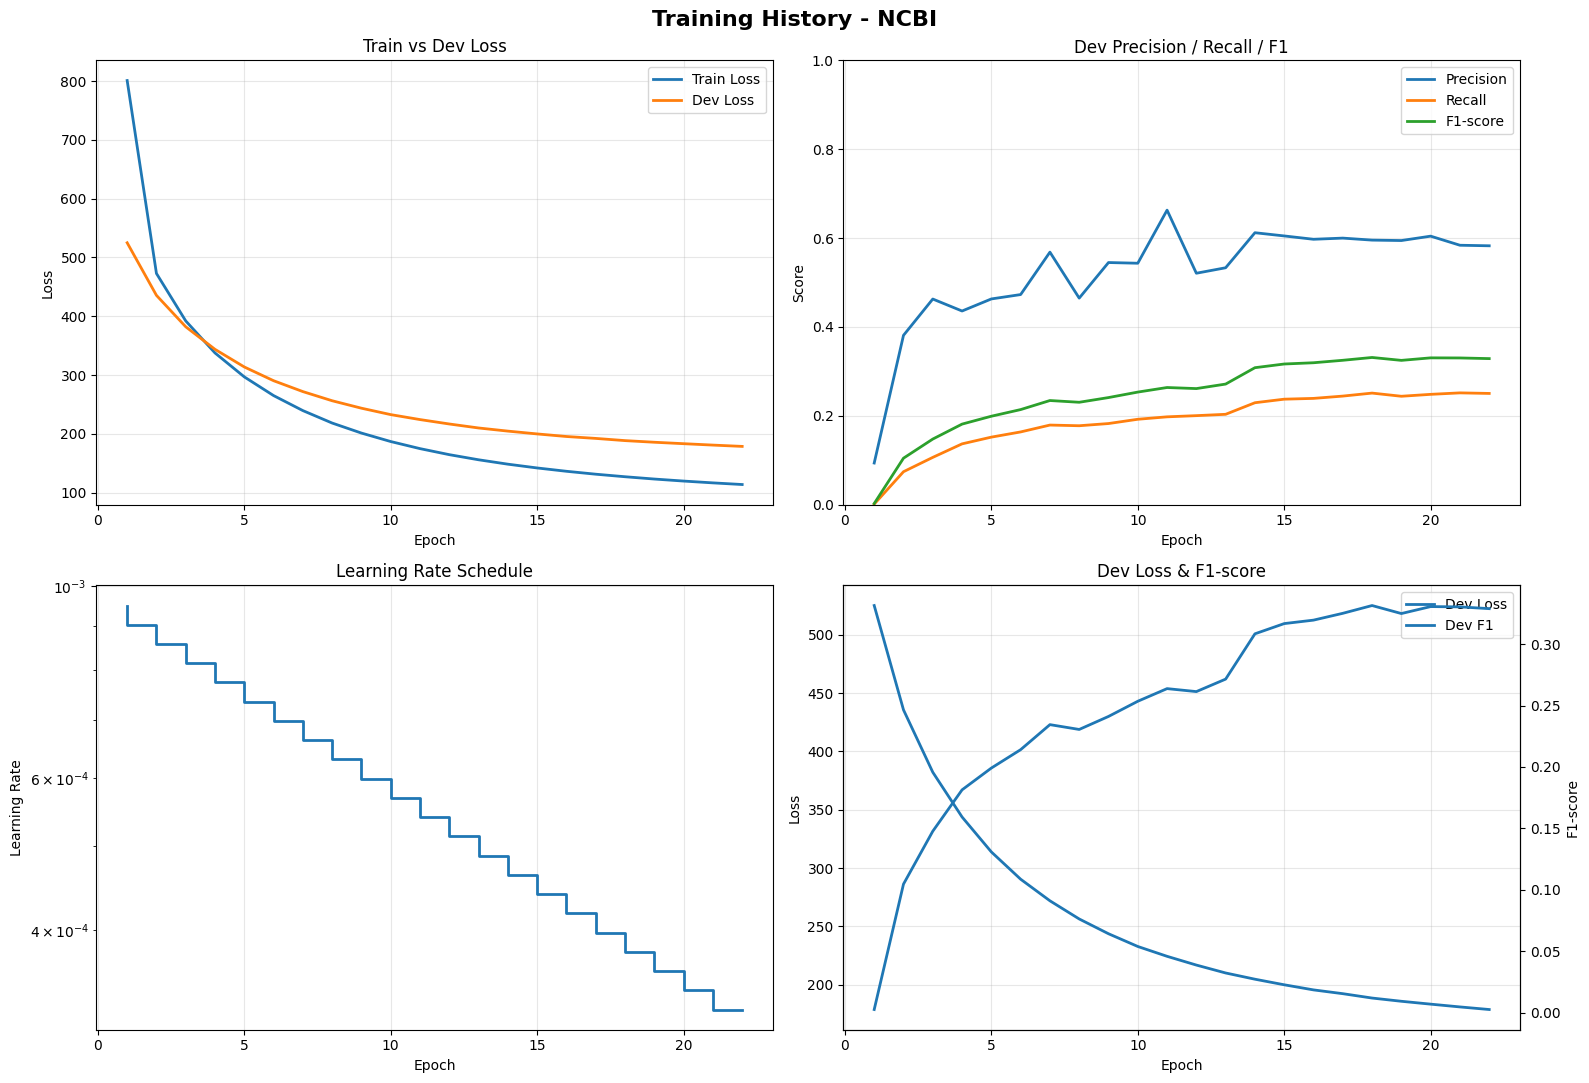


STATISTIQUES FINALES - NCBI
Meilleur F1 (dev)       : 0.3314
Meilleure Precision(dev): 0.6629
Meilleur Recall (dev)   : 0.2517
Final train loss        : 113.9677
Final dev loss          : 178.7880
Final learning rate     : 0.000324


In [15]:
plot_training_history(history_ncbi_we, dataset_name="NCBI")

In [44]:
def load_trained_model(model_path, dataset_name, loaders_dict,use_char_cnn=False,use_char_lstm=False,use_attention=False,use_fc_fusion=False):
    """
    Charge un modèle entraîné et le prépare pour les prédictions
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Récupérer les paramètres du loader
    vocab = loaders_dict['vocab']
    char_vocab = loaders_dict['char_vocab']
    tag_to_idx = loaders_dict['tag_to_idx']
    idx_to_tag = loaders_dict['idx_to_tag']
    
    # Déterminer les paramètres selon le dataset
    if dataset_name == 'JNLPBA':
        lstm_hidden = 256
    else:  # NCBI-Disease
        lstm_hidden = 128
    
    # Créer le modèle
    model = CombinatorialNER(
    vocab_size=len(vocab),
    char_vocab_size=len(char_vocab),
    tag_to_idx=tag_to_idx,
    dataset=dataset_name,
    use_char_cnn=use_char_cnn,       
    use_char_lstm=use_char_lstm,      
    use_attention=use_attention,     
    use_fc_fusion=use_fc_fusion,  
    pretrained_embeddings=None,  
    word_embed_dim=200,
    lstm_hidden_dim=lstm_hidden,
    dropout=0.5
).to(device)

    
    # Charger les poids sauvegardés
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Mode évaluation
    
    print(f"Modèle chargé depuis: {model_path}")
    print(f"Best F1 enregistré: {checkpoint.get('best_f1', 'N/A'):.4f}")
    print(f"Époque: {checkpoint.get('epoch', 'N/A')}")
    
    return model, device, idx_to_tag

def plot_confusion_matrix_by_class(predictions, targets, idx_to_tag, dataset_name, 
                                   normalize=True, figsize=(12, 10),title="Matrice de confusion"):
    """
    Affiche la matrice de confusion par classe avec des statistiques détaillées
    """
    # Vérification des types
    print(f"\nVérification des types:")
    print(f"  Type predictions[0]: {type(predictions[0])}, valeur: {predictions[0]}")
    print(f"  Type targets[0]: {type(targets[0])}, valeur: {targets[0]}")
    
    # S'assurer que tout est string
    predictions = [str(p) for p in predictions]
    targets = [str(t) for t in targets]
    
    # Filtrer les tags 'O' pour se concentrer sur les entités
    entity_predictions = []
    entity_targets = []
    
    for pred, target in zip(predictions, targets):
        if target != 'O':  
            entity_predictions.append(pred)
            entity_targets.append(target)
    
    print(f"\nStatistiques:")
    print(f"  Total tokens: {len(predictions)}")
    print(f"  Entity tokens: {len(entity_targets)}")
    print(f"  Unique entity tags in targets: {set(entity_targets)}")
    print(f"  Unique entity tags in predictions: {set(entity_predictions)}")
    
    # Obtenir les classes uniques (sauf 'O')
    all_unique_tags = sorted(set(entity_targets + entity_predictions))
    
    # Filtrer pour garder seulement les tags valides (pas les nombres)
    valid_tags = [tag for tag in all_unique_tags if not tag.isdigit()]
    
    # Si on a des tags numériques, c'est qu'il y a un problème de conversion
    numeric_tags = [tag for tag in all_unique_tags if tag.isdigit()]
    if numeric_tags:
        print(f"\nATTENTION: Tags numériques trouvés: {numeric_tags}")
        print("Cela indique que les prédictions sont des indices, pas des tags!")
        print(f"Mapping idx_to_tag: {dict(list(idx_to_tag.items())[:10])}")
    
    print(f"  Tags valides à plotter: {valid_tags}")
    
    if not valid_tags:
        print("Aucune entité valide trouvée dans les données!")
        return

    cm = confusion_matrix(entity_targets, entity_predictions, labels=valid_tags)
    supports = cm.sum(axis=1)  
    
    if normalize:
        # Éviter la division par zéro
        with np.errstate(divide='ignore', invalid='ignore'):
            cm_normalized = cm.astype('float') / supports[:, np.newaxis]
            cm_normalized = np.nan_to_num(cm_normalized, nan=0.0)
        cm_to_plot = cm_normalized
        fmt = '.2f'
        title_suffix = '(Normalisée)'
    else:
        cm_to_plot = cm
        fmt = 'd'
        title_suffix = '(Absolue)'
    
    # Créer la figure
    plt.figure(figsize=figsize)
    
    # Si la matrice est trop grande, ajuster la taille
    if len(valid_tags) > 15:
        figsize = (max(12, len(valid_tags)), max(10, len(valid_tags)))
        plt.figure(figsize=figsize)
    
    sns.heatmap(cm_to_plot, annot=True, fmt=fmt, cmap='Blues', 
                xticklabels=valid_tags, yticklabels=valid_tags,
                cbar_kws={'label': 'Proportion' if normalize else 'Count'})
    
    plt.title(title,fontsize=14, fontweight='bold')
    plt.xlabel('Prédictions', fontsize=12)
    plt.ylabel('Vraies labels', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    filtered_targets = []
    filtered_preds = []
    
    for t, p in zip(entity_targets, entity_predictions):
        if t in valid_tags and p in valid_tags:
            filtered_targets.append(t)
            filtered_preds.append(p)
    
    if filtered_targets:
        report = classification_report(filtered_targets, filtered_preds, 
                                       labels=valid_tags, zero_division=0)
        print(report)
    else:
        print("Pas assez de données pour générer le rapport")
    
    for i, tag in enumerate(valid_tags):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        support = supports[i]
        
        # Éviter les divisions par zéro
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        # Support est déjà un entier (sum de la ligne)
        print(f"{tag:20s}: Precision={precision:.3f}, Recall={recall:.3f}, "
              f"F1={f1:.3f}, Support={int(support)}")

def predict_on_test_set(model, test_loader, device, idx_to_tag):
    """
    Version simplifiée et robuste
    """
    shown_example = False
    model.eval()
    all_predictions = []
    all_targets = []
    for idx, tag in sorted(idx_to_tag.items()):
        print(f"  {idx} -> {tag}")
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            word_ids, char_seqs, tag_ids, lengths = batch
            
            word_ids = word_ids.to(device)
            char_seqs = char_seqs.to(device)
            tag_ids = tag_ids.to(device)
            mask = (word_ids != 0)
            pred_sequences = model(word_ids, char_seqs, mask, tags=None)
            
            for i in range(len(word_ids)):
                actual_len = lengths[i]
                if isinstance(pred_sequences, list):
                    pred_seq = pred_sequences[i][:actual_len]
                else:
                    pred_seq = torch.argmax(pred_sequences[i], dim=1)[:actual_len].cpu().numpy()
                
                # Convertir indices -> tags
                pred_tags = []
                for idx in pred_seq:
                    if isinstance(idx, torch.Tensor):
                        idx = idx.item()
                    tag = idx_to_tag.get(int(idx), 'O')
                    pred_tags.append(tag)
                
                # Convertir cibles indices -> tags
                target_indices = tag_ids[i][:actual_len].cpu().numpy()
                target_tags = [idx_to_tag.get(int(idx), 'O') for idx in target_indices]
                
                all_predictions.extend(pred_tags)
                all_targets.extend(target_tags)
                if not shown_example:
                    for pos, (g, p) in enumerate(zip(target_tags, pred_tags)):
                            mark = "correct" if g == p else "incorrect"
                            print(f"{pos:3d} | {g:18s} | {p:18s} {mark}")
                    shown_example=True
    
    return all_predictions, all_targets  


In [17]:
model_path = "./checkpoints/NCBI/we/WE/best_model.pt"
model, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='NCBI',
    loaders_dict=results_ncbi,
    use_char_cnn=False,use_char_lstm=False,use_attention=False,use_fc_fusion=False
)

# 3. Faire des prédictions avec la version corrigée
test_loader = results_ncbi['test_loader']
predictions, targets = predict_on_test_set(
    model=model,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)


# Statistiques
correct_count = sum(1 for p, t in zip(predictions[:50], targets[:50]) if p == t)
print(f"\nRésumé: {correct_count}/50 corrects ({correct_count/50:.1%})")

Modèle chargé depuis: ./checkpoints/NCBI/we/WE/best_model.pt
Best F1 enregistré: 0.3314
Époque: 17
  0 -> <PAD>
  1 -> B-CompositeMention
  2 -> B-DiseaseClass
  3 -> B-Modifier
  4 -> B-SpecificDisease
  5 -> I-CompositeMention
  6 -> I-DiseaseClass
  7 -> I-Modifier
  8 -> I-SpecificDisease
  9 -> O
  0 | I-SpecificDisease  | O                  incorrect
  1 | I-SpecificDisease  | O                  incorrect
  2 | I-SpecificDisease  | O                  incorrect
  3 | I-SpecificDisease  | O                  incorrect
  4 | I-SpecificDisease  | O                  incorrect
  5 | I-SpecificDisease  | O                  incorrect
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | O                  | O                  correct
  9 | B-Modifier         | B-Modifier         correct
 10 | I-Modifier         | I-Modifier         correct
 11 | I-Modifier         | I-Modifier         correct
 12 | I-Modifier         | I-Modifier

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_40232\604486152.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)



Résumé: 42/50 corrects (84.0%)



Accuracy globale: 0.8373

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: I-SpecificDisease

Statistiques:
  Total tokens: 24216
  Entity tokens: 5616
  Unique entity tags in targets: {'B-CompositeMention', 'B-Modifier', 'B-DiseaseClass', 'B-SpecificDisease', 'I-DiseaseClass', 'I-SpecificDisease', 'I-Modifier', 'I-CompositeMention'}
  Unique entity tags in predictions: {'B-CompositeMention', 'B-Modifier', 'B-DiseaseClass', 'B-SpecificDisease', 'O', 'I-DiseaseClass', 'I-SpecificDisease', 'I-Modifier', 'I-CompositeMention'}
  Tags valides à plotter: ['B-CompositeMention', 'B-DiseaseClass', 'B-Modifier', 'B-SpecificDisease', 'I-CompositeMention', 'I-DiseaseClass', 'I-Modifier', 'I-SpecificDisease', 'O']


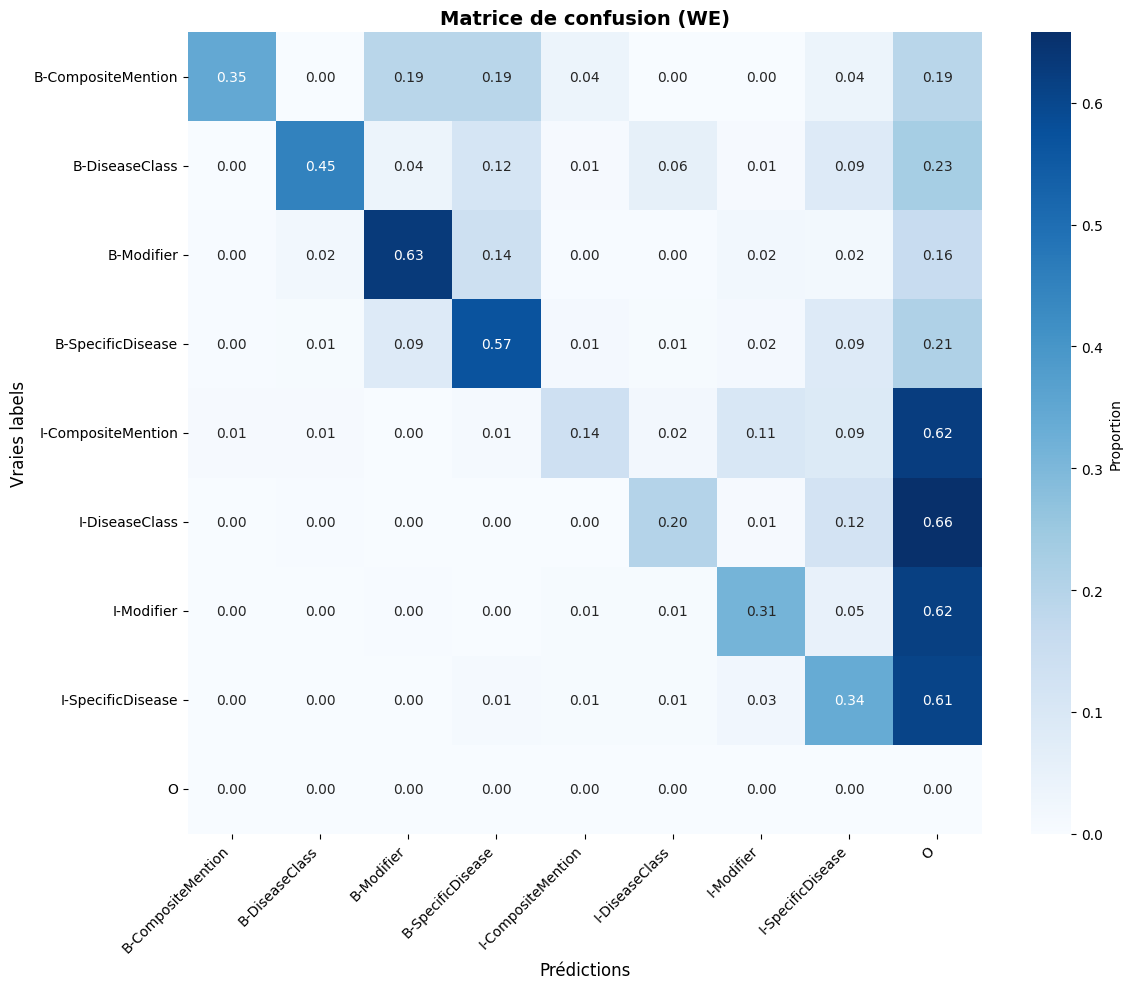

                    precision    recall  f1-score   support

B-CompositeMention       0.60      0.35      0.44        26
    B-DiseaseClass       0.72      0.45      0.56       104
        B-Modifier       0.71      0.63      0.67       235
 B-SpecificDisease       0.74      0.57      0.65       460
I-CompositeMention       0.52      0.14      0.22       257
    I-DiseaseClass       0.76      0.20      0.32       602
        I-Modifier       0.77      0.31      0.44      1242
 I-SpecificDisease       0.81      0.34      0.48      2690
                 O       0.00      0.00      0.00         0

          accuracy                           0.34      5616
         macro avg       0.63      0.33      0.42      5616
      weighted avg       0.77      0.34      0.46      5616

B-CompositeMention  : Precision=0.600, Recall=0.346, F1=0.439, Support=26
B-DiseaseClass      : Precision=0.723, Recall=0.452, F1=0.556, Support=104
B-Modifier          : Precision=0.708, Recall=0.630, F1=0.667, Suppo

In [18]:
from sklearn.metrics import accuracy_score, classification_report

# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets, predictions)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions, targets) if t != 'O']
entity_targets = [t for p, t in zip(predictions, targets) if t != 'O']

if set(predictions) == set(targets) or all(isinstance(p, str) for p in predictions):
    plot_confusion_matrix_by_class(
        predictions=predictions,
        targets=targets,
        idx_to_tag=idx_to_tag,
        dataset_name='NCBI (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE)"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets[:10])}")

## Combinaison 2 : WE + attention

In [19]:
model_ncbi_we_attention, history_ncbi_we_attention = run_pipeline(
    dataset_name='NCBI',
    loaders=results_ncbi,
    use_char_cnn=False,
    use_char_lstm=False,
    use_attention=True,
    use_fc_fusion=False,
    embedding_url=None,  
    lstm_hidden_dim=128,
    epochs=40,
    patience=8,
    checkpoints_dir="./checkpoints/NCBI/WE_attention"
)


Model parameters: 1,324,010


Training: 100%|██████████| 165/165 [00:53<00:00,  3.09it/s]


Epoch 01/40 | Train loss: 623.9316 | Dev loss: 434.7478 | P: 0.1276 R: 0.0548 F1: 0.0581 | LR: 0.000950
Meilleur modèle sauvegardé: F1 0.0581


Training: 100%|██████████| 165/165 [01:11<00:00,  2.31it/s]


Epoch 02/40 | Train loss: 354.1408 | Dev loss: 318.4378 | P: 0.2475 R: 0.1966 F1: 0.2185 | LR: 0.000902
Meilleur modèle sauvegardé: F1 0.2185


Training: 100%|██████████| 165/165 [01:27<00:00,  1.89it/s]


Epoch 03/40 | Train loss: 249.8899 | Dev loss: 274.0068 | P: 0.5040 R: 0.2639 F1: 0.3019 | LR: 0.000857
Meilleur modèle sauvegardé: F1 0.3019


Training: 100%|██████████| 165/165 [01:28<00:00,  1.86it/s]


Epoch 04/40 | Train loss: 196.6967 | Dev loss: 251.7470 | P: 0.4754 R: 0.3269 F1: 0.3775 | LR: 0.000815
Meilleur modèle sauvegardé: F1 0.3775


Training: 100%|██████████| 165/165 [01:29<00:00,  1.84it/s]


Epoch 05/40 | Train loss: 160.7093 | Dev loss: 256.3553 | P: 0.6104 R: 0.3350 F1: 0.3923 | LR: 0.000774
Meilleur modèle sauvegardé: F1 0.3923


Training: 100%|██████████| 165/165 [01:15<00:00,  2.18it/s]


Epoch 06/40 | Train loss: 135.5120 | Dev loss: 243.5249 | P: 0.6350 R: 0.3504 F1: 0.4097 | LR: 0.000735
Meilleur modèle sauvegardé: F1 0.4097


Training: 100%|██████████| 165/165 [00:52<00:00,  3.13it/s]


Epoch 07/40 | Train loss: 116.1638 | Dev loss: 237.4423 | P: 0.5560 R: 0.3792 F1: 0.4417 | LR: 0.000698
Meilleur modèle sauvegardé: F1 0.4417


Training: 100%|██████████| 165/165 [00:52<00:00,  3.13it/s]


Epoch 08/40 | Train loss: 101.1252 | Dev loss: 250.6221 | P: 0.5732 R: 0.3768 F1: 0.4376 | LR: 0.000663


Training: 100%|██████████| 165/165 [00:52<00:00,  3.12it/s]


Epoch 09/40 | Train loss: 87.7754 | Dev loss: 251.4876 | P: 0.6658 R: 0.3713 F1: 0.4313 | LR: 0.000630


Training: 100%|██████████| 165/165 [00:53<00:00,  3.09it/s]


Epoch 10/40 | Train loss: 78.0665 | Dev loss: 252.4454 | P: 0.6277 R: 0.3860 F1: 0.4349 | LR: 0.000599


Training: 100%|██████████| 165/165 [00:53<00:00,  3.11it/s]


Epoch 11/40 | Train loss: 68.2188 | Dev loss: 265.5903 | P: 0.6067 R: 0.3869 F1: 0.4514 | LR: 0.000569
Meilleur modèle sauvegardé: F1 0.4514


Training: 100%|██████████| 165/165 [00:53<00:00,  3.07it/s]


Epoch 12/40 | Train loss: 58.6443 | Dev loss: 275.3935 | P: 0.5913 R: 0.4453 F1: 0.4988 | LR: 0.000540
Meilleur modèle sauvegardé: F1 0.4988


Training: 100%|██████████| 165/165 [00:53<00:00,  3.11it/s]


Epoch 13/40 | Train loss: 51.6985 | Dev loss: 282.3759 | P: 0.5984 R: 0.4227 F1: 0.4822 | LR: 0.000513


Training: 100%|██████████| 165/165 [01:15<00:00,  2.19it/s]


Epoch 14/40 | Train loss: 45.5970 | Dev loss: 301.0387 | P: 0.6029 R: 0.4098 F1: 0.4653 | LR: 0.000488


Training: 100%|██████████| 165/165 [01:29<00:00,  1.84it/s]


Epoch 15/40 | Train loss: 40.1261 | Dev loss: 312.7357 | P: 0.6297 R: 0.3867 F1: 0.4482 | LR: 0.000463


Training: 100%|██████████| 165/165 [01:29<00:00,  1.84it/s]


Epoch 16/40 | Train loss: 36.3372 | Dev loss: 317.6210 | P: 0.5935 R: 0.4082 F1: 0.4577 | LR: 0.000440


Training: 100%|██████████| 165/165 [01:29<00:00,  1.84it/s]


Epoch 17/40 | Train loss: 32.7507 | Dev loss: 333.2287 | P: 0.6191 R: 0.3893 F1: 0.4497 | LR: 0.000418


Training: 100%|██████████| 165/165 [01:27<00:00,  1.88it/s]


Epoch 18/40 | Train loss: 29.2552 | Dev loss: 362.9623 | P: 0.6419 R: 0.3733 F1: 0.4313 | LR: 0.000397


Training: 100%|██████████| 165/165 [00:53<00:00,  3.10it/s]


Epoch 19/40 | Train loss: 26.8873 | Dev loss: 354.2223 | P: 0.5844 R: 0.4002 F1: 0.4532 | LR: 0.000377


Training: 100%|██████████| 165/165 [00:52<00:00,  3.14it/s]


Epoch 20/40 | Train loss: 24.2143 | Dev loss: 371.7046 | P: 0.6010 R: 0.4067 F1: 0.4666 | LR: 0.000358
Early stopping triggered après 20 epochs.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_40232\3419951289.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoints_path)



RÉSULTATS FINAUX SUR LE TEST SET
Loss: 238.1696
Precision: 0.5400
Recall: 0.5207
F1-score: 0.5273


In [45]:
print_model_layers(model_ncbi_we_attention)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    1,185,000
context_lstm (LSTM)            |      136,192
attention_layer.W (Linear)     |          128
emission (Linear)              |        2,570
crf (CRF)                      |          120
---------------------------------------------
Total parameters               |    1,324,010


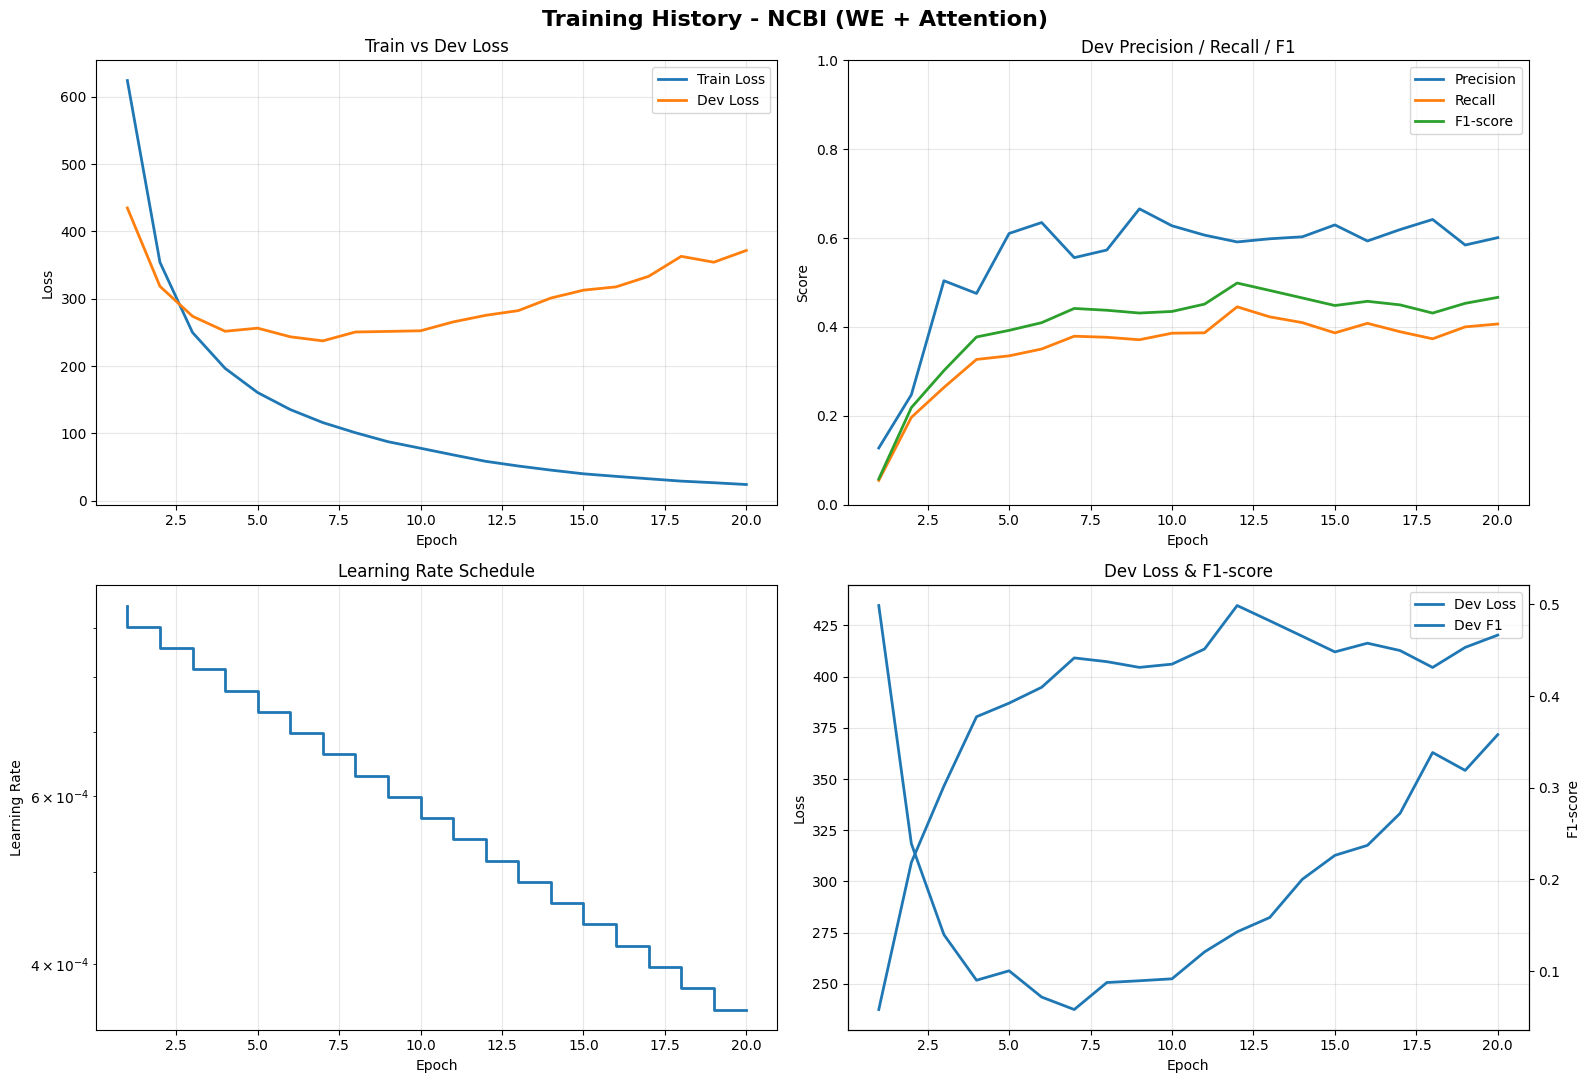


STATISTIQUES FINALES - NCBI (WE + Attention)
Meilleur F1 (dev)       : 0.4988
Meilleure Precision(dev): 0.6658
Meilleur Recall (dev)   : 0.4453
Final train loss        : 24.2143
Final dev loss          : 371.7046
Final learning rate     : 0.000358


In [20]:
plot_training_history(history_ncbi_we_attention, dataset_name="NCBI (WE + Attention)")

In [86]:
model_path = "./checkpoints/NCBI/WE_attention/WE_attention/best_model.pt"
model_ncbi_we_attention, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='NCBI',
    loaders_dict=results_ncbi,
    use_char_cnn=False,use_char_lstm=False,use_attention=True,use_fc_fusion=False
)

# 3. Faire des prédictions avec la version corrigée
test_loader = results_ncbi['test_loader']
predictions_ncbi_we_attention, targets_ncbi_we_attention = predict_on_test_set(
    model=model_ncbi_we_attention,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)
# Statistiques
correct_count = sum(1 for p, t in zip(predictions_ncbi_we_attention[:50], targets_ncbi_we_attention[:50]) if p == t)
print(f"\nRésumé: {correct_count}/50 corrects ({correct_count/50:.1%})")


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_40232\4030328369.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Modèle chargé depuis: ./checkpoints/NCBI/WE_attention/WE_attention/best_model.pt
Best F1 enregistré: 0.4988
Époque: 11
  0 -> <PAD>
  1 -> B-CompositeMention
  2 -> B-DiseaseClass
  3 -> B-Modifier
  4 -> B-SpecificDisease
  5 -> I-CompositeMention
  6 -> I-DiseaseClass
  7 -> I-Modifier
  8 -> I-SpecificDisease
  9 -> O
  0 | I-SpecificDisease  | O                  incorrect
  1 | I-SpecificDisease  | O                  incorrect
  2 | I-SpecificDisease  | O                  incorrect
  3 | I-SpecificDisease  | O                  incorrect
  4 | I-SpecificDisease  | O                  incorrect
  5 | I-SpecificDisease  | O                  incorrect
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | O                  | O                  correct
  9 | B-Modifier         | B-Modifier         correct
 10 | I-Modifier         | I-Modifier         correct
 11 | I-Modifier         | I-Modifier         correct
 12 | I-Modifier 


Accuracy globale: 0.8601

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: I-SpecificDisease

Statistiques:
  Total tokens: 24216
  Entity tokens: 5616
  Unique entity tags in targets: {'B-CompositeMention', 'B-Modifier', 'B-DiseaseClass', 'B-SpecificDisease', 'I-DiseaseClass', 'I-SpecificDisease', 'I-Modifier', 'I-CompositeMention'}
  Unique entity tags in predictions: {'B-CompositeMention', 'B-Modifier', 'B-DiseaseClass', 'B-SpecificDisease', 'O', 'I-DiseaseClass', 'I-SpecificDisease', 'I-Modifier', 'I-CompositeMention'}
  Tags valides à plotter: ['B-CompositeMention', 'B-DiseaseClass', 'B-Modifier', 'B-SpecificDisease', 'I-CompositeMention', 'I-DiseaseClass', 'I-Modifier', 'I-SpecificDisease', 'O']


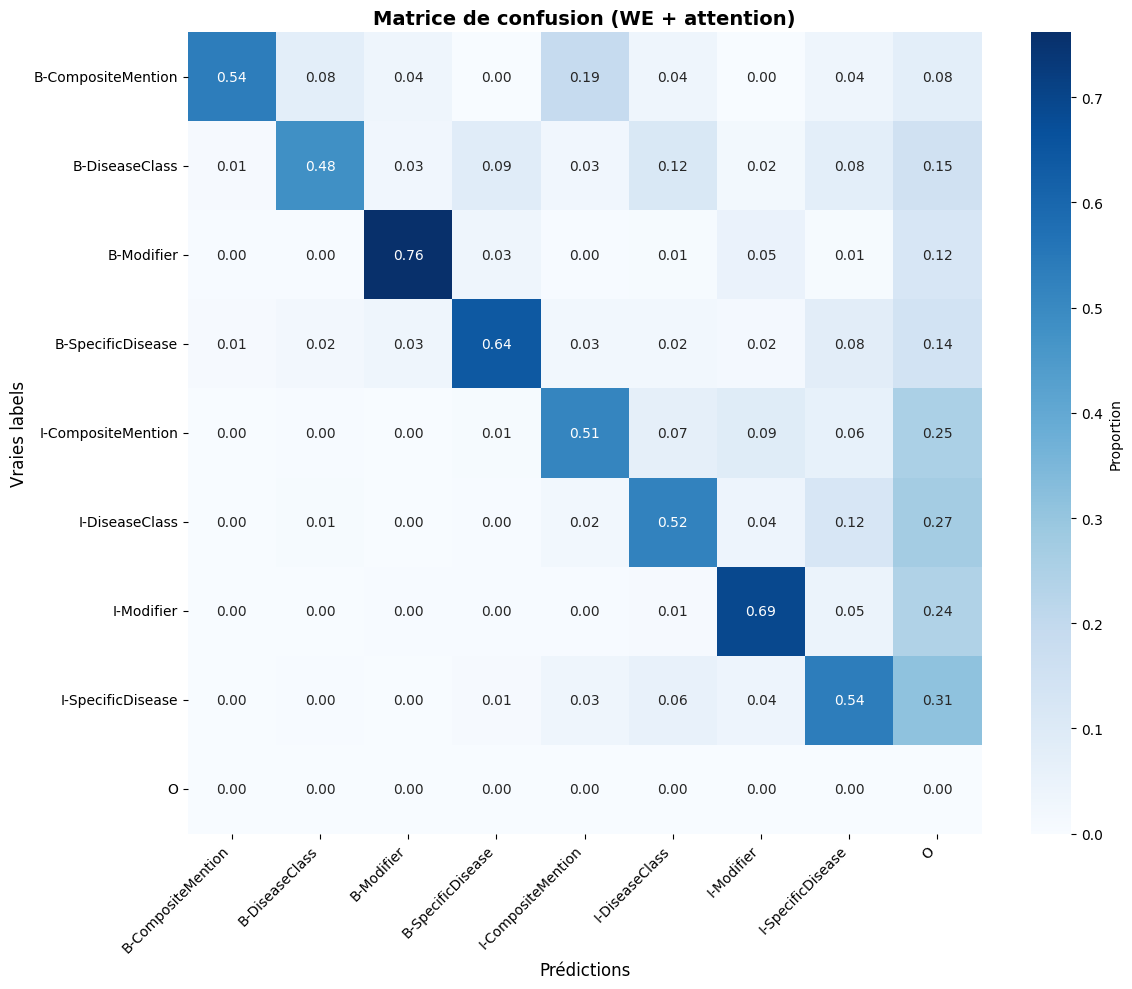

                    precision    recall  f1-score   support

B-CompositeMention       0.61      0.54      0.57        26
    B-DiseaseClass       0.64      0.48      0.55       104
        B-Modifier       0.86      0.76      0.81       235
 B-SpecificDisease       0.85      0.64      0.73       460
I-CompositeMention       0.49      0.51      0.50       257
    I-DiseaseClass       0.60      0.52      0.56       602
        I-Modifier       0.83      0.69      0.75      1242
 I-SpecificDisease       0.88      0.54      0.67      2690
                 O       0.00      0.00      0.00         0

          accuracy                           0.59      5616
         macro avg       0.64      0.52      0.57      5616
      weighted avg       0.81      0.59      0.68      5616

B-CompositeMention  : Precision=0.609, Recall=0.538, F1=0.571, Support=26
B-DiseaseClass      : Precision=0.641, Recall=0.481, F1=0.549, Support=104
B-Modifier          : Precision=0.861, Recall=0.762, F1=0.808, Suppo

In [22]:
from sklearn.metrics import accuracy_score, classification_report

# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_ncbi_we_attention, predictions_ncbi_we_attention)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions_ncbi_we_attention, targets_ncbi_we_attention) if t != 'O']
entity_targets = [t for p, t in zip(predictions_ncbi_we_attention, targets_ncbi_we_attention) if t != 'O']


if set(predictions_ncbi_we_attention) == set(targets_ncbi_we_attention) or all(isinstance(p, str) for p in predictions_ncbi_we_attention):
    plot_confusion_matrix_by_class(
        predictions=predictions_ncbi_we_attention,
        targets=targets_ncbi_we_attention,
        idx_to_tag=idx_to_tag,
        dataset_name='NCBI (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + attention)"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_ncbi_we_attention[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_ncbi_we_attention[:10])}")

## Combinaison 3 :  WE + char(bi-lstm)

In [23]:
model_we_char_bilstm , history_we_char_bilstm = run_pipeline(
    dataset_name='NCBI',
    loaders=results_ncbi,
    use_char_cnn=False,
    use_char_lstm=True,
    use_attention=False,
    use_fc_fusion=False,
    embedding_url=None,  
    lstm_hidden_dim=128,
    epochs=40,
    patience=8,
    checkpoints_dir="./checkpoints/NCBI"
)


Model parameters: 1,418,902


Training: 100%|██████████| 165/165 [00:41<00:00,  3.98it/s]


Epoch 01/40 | Train loss: 578.2393 | Dev loss: 408.5797 | P: 0.1111 R: 0.0563 F1: 0.0684 | LR: 0.000950
Meilleur modèle sauvegardé: F1 0.0684


Training: 100%|██████████| 165/165 [00:41<00:00,  3.99it/s]


Epoch 02/40 | Train loss: 314.2669 | Dev loss: 280.2223 | P: 0.4244 R: 0.2559 F1: 0.2957 | LR: 0.000902
Meilleur modèle sauvegardé: F1 0.2957


Training: 100%|██████████| 165/165 [00:42<00:00,  3.86it/s]


Epoch 03/40 | Train loss: 220.5131 | Dev loss: 237.5964 | P: 0.5279 R: 0.3533 F1: 0.3983 | LR: 0.000857
Meilleur modèle sauvegardé: F1 0.3983


Training: 100%|██████████| 165/165 [00:43<00:00,  3.78it/s]


Epoch 04/40 | Train loss: 171.4891 | Dev loss: 226.1784 | P: 0.5300 R: 0.3625 F1: 0.4127 | LR: 0.000815
Meilleur modèle sauvegardé: F1 0.4127


Training: 100%|██████████| 165/165 [00:43<00:00,  3.78it/s]


Epoch 05/40 | Train loss: 140.5723 | Dev loss: 218.8479 | P: 0.5374 R: 0.3791 F1: 0.4283 | LR: 0.000774
Meilleur modèle sauvegardé: F1 0.4283


Training: 100%|██████████| 165/165 [00:43<00:00,  3.78it/s]


Epoch 06/40 | Train loss: 118.1474 | Dev loss: 224.9554 | P: 0.6378 R: 0.4130 F1: 0.4794 | LR: 0.000735
Meilleur modèle sauvegardé: F1 0.4794


Training: 100%|██████████| 165/165 [00:43<00:00,  3.77it/s]


Epoch 07/40 | Train loss: 102.5671 | Dev loss: 215.6429 | P: 0.6584 R: 0.4425 F1: 0.5073 | LR: 0.000698
Meilleur modèle sauvegardé: F1 0.5073


Training: 100%|██████████| 165/165 [00:43<00:00,  3.78it/s]


Epoch 08/40 | Train loss: 86.7241 | Dev loss: 227.8990 | P: 0.6499 R: 0.4502 F1: 0.5238 | LR: 0.000663
Meilleur modèle sauvegardé: F1 0.5238


Training: 100%|██████████| 165/165 [00:43<00:00,  3.75it/s]


Epoch 09/40 | Train loss: 74.0951 | Dev loss: 232.4252 | P: 0.6199 R: 0.4443 F1: 0.5060 | LR: 0.000630


Training: 100%|██████████| 165/165 [00:43<00:00,  3.77it/s]


Epoch 10/40 | Train loss: 65.0278 | Dev loss: 252.7341 | P: 0.5978 R: 0.4069 F1: 0.4566 | LR: 0.000599


Training: 100%|██████████| 165/165 [00:43<00:00,  3.76it/s]


Epoch 11/40 | Train loss: 56.0313 | Dev loss: 252.8165 | P: 0.6278 R: 0.4058 F1: 0.4592 | LR: 0.000569


Training: 100%|██████████| 165/165 [00:43<00:00,  3.79it/s]


Epoch 12/40 | Train loss: 49.3741 | Dev loss: 255.8513 | P: 0.6290 R: 0.4841 F1: 0.5417 | LR: 0.000540
Meilleur modèle sauvegardé: F1 0.5417


Training: 100%|██████████| 165/165 [00:43<00:00,  3.79it/s]


Epoch 13/40 | Train loss: 43.8726 | Dev loss: 260.0297 | P: 0.5941 R: 0.4651 F1: 0.5119 | LR: 0.000513


Training: 100%|██████████| 165/165 [00:43<00:00,  3.77it/s]


Epoch 14/40 | Train loss: 38.9321 | Dev loss: 280.4269 | P: 0.5908 R: 0.4553 F1: 0.5078 | LR: 0.000488


Training: 100%|██████████| 165/165 [00:43<00:00,  3.76it/s]


Epoch 15/40 | Train loss: 34.7740 | Dev loss: 289.9190 | P: 0.5933 R: 0.4516 F1: 0.5029 | LR: 0.000463


Training: 100%|██████████| 165/165 [00:43<00:00,  3.79it/s]


Epoch 16/40 | Train loss: 31.7067 | Dev loss: 299.8500 | P: 0.5742 R: 0.4800 F1: 0.5186 | LR: 0.000440


Training: 100%|██████████| 165/165 [00:43<00:00,  3.77it/s]


Epoch 17/40 | Train loss: 28.2757 | Dev loss: 309.2989 | P: 0.5807 R: 0.4510 F1: 0.4989 | LR: 0.000418


Training: 100%|██████████| 165/165 [00:43<00:00,  3.75it/s]


Epoch 18/40 | Train loss: 25.8251 | Dev loss: 313.8665 | P: 0.5808 R: 0.4514 F1: 0.4968 | LR: 0.000397


Training: 100%|██████████| 165/165 [00:43<00:00,  3.76it/s]


Epoch 19/40 | Train loss: 23.5921 | Dev loss: 329.0594 | P: 0.5782 R: 0.4600 F1: 0.5023 | LR: 0.000377


Training: 100%|██████████| 165/165 [00:43<00:00,  3.78it/s]


Epoch 20/40 | Train loss: 21.7007 | Dev loss: 341.5614 | P: 0.5772 R: 0.4508 F1: 0.5001 | LR: 0.000358
Early stopping triggered après 20 epochs.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_40232\3419951289.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoints_path)



RÉSULTATS FINAUX SUR LE TEST SET
Loss: 228.0965
Precision: 0.5997
Recall: 0.5547
F1-score: 0.5742


In [46]:
print_model_layers(model_we_char_bilstm)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    1,185,000
char_lstm.char_embedding (Embedding) |        4,300
char_lstm.lstm (LSTM)          |       40,800
char_lstm.dropout (Dropout)    |            0
context_lstm (LSTM)            |      187,392
emission (Linear)              |        1,290
crf (CRF)                      |          120
---------------------------------------------
Total parameters               |    1,418,902


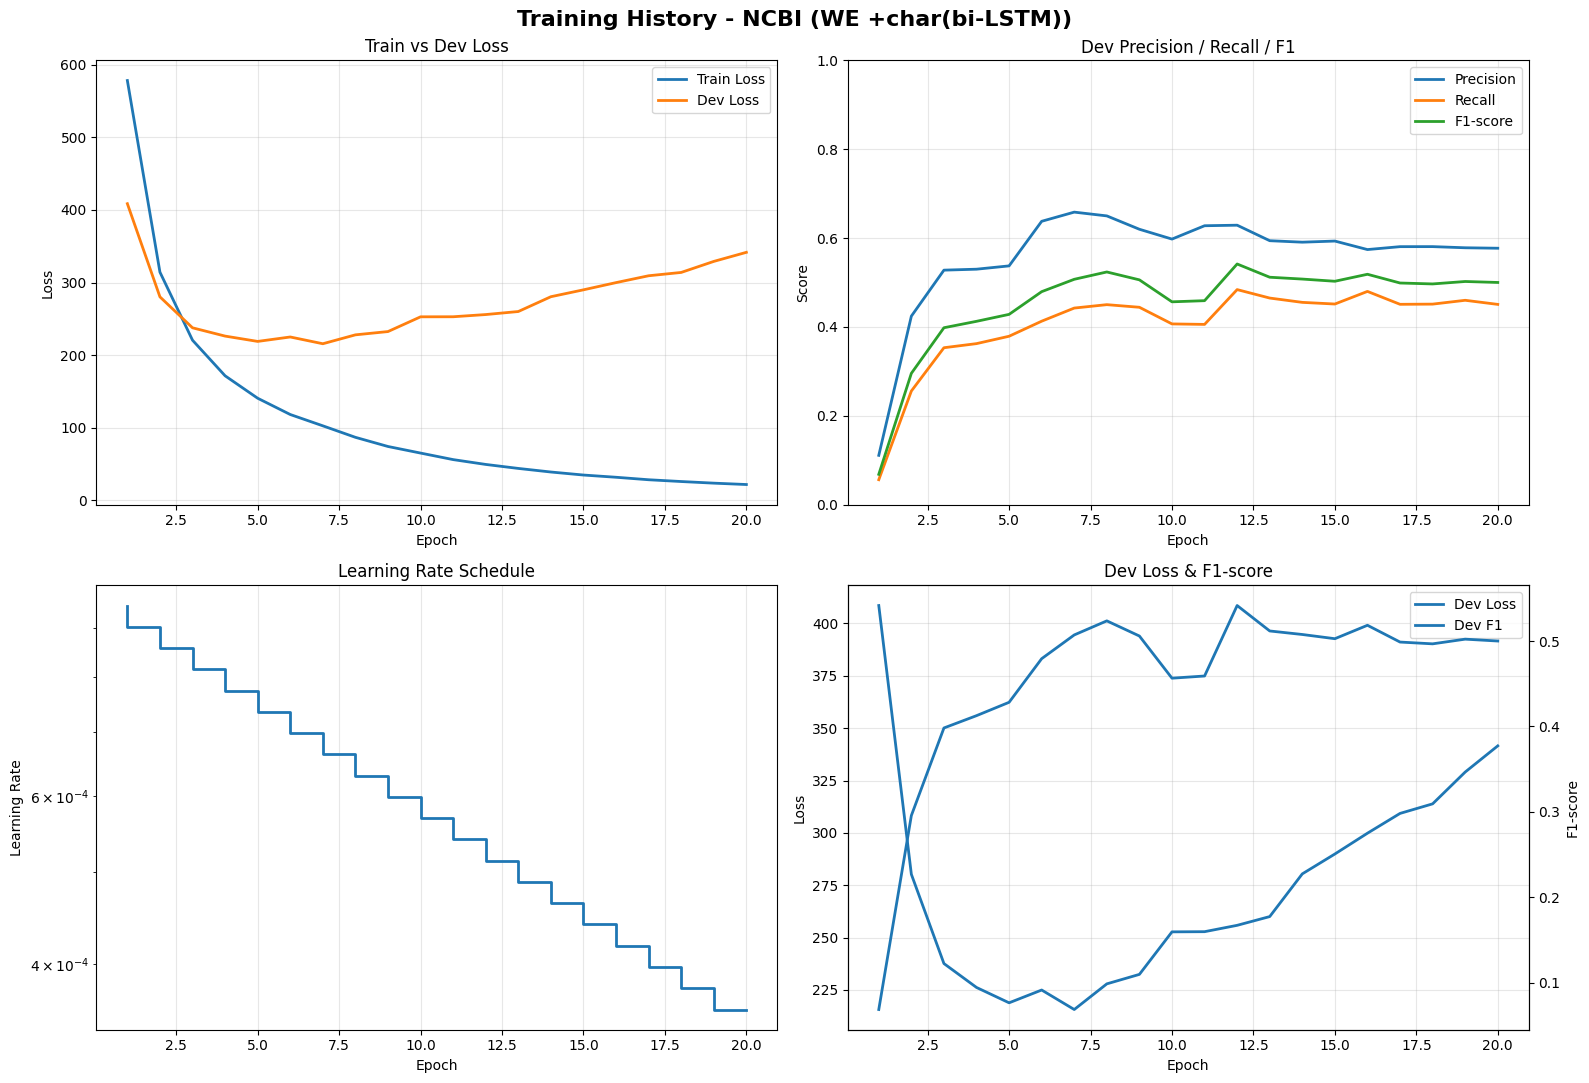


STATISTIQUES FINALES - NCBI (WE +char(bi-LSTM))
Meilleur F1 (dev)       : 0.5417
Meilleure Precision(dev): 0.6584
Meilleur Recall (dev)   : 0.4841
Final train loss        : 21.7007
Final dev loss          : 341.5614
Final learning rate     : 0.000358


In [24]:
plot_training_history(history_we_char_bilstm, dataset_name="NCBI (WE +char(bi-LSTM))")

In [85]:
model_path = "./checkpoints/NCBI/WE_char_bilstm/best_model.pt"
model_we_char_bilstm , device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='NCBI',
    loaders_dict=results_ncbi,
    use_char_cnn=False,use_char_lstm=True,use_attention=False,use_fc_fusion=False
)

test_loader = results_ncbi['test_loader']
predictions_we_char, targets_we_char = predict_on_test_set(
    model=model_we_char_bilstm ,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)
# Statistiques
correct_count = sum(1 for p, t in zip(predictions_we_char[:50], targets_we_char[:50]) if p == t)
print(f"\nRésumé: {correct_count}/50 corrects ({correct_count/50:.1%})")

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_40232\4030328369.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Modèle chargé depuis: ./checkpoints/NCBI/WE_char_bilstm/best_model.pt
Best F1 enregistré: 0.5417
Époque: 11
  0 -> <PAD>
  1 -> B-CompositeMention
  2 -> B-DiseaseClass
  3 -> B-Modifier
  4 -> B-SpecificDisease
  5 -> I-CompositeMention
  6 -> I-DiseaseClass
  7 -> I-Modifier
  8 -> I-SpecificDisease
  9 -> O
  0 | I-SpecificDisease  | O                  incorrect
  1 | I-SpecificDisease  | O                  incorrect
  2 | I-SpecificDisease  | O                  incorrect
  3 | I-SpecificDisease  | O                  incorrect
  4 | I-SpecificDisease  | O                  incorrect
  5 | I-SpecificDisease  | O                  incorrect
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | O                  | O                  correct
  9 | B-Modifier         | B-Modifier         correct
 10 | I-Modifier         | I-Modifier         correct
 11 | I-Modifier         | I-Modifier         correct
 12 | I-Modifier         | I


Accuracy globale: 0.8830

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: I-SpecificDisease

Statistiques:
  Total tokens: 24216
  Entity tokens: 5616
  Unique entity tags in targets: {'B-CompositeMention', 'B-Modifier', 'B-DiseaseClass', 'B-SpecificDisease', 'I-DiseaseClass', 'I-SpecificDisease', 'I-Modifier', 'I-CompositeMention'}
  Unique entity tags in predictions: {'B-CompositeMention', 'B-Modifier', 'B-DiseaseClass', 'B-SpecificDisease', 'O', 'I-DiseaseClass', 'I-SpecificDisease', 'I-Modifier', 'I-CompositeMention'}
  Tags valides à plotter: ['B-CompositeMention', 'B-DiseaseClass', 'B-Modifier', 'B-SpecificDisease', 'I-CompositeMention', 'I-DiseaseClass', 'I-Modifier', 'I-SpecificDisease', 'O']


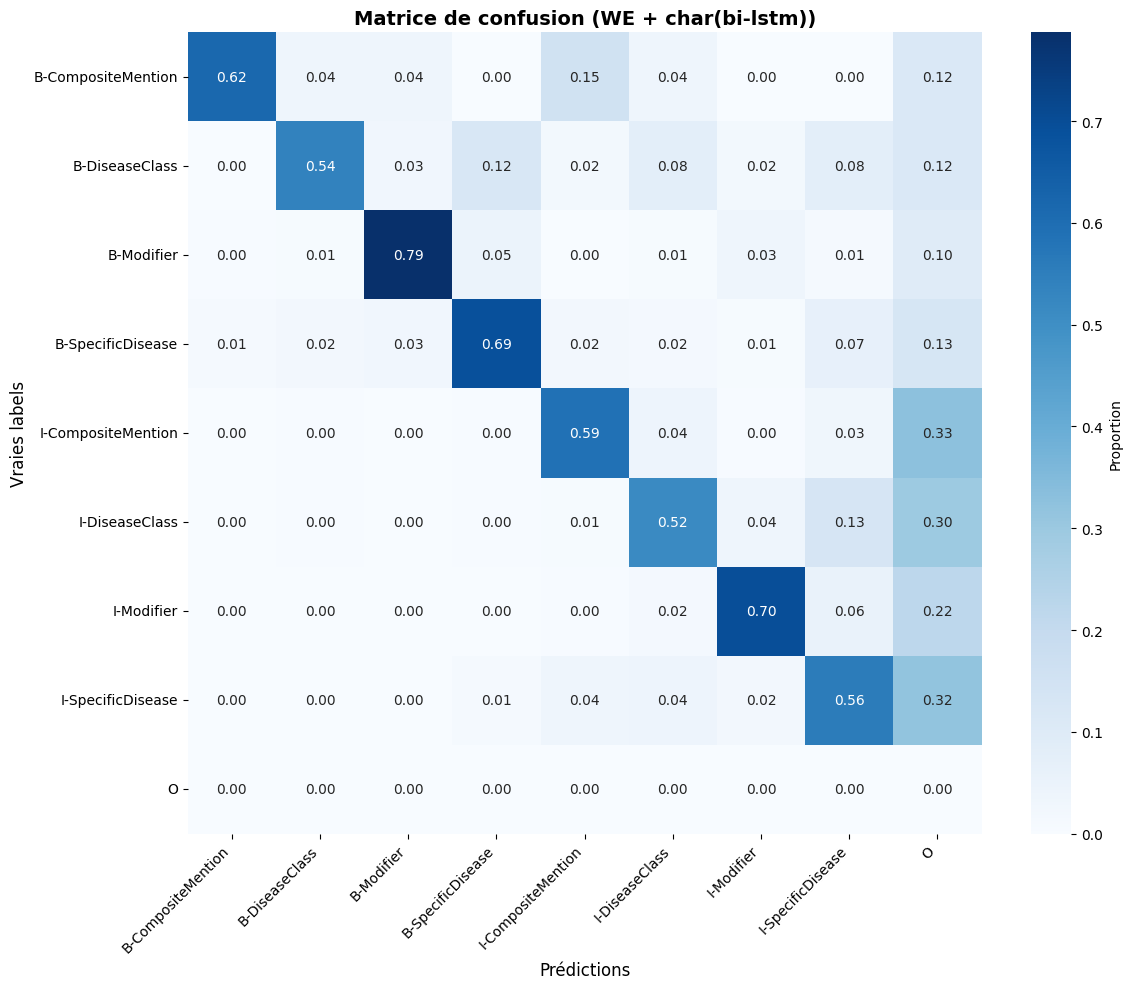

                    precision    recall  f1-score   support

B-CompositeMention       0.70      0.62      0.65        26
    B-DiseaseClass       0.69      0.54      0.61       104
        B-Modifier       0.90      0.79      0.84       235
 B-SpecificDisease       0.82      0.69      0.75       460
I-CompositeMention       0.54      0.59      0.56       257
    I-DiseaseClass       0.65      0.52      0.58       602
        I-Modifier       0.90      0.70      0.78      1242
 I-SpecificDisease       0.88      0.56      0.68      2690
                 O       0.00      0.00      0.00         0

          accuracy                           0.61      5616
         macro avg       0.68      0.55      0.61      5616
      weighted avg       0.84      0.61      0.70      5616

B-CompositeMention  : Precision=0.696, Recall=0.615, F1=0.653, Support=26
B-DiseaseClass      : Precision=0.691, Recall=0.538, F1=0.605, Support=104
B-Modifier          : Precision=0.902, Recall=0.787, F1=0.841, Suppo

In [26]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char, predictions_we_char)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions_we_char, targets_we_char) if t != 'O']
entity_targets = [t for p, t in zip(predictions_we_char, targets_we_char) if t != 'O']

if set(predictions_we_char) == set(targets_we_char) or all(isinstance(p, str) for p in predictions_we_char):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char,
        targets=targets_we_char,
        idx_to_tag=idx_to_tag,
        dataset_name='NCBI (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(bi-lstm))"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char[:10])}")

## Combinaison 4 : WE + char(bi-lstm) + attention

In [27]:
model_we_char_attention, history_we_char_attention = run_pipeline(
    dataset_name='NCBI',
    loaders=results_ncbi,
    use_char_cnn=False,
    use_char_lstm=True,
    use_attention=True,
    use_fc_fusion=False,
    embedding_url=None,  
    lstm_hidden_dim=128,
    epochs=40,
    patience=8,
    checkpoints_dir="./checkpoints/NCBI"
)


Model parameters: 1,420,310


Training: 100%|██████████| 165/165 [01:05<00:00,  2.53it/s]


Epoch 01/40 | Train loss: 582.8935 | Dev loss: 432.1998 | P: 0.1116 R: 0.0260 F1: 0.0357 | LR: 0.000950
Meilleur modèle sauvegardé: F1 0.0357


Training: 100%|██████████| 165/165 [01:04<00:00,  2.55it/s]


Epoch 02/40 | Train loss: 335.6588 | Dev loss: 298.9650 | P: 0.3516 R: 0.1662 F1: 0.1820 | LR: 0.000902
Meilleur modèle sauvegardé: F1 0.1820


Training: 100%|██████████| 165/165 [01:04<00:00,  2.54it/s]


Epoch 03/40 | Train loss: 233.4859 | Dev loss: 245.6225 | P: 0.4930 R: 0.3109 F1: 0.3599 | LR: 0.000857
Meilleur modèle sauvegardé: F1 0.3599


Training: 100%|██████████| 165/165 [01:04<00:00,  2.56it/s]


Epoch 04/40 | Train loss: 180.2420 | Dev loss: 222.4091 | P: 0.5026 R: 0.3407 F1: 0.3813 | LR: 0.000815
Meilleur modèle sauvegardé: F1 0.3813


Training: 100%|██████████| 165/165 [01:04<00:00,  2.55it/s]


Epoch 05/40 | Train loss: 148.4140 | Dev loss: 217.4913 | P: 0.5456 R: 0.3606 F1: 0.4137 | LR: 0.000774
Meilleur modèle sauvegardé: F1 0.4137


Training: 100%|██████████| 165/165 [01:04<00:00,  2.56it/s]


Epoch 06/40 | Train loss: 122.9545 | Dev loss: 204.4844 | P: 0.6656 R: 0.3884 F1: 0.4519 | LR: 0.000735
Meilleur modèle sauvegardé: F1 0.4519


Training: 100%|██████████| 165/165 [01:04<00:00,  2.55it/s]


Epoch 07/40 | Train loss: 104.1669 | Dev loss: 205.8801 | P: 0.6951 R: 0.3866 F1: 0.4401 | LR: 0.000698


Training: 100%|██████████| 165/165 [01:04<00:00,  2.57it/s]


Epoch 08/40 | Train loss: 90.2054 | Dev loss: 215.4477 | P: 0.6560 R: 0.4152 F1: 0.4808 | LR: 0.000663
Meilleur modèle sauvegardé: F1 0.4808


Training: 100%|██████████| 165/165 [01:05<00:00,  2.52it/s]


Epoch 09/40 | Train loss: 77.6497 | Dev loss: 219.3769 | P: 0.6311 R: 0.4189 F1: 0.4805 | LR: 0.000630


Training: 100%|██████████| 165/165 [01:04<00:00,  2.57it/s]


Epoch 10/40 | Train loss: 67.2845 | Dev loss: 226.5360 | P: 0.6669 R: 0.4134 F1: 0.4798 | LR: 0.000599


Training: 100%|██████████| 165/165 [01:04<00:00,  2.55it/s]


Epoch 11/40 | Train loss: 56.8818 | Dev loss: 234.1538 | P: 0.6153 R: 0.4507 F1: 0.5055 | LR: 0.000569
Meilleur modèle sauvegardé: F1 0.5055


Training: 100%|██████████| 165/165 [01:04<00:00,  2.55it/s]


Epoch 12/40 | Train loss: 51.2707 | Dev loss: 239.2872 | P: 0.6399 R: 0.4377 F1: 0.4848 | LR: 0.000540


Training: 100%|██████████| 165/165 [01:04<00:00,  2.54it/s]


Epoch 13/40 | Train loss: 44.3580 | Dev loss: 254.2513 | P: 0.6181 R: 0.4601 F1: 0.5084 | LR: 0.000513
Meilleur modèle sauvegardé: F1 0.5084


Training: 100%|██████████| 165/165 [01:04<00:00,  2.56it/s]


Epoch 14/40 | Train loss: 39.5071 | Dev loss: 265.4025 | P: 0.5858 R: 0.4587 F1: 0.5002 | LR: 0.000488


Training: 100%|██████████| 165/165 [01:04<00:00,  2.55it/s]


Epoch 15/40 | Train loss: 35.2758 | Dev loss: 292.0150 | P: 0.6443 R: 0.3970 F1: 0.4672 | LR: 0.000463


Training: 100%|██████████| 165/165 [01:04<00:00,  2.56it/s]


Epoch 16/40 | Train loss: 32.1844 | Dev loss: 283.6780 | P: 0.5846 R: 0.4521 F1: 0.5032 | LR: 0.000440


Training: 100%|██████████| 165/165 [01:04<00:00,  2.56it/s]


Epoch 17/40 | Train loss: 28.4816 | Dev loss: 287.7016 | P: 0.5872 R: 0.4528 F1: 0.4974 | LR: 0.000418


Training: 100%|██████████| 165/165 [01:05<00:00,  2.53it/s]


Epoch 18/40 | Train loss: 26.2485 | Dev loss: 297.0407 | P: 0.6054 R: 0.4663 F1: 0.5174 | LR: 0.000397
Meilleur modèle sauvegardé: F1 0.5174


Training: 100%|██████████| 165/165 [01:04<00:00,  2.56it/s]


Epoch 19/40 | Train loss: 23.9993 | Dev loss: 308.0764 | P: 0.5927 R: 0.4304 F1: 0.4774 | LR: 0.000377


Training: 100%|██████████| 165/165 [01:04<00:00,  2.56it/s]


Epoch 20/40 | Train loss: 21.9124 | Dev loss: 323.7640 | P: 0.6053 R: 0.4123 F1: 0.4706 | LR: 0.000358


Training: 100%|██████████| 165/165 [01:04<00:00,  2.56it/s]


Epoch 21/40 | Train loss: 20.0654 | Dev loss: 327.6661 | P: 0.5932 R: 0.4332 F1: 0.4795 | LR: 0.000341


Training: 100%|██████████| 165/165 [01:04<00:00,  2.55it/s]


Epoch 22/40 | Train loss: 19.1248 | Dev loss: 332.7554 | P: 0.5850 R: 0.4137 F1: 0.4608 | LR: 0.000324


Training: 100%|██████████| 165/165 [01:04<00:00,  2.56it/s]


Epoch 23/40 | Train loss: 17.6850 | Dev loss: 350.3581 | P: 0.5735 R: 0.4334 F1: 0.4789 | LR: 0.000307


Training: 100%|██████████| 165/165 [01:04<00:00,  2.57it/s]


Epoch 24/40 | Train loss: 16.2797 | Dev loss: 356.5291 | P: 0.5721 R: 0.4250 F1: 0.4735 | LR: 0.000292


Training: 100%|██████████| 165/165 [01:06<00:00,  2.49it/s]


Epoch 25/40 | Train loss: 15.6082 | Dev loss: 356.0296 | P: 0.5688 R: 0.4558 F1: 0.4921 | LR: 0.000277


Training: 100%|██████████| 165/165 [01:05<00:00,  2.50it/s]


Epoch 26/40 | Train loss: 14.9239 | Dev loss: 362.8904 | P: 0.5807 R: 0.4662 F1: 0.5110 | LR: 0.000264
Early stopping triggered après 26 epochs.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_40232\3419951289.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoints_path)



RÉSULTATS FINAUX SUR LE TEST SET
Loss: 271.5234
Precision: 0.5430
Recall: 0.5289
F1-score: 0.5349


In [47]:
print_model_layers(model_we_char_attention)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    1,185,000
char_lstm.char_embedding (Embedding) |        4,300
char_lstm.lstm (LSTM)          |       40,800
char_lstm.dropout (Dropout)    |            0
context_lstm (LSTM)            |      187,392
attention_layer.W (Linear)     |          128
emission (Linear)              |        2,570
crf (CRF)                      |          120
---------------------------------------------
Total parameters               |    1,420,310


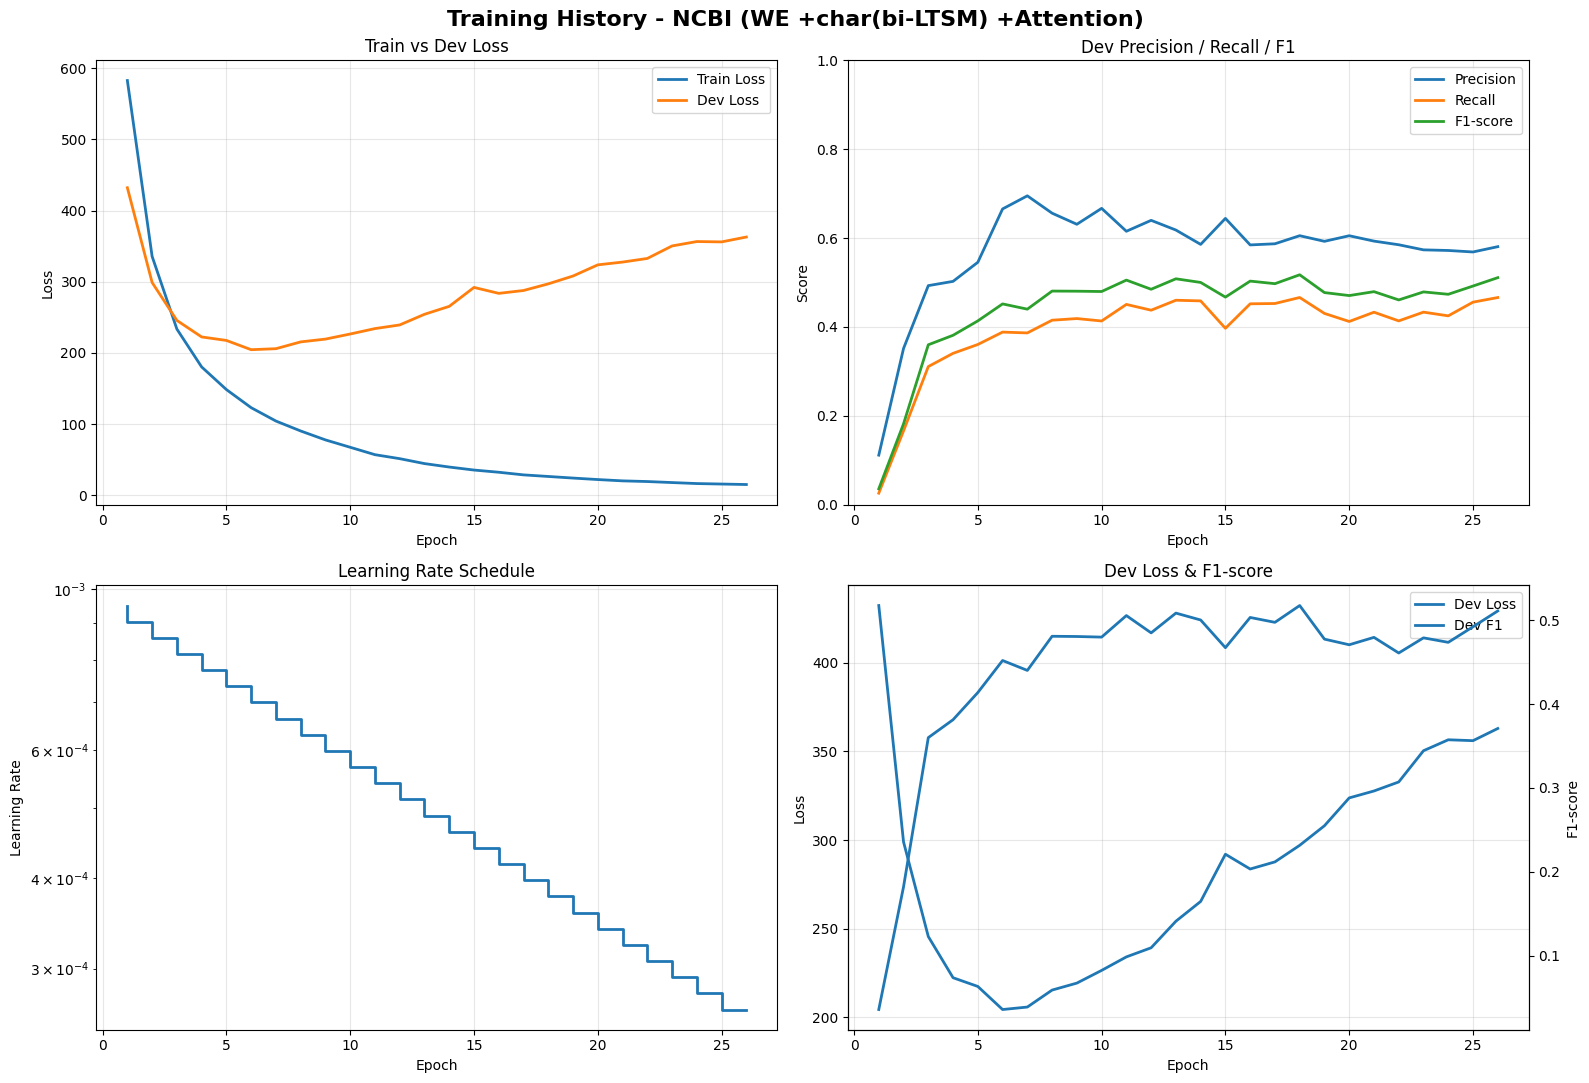


STATISTIQUES FINALES - NCBI (WE +char(bi-LTSM) +Attention)
Meilleur F1 (dev)       : 0.5174
Meilleure Precision(dev): 0.6951
Meilleur Recall (dev)   : 0.4663
Final train loss        : 14.9239
Final dev loss          : 362.8904
Final learning rate     : 0.000264


In [28]:
plot_training_history(history_we_char_attention, dataset_name="NCBI (WE +char(bi-LTSM) +Attention)")

In [84]:
model_path = "./checkpoints/NCBI/WE_char_bilstm_attention/best_model.pt"
model_we_char_attention, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='NCBI',
    loaders_dict=results_ncbi,
    use_char_cnn=False,use_char_lstm=True,use_attention=True,use_fc_fusion=False
)

# 3. Faire des prédictions avec la version corrigée
test_loader = results_ncbi['test_loader']
predictions_we_char_attention, targets_we_char_attention = predict_on_test_set(
    model=model_we_char_attention,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)
# Statistiques
correct_count = sum(1 for p, t in zip(predictions_we_char_attention[:50], targets_we_char_attention[:50]) if p == t)
print(f"\nRésumé: {correct_count}/50 corrects ({correct_count/50:.1%})")

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_40232\4030328369.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Modèle chargé depuis: ./checkpoints/NCBI/WE_char_bilstm_attention/best_model.pt
Best F1 enregistré: 0.5174
Époque: 17
  0 -> <PAD>
  1 -> B-CompositeMention
  2 -> B-DiseaseClass
  3 -> B-Modifier
  4 -> B-SpecificDisease
  5 -> I-CompositeMention
  6 -> I-DiseaseClass
  7 -> I-Modifier
  8 -> I-SpecificDisease
  9 -> O
  0 | I-SpecificDisease  | O                  incorrect
  1 | I-SpecificDisease  | O                  incorrect
  2 | I-SpecificDisease  | O                  incorrect
  3 | I-SpecificDisease  | O                  incorrect
  4 | I-SpecificDisease  | O                  incorrect
  5 | I-SpecificDisease  | O                  incorrect
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | O                  | O                  correct
  9 | B-Modifier         | B-Modifier         correct
 10 | I-Modifier         | I-Modifier         correct
 11 | I-Modifier         | I-Modifier         correct
 12 | I-Modifier  


Accuracy globale: 0.8672

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: I-SpecificDisease

Statistiques:
  Total tokens: 24216
  Entity tokens: 5616
  Unique entity tags in targets: {'B-CompositeMention', 'B-Modifier', 'B-DiseaseClass', 'B-SpecificDisease', 'I-DiseaseClass', 'I-SpecificDisease', 'I-Modifier', 'I-CompositeMention'}
  Unique entity tags in predictions: {'B-CompositeMention', 'B-Modifier', 'B-DiseaseClass', 'B-SpecificDisease', 'O', 'I-DiseaseClass', 'I-SpecificDisease', 'I-Modifier', 'I-CompositeMention'}
  Tags valides à plotter: ['B-CompositeMention', 'B-DiseaseClass', 'B-Modifier', 'B-SpecificDisease', 'I-CompositeMention', 'I-DiseaseClass', 'I-Modifier', 'I-SpecificDisease', 'O']


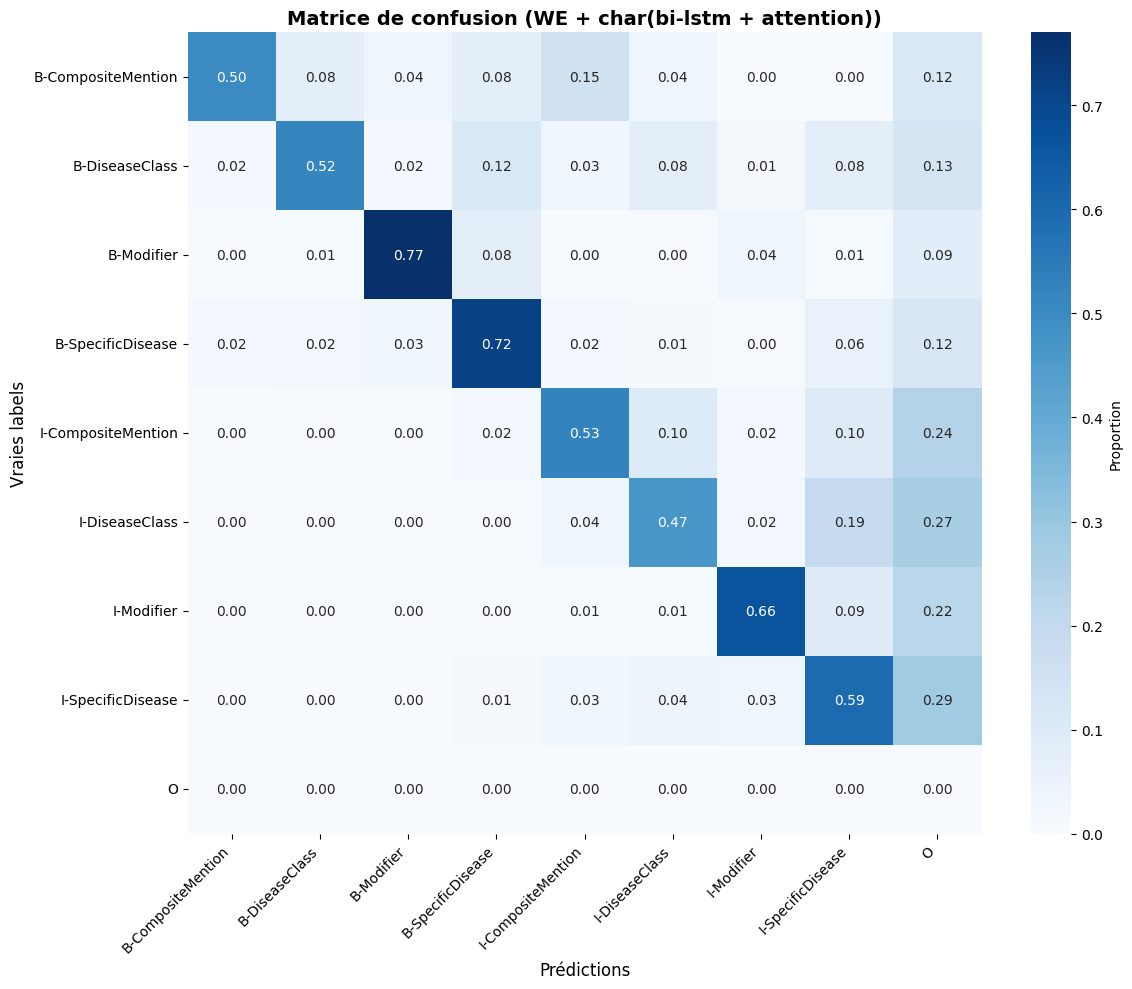

                    precision    recall  f1-score   support

B-CompositeMention       0.54      0.50      0.52        26
    B-DiseaseClass       0.71      0.52      0.60       104
        B-Modifier       0.89      0.77      0.82       235
 B-SpecificDisease       0.82      0.72      0.77       460
I-CompositeMention       0.50      0.53      0.51       257
    I-DiseaseClass       0.64      0.47      0.54       602
        I-Modifier       0.87      0.66      0.75      1242
 I-SpecificDisease       0.85      0.59      0.70      2690
                 O       0.00      0.00      0.00         0

          accuracy                           0.61      5616
         macro avg       0.65      0.53      0.58      5616
      weighted avg       0.81      0.61      0.69      5616

B-CompositeMention  : Precision=0.542, Recall=0.500, F1=0.520, Support=26
B-DiseaseClass      : Precision=0.711, Recall=0.519, F1=0.600, Support=104
B-Modifier          : Precision=0.887, Recall=0.770, F1=0.825, Suppo

In [30]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char_attention, predictions_we_char_attention)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions_we_char_attention, targets_we_char_attention) if t != 'O']
entity_targets = [t for p, t in zip(predictions_we_char_attention, targets_we_char_attention) if t != 'O']

if set(predictions_we_char_attention) == set(targets_we_char_attention) or all(isinstance(p, str) for p in predictions_we_char_attention):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char_attention,
        targets=targets_we_char_attention,
        idx_to_tag=idx_to_tag,
        dataset_name='NCBI (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(bi-lstm + attention))"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char_attention[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char_attention[:10])}")

## Combinaison 5: WE + char(cnn)

In [31]:
model_we_char_cnn, history_we_char_cnn = run_pipeline(
    dataset_name='NCBI',
    loaders=results_ncbi,
    use_char_cnn=True,
    use_char_lstm=False,
    use_attention=False,
    use_fc_fusion=False,
    embedding_url=None,  
    lstm_hidden_dim=128,
    epochs=40,
    patience=8,
    checkpoints_dir="./checkpoints/NCBI"
)


Model parameters: 1,390,550


Training: 100%|██████████| 165/165 [00:45<00:00,  3.63it/s]


Epoch 01/40 | Train loss: 580.0638 | Dev loss: 427.4037 | P: 0.1285 R: 0.0306 F1: 0.0414 | LR: 0.000950
Meilleur modèle sauvegardé: F1 0.0414


Training: 100%|██████████| 165/165 [00:44<00:00,  3.73it/s]


Epoch 02/40 | Train loss: 338.6654 | Dev loss: 292.5271 | P: 0.3395 R: 0.2142 F1: 0.2290 | LR: 0.000902
Meilleur modèle sauvegardé: F1 0.2290


Training: 100%|██████████| 165/165 [00:44<00:00,  3.70it/s]


Epoch 03/40 | Train loss: 235.6363 | Dev loss: 244.1241 | P: 0.4821 R: 0.2750 F1: 0.3072 | LR: 0.000857
Meilleur modèle sauvegardé: F1 0.3072


Training: 100%|██████████| 165/165 [00:44<00:00,  3.74it/s]


Epoch 04/40 | Train loss: 184.7374 | Dev loss: 220.1364 | P: 0.5416 R: 0.3581 F1: 0.4148 | LR: 0.000815
Meilleur modèle sauvegardé: F1 0.4148


Training: 100%|██████████| 165/165 [00:45<00:00,  3.64it/s]


Epoch 05/40 | Train loss: 152.8917 | Dev loss: 210.5067 | P: 0.5218 R: 0.3782 F1: 0.4139 | LR: 0.000774


Training: 100%|██████████| 165/165 [00:46<00:00,  3.58it/s]


Epoch 06/40 | Train loss: 130.2159 | Dev loss: 201.6492 | P: 0.5381 R: 0.3979 F1: 0.4406 | LR: 0.000735
Meilleur modèle sauvegardé: F1 0.4406


Training: 100%|██████████| 165/165 [00:46<00:00,  3.59it/s]


Epoch 07/40 | Train loss: 109.1440 | Dev loss: 197.4957 | P: 0.6351 R: 0.4390 F1: 0.4841 | LR: 0.000698
Meilleur modèle sauvegardé: F1 0.4841


Training: 100%|██████████| 165/165 [00:46<00:00,  3.58it/s]


Epoch 08/40 | Train loss: 96.5500 | Dev loss: 207.0966 | P: 0.6606 R: 0.4194 F1: 0.4725 | LR: 0.000663


Training: 100%|██████████| 165/165 [00:47<00:00,  3.49it/s]


Epoch 09/40 | Train loss: 83.1520 | Dev loss: 228.1999 | P: 0.6874 R: 0.4057 F1: 0.4824 | LR: 0.000630


Training: 100%|██████████| 165/165 [00:37<00:00,  4.35it/s]


Epoch 10/40 | Train loss: 73.6153 | Dev loss: 222.4355 | P: 0.6655 R: 0.4071 F1: 0.4577 | LR: 0.000599


Training: 100%|██████████| 165/165 [00:39<00:00,  4.20it/s]


Epoch 11/40 | Train loss: 64.1313 | Dev loss: 221.4397 | P: 0.6765 R: 0.4215 F1: 0.4850 | LR: 0.000569
Meilleur modèle sauvegardé: F1 0.4850


Training: 100%|██████████| 165/165 [00:38<00:00,  4.34it/s]


Epoch 12/40 | Train loss: 56.7984 | Dev loss: 225.4497 | P: 0.6244 R: 0.4580 F1: 0.5162 | LR: 0.000540
Meilleur modèle sauvegardé: F1 0.5162


Training: 100%|██████████| 165/165 [00:38<00:00,  4.34it/s]


Epoch 13/40 | Train loss: 49.9496 | Dev loss: 247.0635 | P: 0.6604 R: 0.4164 F1: 0.4847 | LR: 0.000513


Training: 100%|██████████| 165/165 [00:37<00:00,  4.35it/s]


Epoch 14/40 | Train loss: 45.2889 | Dev loss: 252.0048 | P: 0.6542 R: 0.4517 F1: 0.5181 | LR: 0.000488
Meilleur modèle sauvegardé: F1 0.5181


Training: 100%|██████████| 165/165 [00:42<00:00,  3.90it/s]


Epoch 15/40 | Train loss: 40.3425 | Dev loss: 252.7037 | P: 0.6206 R: 0.4675 F1: 0.5172 | LR: 0.000463


Training: 100%|██████████| 165/165 [00:46<00:00,  3.57it/s]


Epoch 16/40 | Train loss: 36.3272 | Dev loss: 271.8818 | P: 0.6365 R: 0.4476 F1: 0.5125 | LR: 0.000440


Training: 100%|██████████| 165/165 [00:46<00:00,  3.58it/s]


Epoch 17/40 | Train loss: 32.9514 | Dev loss: 277.6452 | P: 0.5987 R: 0.4566 F1: 0.5022 | LR: 0.000418


Training: 100%|██████████| 165/165 [00:45<00:00,  3.67it/s]


Epoch 18/40 | Train loss: 29.9284 | Dev loss: 283.8018 | P: 0.5777 R: 0.4616 F1: 0.5043 | LR: 0.000397


Training: 100%|██████████| 165/165 [00:44<00:00,  3.70it/s]


Epoch 19/40 | Train loss: 27.4815 | Dev loss: 297.7888 | P: 0.6182 R: 0.4416 F1: 0.4996 | LR: 0.000377


Training: 100%|██████████| 165/165 [00:45<00:00,  3.65it/s]


Epoch 20/40 | Train loss: 25.4650 | Dev loss: 302.1170 | P: 0.6189 R: 0.4259 F1: 0.4829 | LR: 0.000358


Training: 100%|██████████| 165/165 [00:44<00:00,  3.68it/s]


Epoch 21/40 | Train loss: 24.0255 | Dev loss: 309.5101 | P: 0.6062 R: 0.4360 F1: 0.4960 | LR: 0.000341


Training: 100%|██████████| 165/165 [00:46<00:00,  3.55it/s]


Epoch 22/40 | Train loss: 21.8789 | Dev loss: 313.3600 | P: 0.5358 R: 0.4828 F1: 0.5073 | LR: 0.000324
Early stopping triggered après 22 epochs.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_40232\3419951289.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoints_path)



RÉSULTATS FINAUX SUR LE TEST SET
Loss: 225.2260
Precision: 0.6048
Recall: 0.5236
F1-score: 0.5596


In [48]:
print_model_layers(model_we_char_cnn)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    1,185,000
char_cnn.char_embedding (Embedding) |        4,300
char_cnn.convs.0 (Conv1d)      |        3,232
char_cnn.convs.1 (Conv1d)      |        4,832
char_cnn.convs.2 (Conv1d)      |        6,432
char_cnn.dropout (Dropout)     |            0
context_lstm (LSTM)            |      185,344
emission (Linear)              |        1,290
crf (CRF)                      |          120
---------------------------------------------
Total parameters               |    1,390,550


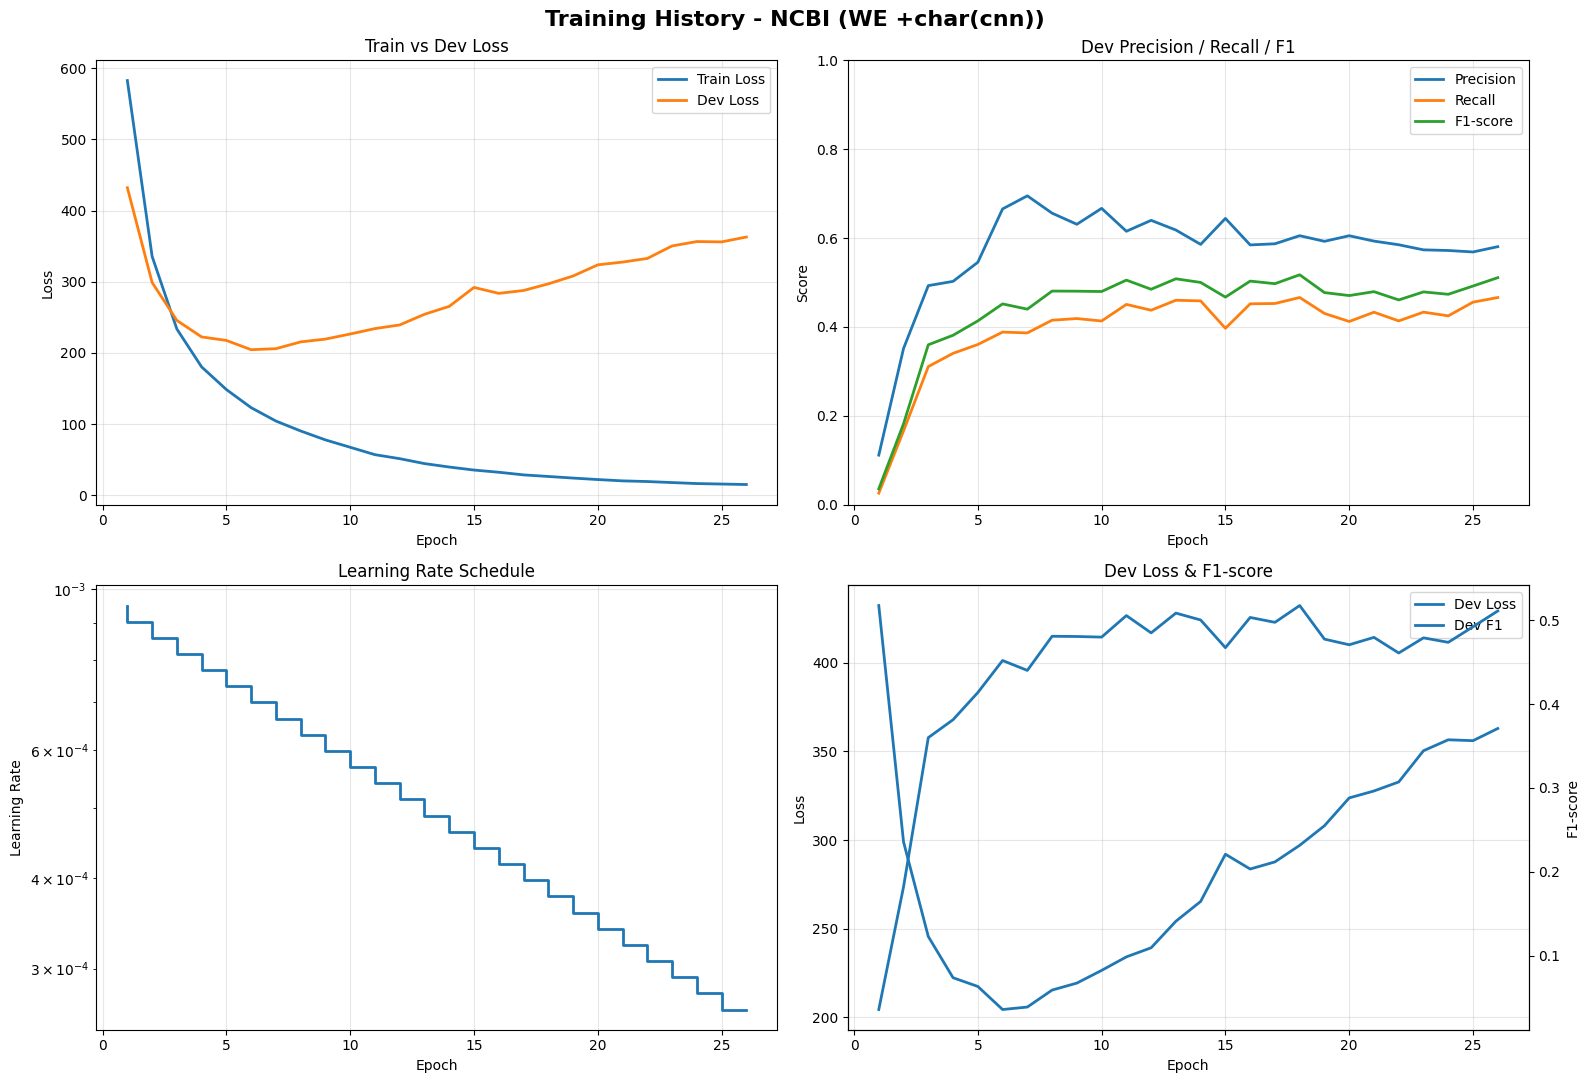


STATISTIQUES FINALES - NCBI (WE +char(cnn))
Meilleur F1 (dev)       : 0.5174
Meilleure Precision(dev): 0.6951
Meilleur Recall (dev)   : 0.4663
Final train loss        : 14.9239
Final dev loss          : 362.8904
Final learning rate     : 0.000264


In [32]:
plot_training_history(history_we_char_attention, dataset_name="NCBI (WE +char(cnn))")

In [83]:
model_path = "./checkpoints/NCBI/WE_char_cnn/best_model.pt"
model_we_char_cnn, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='NCBI',
    loaders_dict=results_ncbi,
    use_char_cnn=True,use_char_lstm=False,use_attention=False,use_fc_fusion=False
)
test_loader = results_ncbi['test_loader']
predictions_we_char_cnn, targets_we_char_cnn = predict_on_test_set(
    model=model_we_char_cnn,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

# Statistiques
correct_count = sum(1 for p, t in zip(predictions_we_char_cnn[:50], targets_we_char_cnn[:50]) if p == t)
print(f"\nRésumé: {correct_count}/50 corrects ({correct_count/50:.1%})")

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_40232\4030328369.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Modèle chargé depuis: ./checkpoints/NCBI/WE_char_cnn/best_model.pt
Best F1 enregistré: 0.5181
Époque: 13
  0 -> <PAD>
  1 -> B-CompositeMention
  2 -> B-DiseaseClass
  3 -> B-Modifier
  4 -> B-SpecificDisease
  5 -> I-CompositeMention
  6 -> I-DiseaseClass
  7 -> I-Modifier
  8 -> I-SpecificDisease
  9 -> O
  0 | I-SpecificDisease  | O                  incorrect
  1 | I-SpecificDisease  | O                  incorrect
  2 | I-SpecificDisease  | O                  incorrect
  3 | I-SpecificDisease  | O                  incorrect
  4 | I-SpecificDisease  | O                  incorrect
  5 | I-SpecificDisease  | O                  incorrect
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | O                  | O                  correct
  9 | B-Modifier         | B-Modifier         correct
 10 | I-Modifier         | I-Modifier         correct
 11 | I-Modifier         | I-Modifier         correct
 12 | I-Modifier         | I-Mo


Accuracy globale: 0.8767

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: I-SpecificDisease

Statistiques:
  Total tokens: 24216
  Entity tokens: 5616
  Unique entity tags in targets: {'B-CompositeMention', 'B-Modifier', 'B-DiseaseClass', 'B-SpecificDisease', 'I-DiseaseClass', 'I-SpecificDisease', 'I-Modifier', 'I-CompositeMention'}
  Unique entity tags in predictions: {'B-CompositeMention', 'B-Modifier', 'B-DiseaseClass', 'B-SpecificDisease', 'O', 'I-DiseaseClass', 'I-SpecificDisease', 'I-Modifier', 'I-CompositeMention'}
  Tags valides à plotter: ['B-CompositeMention', 'B-DiseaseClass', 'B-Modifier', 'B-SpecificDisease', 'I-CompositeMention', 'I-DiseaseClass', 'I-Modifier', 'I-SpecificDisease', 'O']


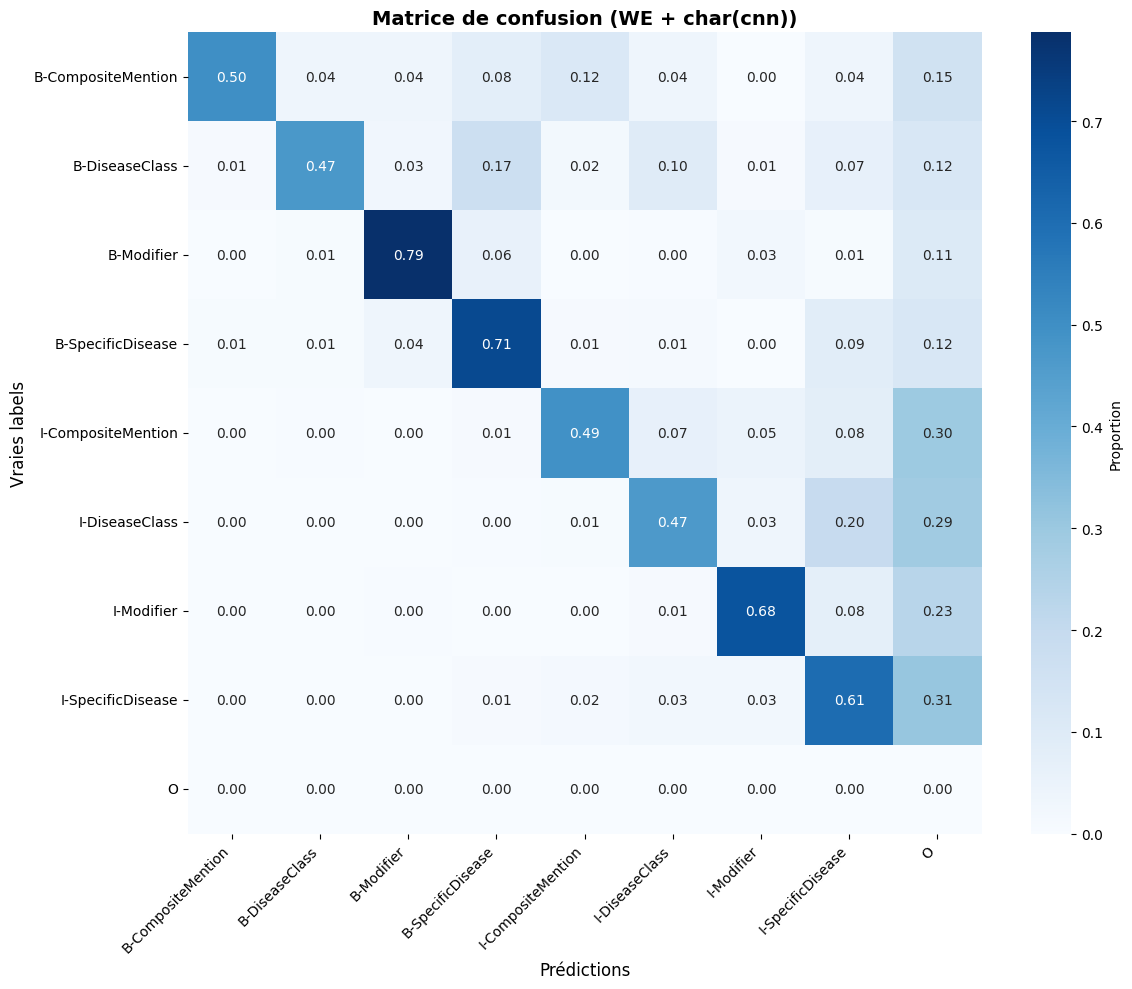

                    precision    recall  f1-score   support

B-CompositeMention       0.76      0.50      0.60        26
    B-DiseaseClass       0.74      0.47      0.58       104
        B-Modifier       0.87      0.79      0.83       235
 B-SpecificDisease       0.82      0.71      0.76       460
I-CompositeMention       0.68      0.49      0.57       257
    I-DiseaseClass       0.70      0.47      0.56       602
        I-Modifier       0.88      0.68      0.77      1242
 I-SpecificDisease       0.85      0.61      0.71      2690
                 O       0.00      0.00      0.00         0

          accuracy                           0.61      5616
         macro avg       0.70      0.52      0.60      5616
      weighted avg       0.83      0.61      0.71      5616

B-CompositeMention  : Precision=0.765, Recall=0.500, F1=0.605, Support=26
B-DiseaseClass      : Precision=0.742, Recall=0.471, F1=0.576, Support=104
B-Modifier          : Precision=0.873, Recall=0.787, F1=0.828, Suppo

In [50]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char_cnn, predictions_we_char_cnn)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions_we_char_cnn, targets_we_char_cnn) if t != 'O']
entity_targets = [t for p, t in zip(predictions_we_char_cnn, targets_we_char_cnn) if t != 'O']

if set(predictions_we_char_cnn) == set(targets_we_char_cnn) or all(isinstance(p, str) for p in predictions_we_char_cnn):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char_cnn,
        targets=targets_we_char_cnn,
        idx_to_tag=idx_to_tag,
        dataset_name='NCBI (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(cnn))"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char_cnn[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char_cnn[:10])}")

## Combinaison 6 : WE + char(cnn) + attention

In [34]:
model_we_char_cnn_attention, history_we_char_cnn_attention = run_pipeline(
    dataset_name='NCBI',
    loaders=results_ncbi,
    use_char_cnn=True,
    use_char_lstm=False,
    use_attention=True,
    use_fc_fusion=False,
    embedding_url=None,  
    lstm_hidden_dim=128,
    epochs=40,
    patience=4,
    checkpoints_dir="./checkpoints/NCBI"
)


Model parameters: 1,391,958


Training: 100%|██████████| 165/165 [01:04<00:00,  2.56it/s]


Epoch 01/40 | Train loss: 601.7083 | Dev loss: 436.7408 | P: 0.0505 R: 0.0499 F1: 0.0502 | LR: 0.000950
Meilleur modèle sauvegardé: F1 0.0502


Training: 100%|██████████| 165/165 [00:58<00:00,  2.80it/s]


Epoch 02/40 | Train loss: 359.7772 | Dev loss: 316.8398 | P: 0.3157 R: 0.1798 F1: 0.1950 | LR: 0.000902
Meilleur modèle sauvegardé: F1 0.1950


Training: 100%|██████████| 165/165 [00:58<00:00,  2.82it/s]


Epoch 03/40 | Train loss: 248.8300 | Dev loss: 265.0301 | P: 0.4005 R: 0.2812 F1: 0.3127 | LR: 0.000857
Meilleur modèle sauvegardé: F1 0.3127


Training: 100%|██████████| 165/165 [00:58<00:00,  2.82it/s]


Epoch 04/40 | Train loss: 193.8662 | Dev loss: 227.7095 | P: 0.4930 R: 0.3451 F1: 0.3914 | LR: 0.000815
Meilleur modèle sauvegardé: F1 0.3914


Training: 100%|██████████| 165/165 [00:59<00:00,  2.77it/s]


Epoch 05/40 | Train loss: 160.1819 | Dev loss: 223.8982 | P: 0.6154 R: 0.3661 F1: 0.4278 | LR: 0.000774
Meilleur modèle sauvegardé: F1 0.4278


Training: 100%|██████████| 165/165 [01:01<00:00,  2.68it/s]


Epoch 06/40 | Train loss: 135.5153 | Dev loss: 225.8304 | P: 0.6165 R: 0.4080 F1: 0.4763 | LR: 0.000735
Meilleur modèle sauvegardé: F1 0.4763


Training: 100%|██████████| 165/165 [01:01<00:00,  2.67it/s]


Epoch 07/40 | Train loss: 116.9551 | Dev loss: 215.2463 | P: 0.5864 R: 0.4434 F1: 0.4953 | LR: 0.000698
Meilleur modèle sauvegardé: F1 0.4953


Training: 100%|██████████| 165/165 [01:02<00:00,  2.66it/s]


Epoch 08/40 | Train loss: 101.7367 | Dev loss: 217.4290 | P: 0.6038 R: 0.4436 F1: 0.4973 | LR: 0.000663
Meilleur modèle sauvegardé: F1 0.4973


Training: 100%|██████████| 165/165 [01:02<00:00,  2.65it/s]


Epoch 09/40 | Train loss: 90.1686 | Dev loss: 221.0312 | P: 0.5907 R: 0.4661 F1: 0.5175 | LR: 0.000630
Meilleur modèle sauvegardé: F1 0.5175


Training: 100%|██████████| 165/165 [01:02<00:00,  2.65it/s]


Epoch 10/40 | Train loss: 79.7210 | Dev loss: 224.0647 | P: 0.5998 R: 0.4311 F1: 0.4869 | LR: 0.000599


Training: 100%|██████████| 165/165 [01:02<00:00,  2.66it/s]


Epoch 11/40 | Train loss: 70.6990 | Dev loss: 236.8546 | P: 0.6319 R: 0.4785 F1: 0.5325 | LR: 0.000569
Meilleur modèle sauvegardé: F1 0.5325


Training: 100%|██████████| 165/165 [01:01<00:00,  2.67it/s]


Epoch 12/40 | Train loss: 63.2983 | Dev loss: 235.8822 | P: 0.6174 R: 0.4617 F1: 0.5135 | LR: 0.000540


Training: 100%|██████████| 165/165 [01:02<00:00,  2.66it/s]


Epoch 13/40 | Train loss: 57.2835 | Dev loss: 245.9918 | P: 0.5991 R: 0.4855 F1: 0.5286 | LR: 0.000513


Training: 100%|██████████| 165/165 [01:01<00:00,  2.68it/s]


Epoch 14/40 | Train loss: 50.7486 | Dev loss: 260.0259 | P: 0.5995 R: 0.4705 F1: 0.5202 | LR: 0.000488


Training: 100%|██████████| 165/165 [01:01<00:00,  2.68it/s]


Epoch 15/40 | Train loss: 46.1510 | Dev loss: 273.7530 | P: 0.6378 R: 0.4487 F1: 0.5136 | LR: 0.000463
Early stopping triggered après 15 epochs.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_40232\3419951289.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoints_path)



RÉSULTATS FINAUX SUR LE TEST SET
Loss: 197.6645
Precision: 0.5888
Recall: 0.5438
F1-score: 0.5619


In [51]:
print_model_layers(model_we_char_cnn_attention)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    1,185,000
char_cnn.char_embedding (Embedding) |        4,300
char_cnn.convs.0 (Conv1d)      |        3,232
char_cnn.convs.1 (Conv1d)      |        4,832
char_cnn.convs.2 (Conv1d)      |        6,432
char_cnn.dropout (Dropout)     |            0
context_lstm (LSTM)            |      185,344
attention_layer.W (Linear)     |          128
emission (Linear)              |        2,570
crf (CRF)                      |          120
---------------------------------------------
Total parameters               |    1,391,958


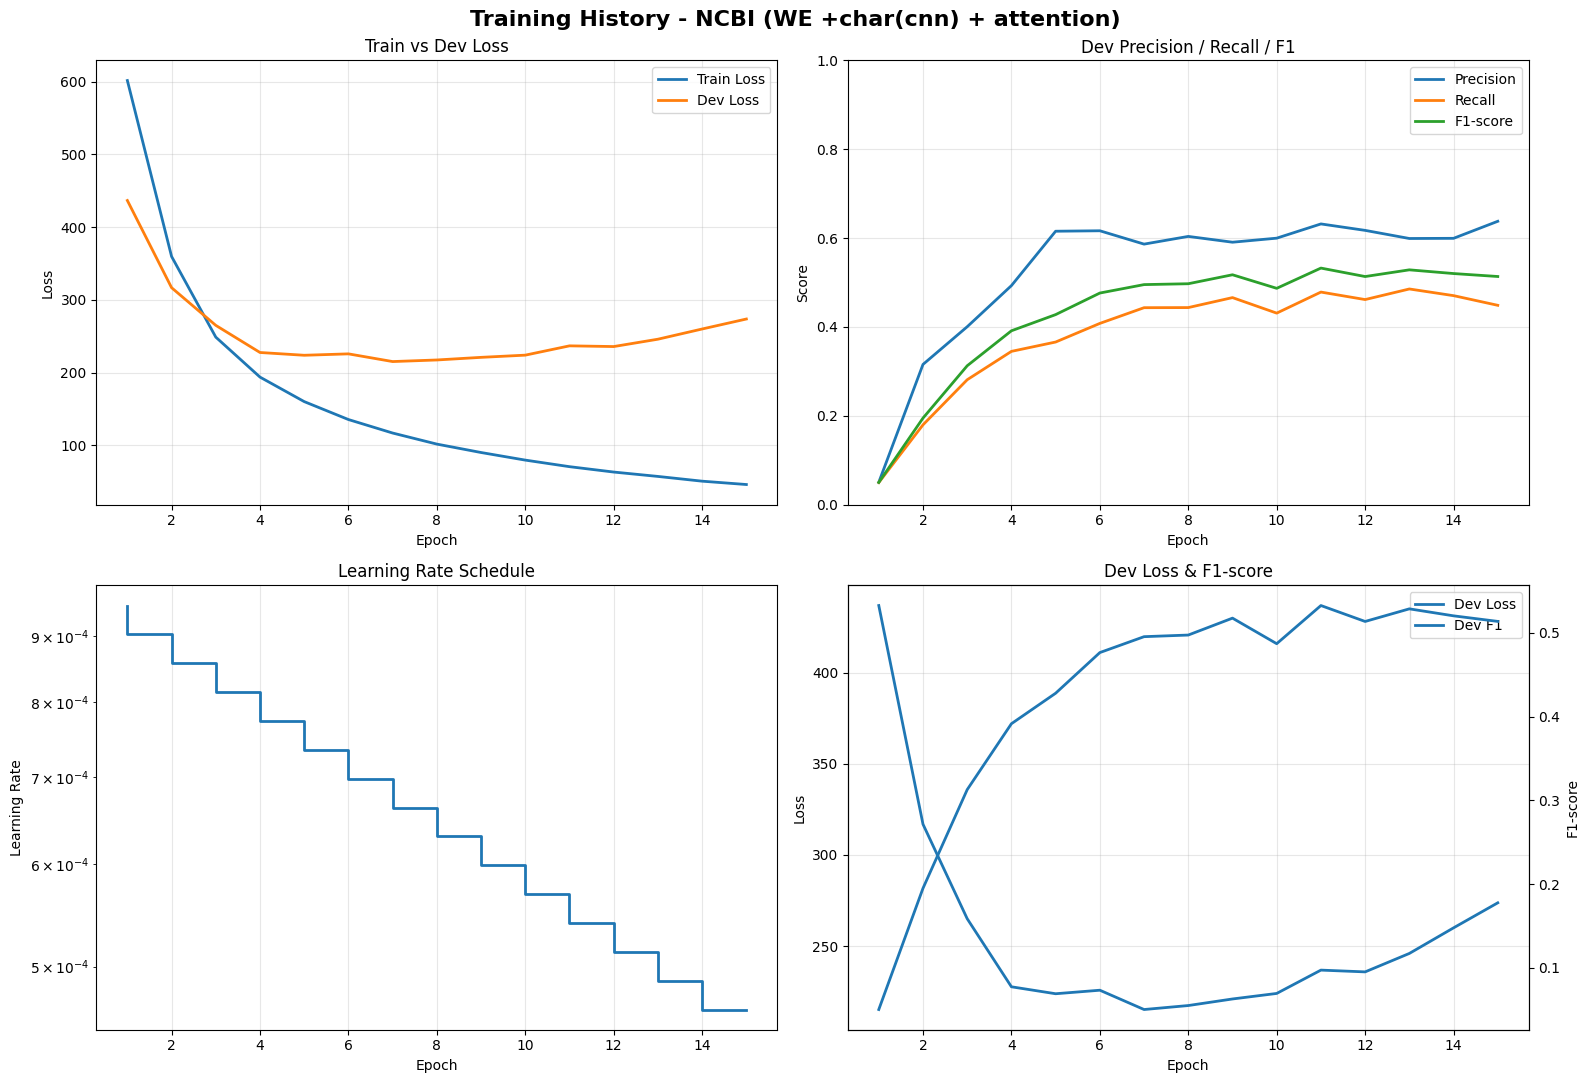


STATISTIQUES FINALES - NCBI (WE +char(cnn) + attention)
Meilleur F1 (dev)       : 0.5325
Meilleure Precision(dev): 0.6378
Meilleur Recall (dev)   : 0.4855
Final train loss        : 46.1510
Final dev loss          : 273.7530
Final learning rate     : 0.000463


In [36]:
plot_training_history(history_we_char_cnn_attention, dataset_name="NCBI (WE +char(cnn) + attention)")

In [82]:
model_path = "./checkpoints/NCBI/WE_char_cnn_attention/best_model.pt"
model_we_char_cnn_attention, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='NCBI',
    loaders_dict=results_ncbi,
    use_char_cnn=True,use_char_lstm=False,use_attention=True,use_fc_fusion=False
)
test_loader = results_ncbi['test_loader']
predictions_we_char_cnn_attention, targets_we_char_cnn_attention = predict_on_test_set(
    model=model_we_char_cnn_attention,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

# Statistiques
correct_count = sum(1 for p, t in zip(predictions_we_char_cnn_attention[:50], targets_we_char_cnn_attention[:50]) if p == t)
print(f"\nRésumé: {correct_count}/50 corrects ({correct_count/50:.1%})")

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_40232\4030328369.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Modèle chargé depuis: ./checkpoints/NCBI/WE_char_cnn_attention/best_model.pt
Best F1 enregistré: 0.5325
Époque: 10
  0 -> <PAD>
  1 -> B-CompositeMention
  2 -> B-DiseaseClass
  3 -> B-Modifier
  4 -> B-SpecificDisease
  5 -> I-CompositeMention
  6 -> I-DiseaseClass
  7 -> I-Modifier
  8 -> I-SpecificDisease
  9 -> O
  0 | I-SpecificDisease  | O                  incorrect
  1 | I-SpecificDisease  | O                  incorrect
  2 | I-SpecificDisease  | O                  incorrect
  3 | I-SpecificDisease  | O                  incorrect
  4 | I-SpecificDisease  | O                  incorrect
  5 | I-SpecificDisease  | O                  incorrect
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | O                  | O                  correct
  9 | B-Modifier         | B-Modifier         correct
 10 | I-Modifier         | I-Modifier         correct
 11 | I-Modifier         | I-Modifier         correct
 12 | I-Modifier     


Accuracy globale: 0.8726

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: I-SpecificDisease

Statistiques:
  Total tokens: 24216
  Entity tokens: 5616
  Unique entity tags in targets: {'B-CompositeMention', 'B-Modifier', 'B-DiseaseClass', 'B-SpecificDisease', 'I-DiseaseClass', 'I-SpecificDisease', 'I-Modifier', 'I-CompositeMention'}
  Unique entity tags in predictions: {'B-CompositeMention', 'B-Modifier', 'B-DiseaseClass', 'B-SpecificDisease', 'O', 'I-DiseaseClass', 'I-SpecificDisease', 'I-Modifier', 'I-CompositeMention'}
  Tags valides à plotter: ['B-CompositeMention', 'B-DiseaseClass', 'B-Modifier', 'B-SpecificDisease', 'I-CompositeMention', 'I-DiseaseClass', 'I-Modifier', 'I-SpecificDisease', 'O']


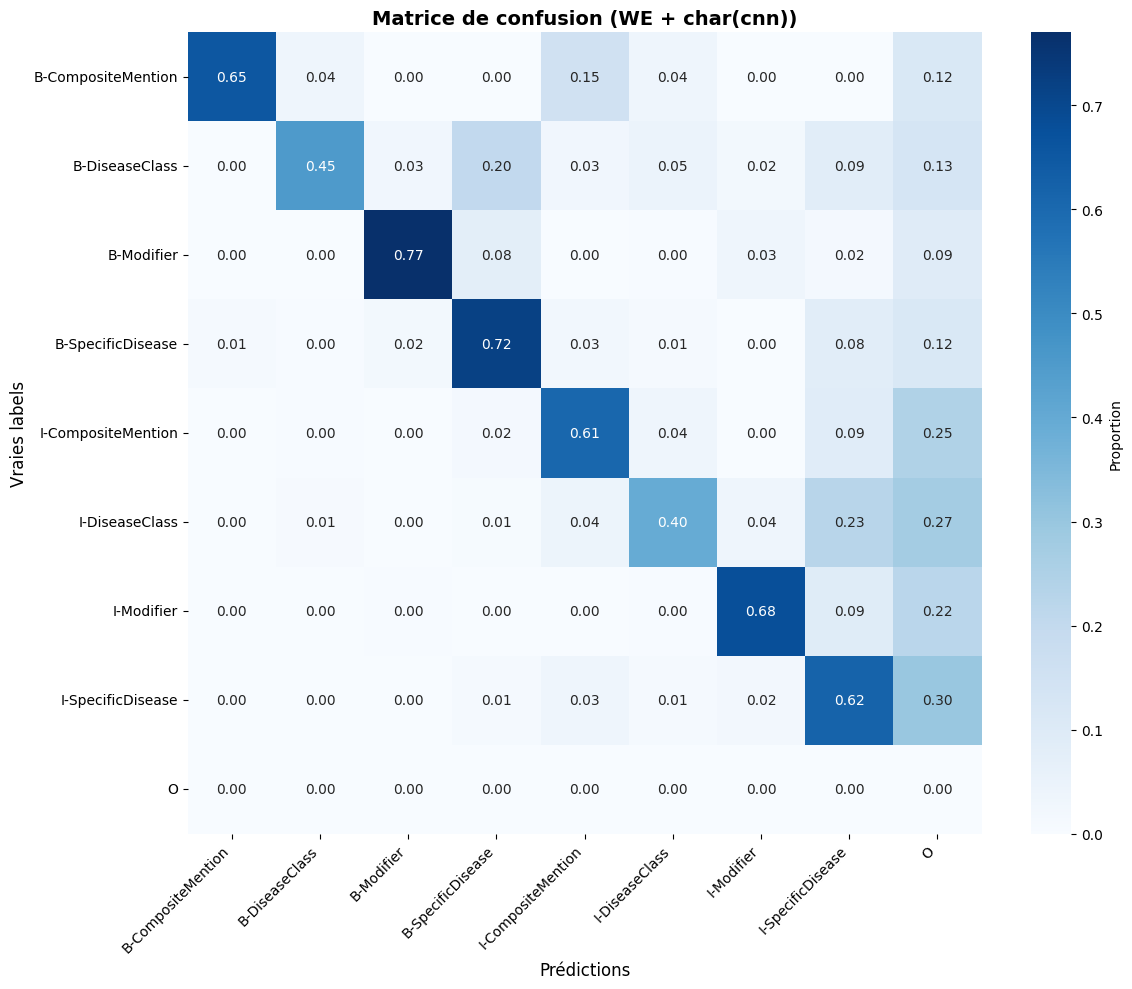

                    precision    recall  f1-score   support

B-CompositeMention       0.71      0.65      0.68        26
    B-DiseaseClass       0.77      0.45      0.57       104
        B-Modifier       0.90      0.77      0.83       235
 B-SpecificDisease       0.79      0.72      0.75       460
I-CompositeMention       0.53      0.61      0.57       257
    I-DiseaseClass       0.79      0.40      0.53       602
        I-Modifier       0.90      0.68      0.77      1242
 I-SpecificDisease       0.84      0.62      0.71      2690
                 O       0.00      0.00      0.00         0

          accuracy                           0.62      5616
         macro avg       0.69      0.54      0.60      5616
      weighted avg       0.83      0.62      0.70      5616

B-CompositeMention  : Precision=0.708, Recall=0.654, F1=0.680, Support=26
B-DiseaseClass      : Precision=0.770, Recall=0.452, F1=0.570, Support=104
B-Modifier          : Precision=0.896, Recall=0.770, F1=0.828, Suppo

In [53]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char_cnn_attention, predictions_we_char_cnn_attention)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions_we_char_cnn_attention, targets_we_char_cnn_attention) if t != 'O']
entity_targets = [t for p, t in zip(predictions_we_char_cnn_attention, targets_we_char_cnn_attention) if t != 'O']

if set(predictions_we_char_cnn_attention) == set(targets_we_char_cnn_attention) or all(isinstance(p, str) for p in predictions_we_char_cnn_attention):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char_cnn_attention,
        targets=targets_we_char_cnn_attention,
        idx_to_tag=idx_to_tag,
        dataset_name='NCBI (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(cnn))"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char_cnn_attention[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char_cnn_attention[:10])}")

## Combinaison 7: WE + char(cnn, bilstm)

In [42]:
model_we_char_cnn_bilstm, history_we_char_cnn_bilstm = run_pipeline(
    dataset_name='NCBI',
    loaders=results_ncbi,
    use_char_cnn=True,
    use_char_lstm=True,
    use_attention=False,
    use_fc_fusion=False,
    embedding_url=None,  
    lstm_hidden_dim=128,
    epochs=40,
    patience=4,
    checkpoints_dir="./checkpoints/NCBI"
)


Model parameters: 1,486,850


Training: 100%|██████████| 165/165 [00:49<00:00,  3.36it/s]


Epoch 01/40 | Train loss: 583.8533 | Dev loss: 405.0150 | P: 0.1100 R: 0.0807 F1: 0.0872 | LR: 0.000950
Meilleur modèle sauvegardé: F1 0.0872


Training: 100%|██████████| 165/165 [00:48<00:00,  3.42it/s]


Epoch 02/40 | Train loss: 327.2164 | Dev loss: 282.7646 | P: 0.3961 R: 0.2177 F1: 0.2405 | LR: 0.000902
Meilleur modèle sauvegardé: F1 0.2405


Training: 100%|██████████| 165/165 [00:48<00:00,  3.41it/s]


Epoch 03/40 | Train loss: 230.5285 | Dev loss: 242.8730 | P: 0.4424 R: 0.3069 F1: 0.3527 | LR: 0.000857
Meilleur modèle sauvegardé: F1 0.3527


Training: 100%|██████████| 165/165 [00:48<00:00,  3.43it/s]


Epoch 04/40 | Train loss: 183.6939 | Dev loss: 216.7676 | P: 0.5359 R: 0.3645 F1: 0.4046 | LR: 0.000815
Meilleur modèle sauvegardé: F1 0.4046


Training: 100%|██████████| 165/165 [00:56<00:00,  2.92it/s]


Epoch 05/40 | Train loss: 150.0743 | Dev loss: 227.0868 | P: 0.5407 R: 0.3669 F1: 0.4225 | LR: 0.000774
Meilleur modèle sauvegardé: F1 0.4225


Training: 100%|██████████| 165/165 [01:15<00:00,  2.17it/s]


Epoch 06/40 | Train loss: 128.1720 | Dev loss: 202.1400 | P: 0.6393 R: 0.4130 F1: 0.4678 | LR: 0.000735
Meilleur modèle sauvegardé: F1 0.4678


Training: 100%|██████████| 165/165 [01:13<00:00,  2.24it/s]


Epoch 07/40 | Train loss: 108.3084 | Dev loss: 203.2544 | P: 0.6505 R: 0.4321 F1: 0.4592 | LR: 0.000698


Training: 100%|██████████| 165/165 [00:58<00:00,  2.84it/s]


Epoch 08/40 | Train loss: 96.0310 | Dev loss: 195.9835 | P: 0.6175 R: 0.4466 F1: 0.4997 | LR: 0.000663
Meilleur modèle sauvegardé: F1 0.4997


Training: 100%|██████████| 165/165 [00:52<00:00,  3.11it/s]


Epoch 09/40 | Train loss: 83.1140 | Dev loss: 217.5809 | P: 0.6731 R: 0.4302 F1: 0.4985 | LR: 0.000630


Training: 100%|██████████| 165/165 [00:54<00:00,  3.02it/s]


Epoch 10/40 | Train loss: 73.3900 | Dev loss: 206.7052 | P: 0.6092 R: 0.4825 F1: 0.5316 | LR: 0.000599
Meilleur modèle sauvegardé: F1 0.5316


Training: 100%|██████████| 165/165 [00:56<00:00,  2.92it/s]


Epoch 11/40 | Train loss: 64.8381 | Dev loss: 213.8768 | P: 0.6449 R: 0.4893 F1: 0.5513 | LR: 0.000569
Meilleur modèle sauvegardé: F1 0.5513


Training: 100%|██████████| 165/165 [00:54<00:00,  3.01it/s]


Epoch 12/40 | Train loss: 58.2251 | Dev loss: 223.7711 | P: 0.6206 R: 0.4727 F1: 0.5291 | LR: 0.000540


Training: 100%|██████████| 165/165 [01:29<00:00,  1.85it/s]


Epoch 13/40 | Train loss: 52.2993 | Dev loss: 230.5438 | P: 0.6137 R: 0.4746 F1: 0.5298 | LR: 0.000513


Training: 100%|██████████| 165/165 [01:13<00:00,  2.24it/s]


Epoch 14/40 | Train loss: 47.5775 | Dev loss: 233.0994 | P: 0.6488 R: 0.5224 F1: 0.5764 | LR: 0.000488
Meilleur modèle sauvegardé: F1 0.5764


Training: 100%|██████████| 165/165 [00:57<00:00,  2.86it/s]


Epoch 15/40 | Train loss: 43.3647 | Dev loss: 232.6105 | P: 0.5581 R: 0.5220 F1: 0.5371 | LR: 0.000463


Training: 100%|██████████| 165/165 [01:35<00:00,  1.73it/s]


Epoch 16/40 | Train loss: 39.6434 | Dev loss: 251.0399 | P: 0.6276 R: 0.4453 F1: 0.5081 | LR: 0.000440


Training: 100%|██████████| 165/165 [00:56<00:00,  2.90it/s]


Epoch 17/40 | Train loss: 36.1690 | Dev loss: 254.5220 | P: 0.6163 R: 0.4578 F1: 0.5191 | LR: 0.000418


Training: 100%|██████████| 165/165 [00:54<00:00,  3.03it/s]


Epoch 18/40 | Train loss: 33.3815 | Dev loss: 261.1926 | P: 0.6137 R: 0.4939 F1: 0.5434 | LR: 0.000397
Early stopping triggered après 18 epochs.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_40232\3419951289.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoints_path)



RÉSULTATS FINAUX SUR LE TEST SET
Loss: 215.3372
Precision: 0.6016
Recall: 0.5444
F1-score: 0.5707


In [43]:
print_model_layers(model_we_char_cnn_bilstm)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    1,185,000
char_cnn.char_embedding (Embedding) |        4,300
char_cnn.convs.0 (Conv1d)      |        3,232
char_cnn.convs.1 (Conv1d)      |        4,832
char_cnn.convs.2 (Conv1d)      |        6,432
char_cnn.dropout (Dropout)     |            0
char_lstm.char_embedding (Embedding) |        4,300
char_lstm.lstm (LSTM)          |       40,800
char_lstm.dropout (Dropout)    |            0
context_lstm (LSTM)            |      236,544
emission (Linear)              |        1,290
crf (CRF)                      |          120
---------------------------------------------
Total parameters               |    1,486,850


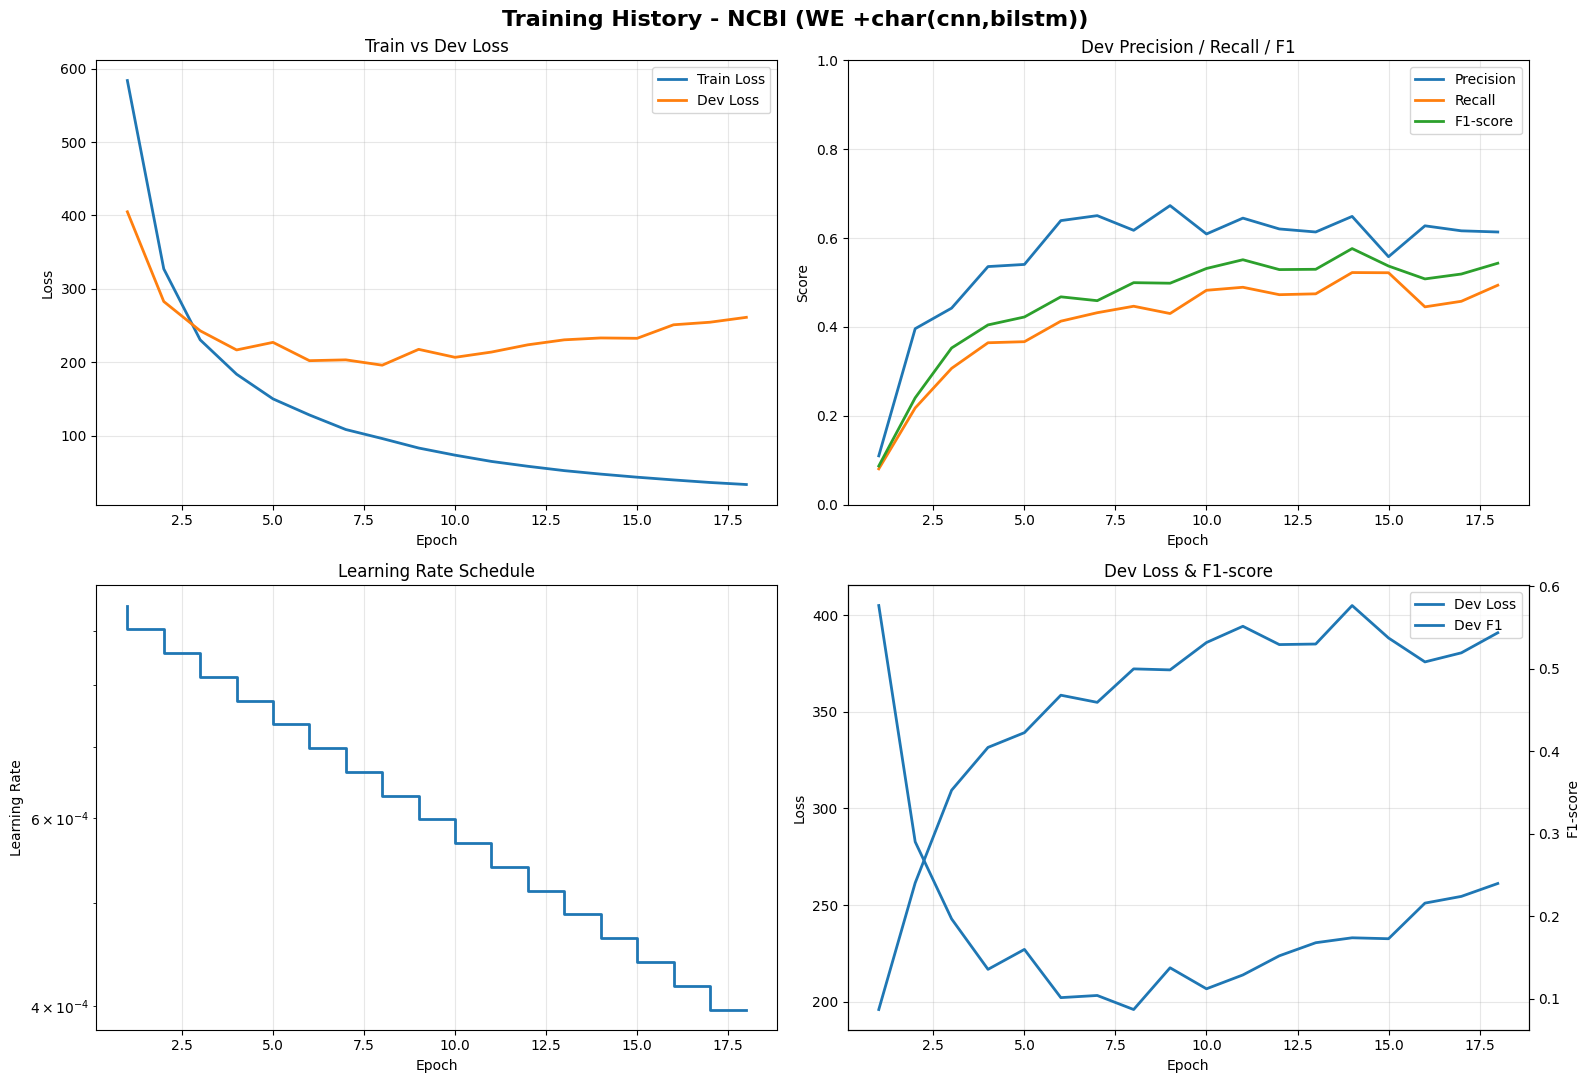


STATISTIQUES FINALES - NCBI (WE +char(cnn,bilstm))
Meilleur F1 (dev)       : 0.5764
Meilleure Precision(dev): 0.6731
Meilleur Recall (dev)   : 0.5224
Final train loss        : 33.3815
Final dev loss          : 261.1926
Final learning rate     : 0.000397


In [54]:
plot_training_history(history_we_char_cnn_bilstm, dataset_name="NCBI (WE +char(cnn,bilstm))")

In [81]:
model_path = "./checkpoints/NCBI/WE_char_bilstm_cnn/best_model.pt"
model_we_char__bilstm_cnn, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='NCBI',
    loaders_dict=results_ncbi,
    use_char_cnn=True,use_char_lstm=True,use_attention=False,use_fc_fusion=False
)
test_loader = results_ncbi['test_loader']
predictions_we_char__bilstm_cnn, targets_we_char__bilstm_cnn = predict_on_test_set(
    model=model_we_char__bilstm_cnn,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)
# Statistiques
correct_count = sum(1 for p, t in zip(predictions_we_char__bilstm_cnn[:50], targets_we_char__bilstm_cnn[:50]) if p == t)
print(f"\nRésumé: {correct_count}/50 corrects ({correct_count/50:.1%})")

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_40232\4030328369.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Modèle chargé depuis: ./checkpoints/NCBI/WE_char_bilstm_cnn/best_model.pt
Best F1 enregistré: 0.5764
Époque: 13
  0 -> <PAD>
  1 -> B-CompositeMention
  2 -> B-DiseaseClass
  3 -> B-Modifier
  4 -> B-SpecificDisease
  5 -> I-CompositeMention
  6 -> I-DiseaseClass
  7 -> I-Modifier
  8 -> I-SpecificDisease
  9 -> O
  0 | I-SpecificDisease  | O                  incorrect
  1 | I-SpecificDisease  | O                  incorrect
  2 | I-SpecificDisease  | O                  incorrect
  3 | I-SpecificDisease  | O                  incorrect
  4 | I-SpecificDisease  | O                  incorrect
  5 | I-SpecificDisease  | O                  incorrect
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | O                  | O                  correct
  9 | B-Modifier         | B-Modifier         correct
 10 | I-Modifier         | I-Modifier         correct
 11 | I-Modifier         | I-Modifier         correct
 12 | I-Modifier        


Accuracy globale: 0.8805

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: I-SpecificDisease

Statistiques:
  Total tokens: 24216
  Entity tokens: 5616
  Unique entity tags in targets: {'B-CompositeMention', 'B-Modifier', 'B-DiseaseClass', 'B-SpecificDisease', 'I-DiseaseClass', 'I-SpecificDisease', 'I-Modifier', 'I-CompositeMention'}
  Unique entity tags in predictions: {'B-CompositeMention', 'B-Modifier', 'B-DiseaseClass', 'B-SpecificDisease', 'O', 'I-DiseaseClass', 'I-SpecificDisease', 'I-Modifier', 'I-CompositeMention'}
  Tags valides à plotter: ['B-CompositeMention', 'B-DiseaseClass', 'B-Modifier', 'B-SpecificDisease', 'I-CompositeMention', 'I-DiseaseClass', 'I-Modifier', 'I-SpecificDisease', 'O']


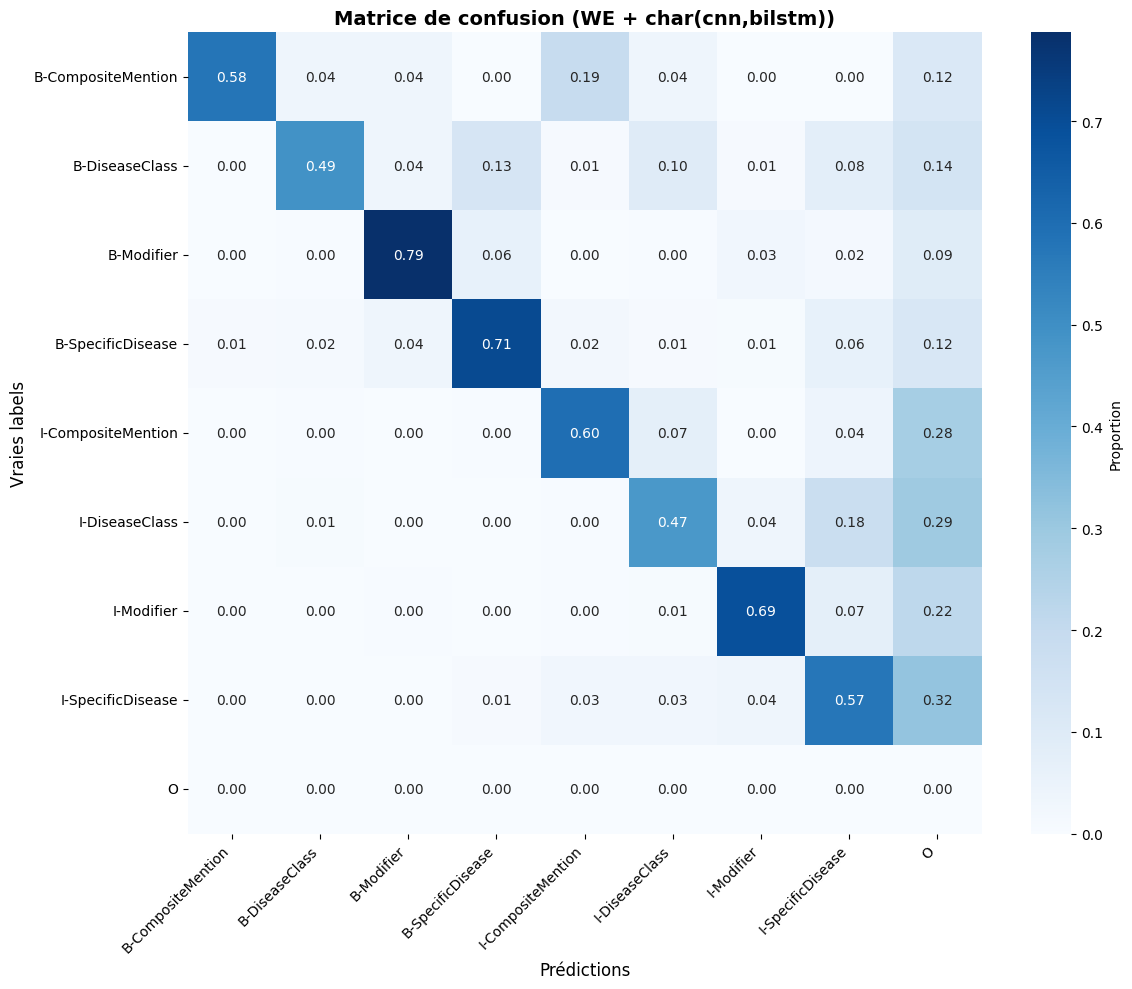

                    precision    recall  f1-score   support

B-CompositeMention       0.71      0.58      0.64        26
    B-DiseaseClass       0.72      0.49      0.58       104
        B-Modifier       0.86      0.79      0.82       235
 B-SpecificDisease       0.84      0.71      0.77       460
I-CompositeMention       0.59      0.60      0.59       257
    I-DiseaseClass       0.70      0.47      0.56       602
        I-Modifier       0.87      0.69      0.77      1242
 I-SpecificDisease       0.86      0.57      0.69      2690
                 O       0.00      0.00      0.00         0

          accuracy                           0.61      5616
         macro avg       0.68      0.54      0.60      5616
      weighted avg       0.83      0.61      0.70      5616

B-CompositeMention  : Precision=0.714, Recall=0.577, F1=0.638, Support=26
B-DiseaseClass      : Precision=0.718, Recall=0.490, F1=0.583, Support=104
B-Modifier          : Precision=0.860, Recall=0.787, F1=0.822, Suppo

In [56]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char__bilstm_cnn, predictions_we_char__bilstm_cnn)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions_we_char__bilstm_cnn, targets_we_char__bilstm_cnn) if t != 'O']
entity_targets = [t for p, t in zip(predictions_we_char__bilstm_cnn, targets_we_char__bilstm_cnn) if t != 'O']

if set(predictions_we_char__bilstm_cnn) == set(targets_we_char__bilstm_cnn) or all(isinstance(p, str) for p in predictions_we_char__bilstm_cnn):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char__bilstm_cnn,
        targets=targets_we_char__bilstm_cnn,
        idx_to_tag=idx_to_tag,
        dataset_name='NCBI (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(cnn,bilstm))"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char__bilstm_cnn[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char__bilstm_cnn[:10])}")

## Combinaison 8 : WE + char(cnn, bilstm) + attention

In [57]:
model_we_char_cnn_bilstm_attention, history_we_char_cnn_bilstm_attention = run_pipeline(
    dataset_name='NCBI',
    loaders=results_ncbi,
    use_char_cnn=True,
    use_char_lstm=True,
    use_attention=True,
    use_fc_fusion=False,
    embedding_url=None,  
    lstm_hidden_dim=128,
    epochs=40,
    patience=4,
    checkpoints_dir="./checkpoints/NCBI"
)


Model parameters: 1,488,258


Training: 100%|██████████| 165/165 [01:09<00:00,  2.36it/s]


Epoch 01/40 | Train loss: 593.4420 | Dev loss: 480.3227 | P: 0.0634 R: 0.0140 F1: 0.0229 | LR: 0.000950
Meilleur modèle sauvegardé: F1 0.0229


Training: 100%|██████████| 165/165 [01:09<00:00,  2.39it/s]


Epoch 02/40 | Train loss: 352.8541 | Dev loss: 293.5577 | P: 0.3413 R: 0.2103 F1: 0.2387 | LR: 0.000902
Meilleur modèle sauvegardé: F1 0.2387


Training: 100%|██████████| 165/165 [01:09<00:00,  2.37it/s]


Epoch 03/40 | Train loss: 245.2813 | Dev loss: 256.8803 | P: 0.4577 R: 0.3262 F1: 0.3598 | LR: 0.000857
Meilleur modèle sauvegardé: F1 0.3598


Training: 100%|██████████| 165/165 [01:09<00:00,  2.39it/s]


Epoch 04/40 | Train loss: 190.2866 | Dev loss: 223.0790 | P: 0.5191 R: 0.3412 F1: 0.3975 | LR: 0.000815
Meilleur modèle sauvegardé: F1 0.3975


Training: 100%|██████████| 165/165 [01:09<00:00,  2.39it/s]


Epoch 05/40 | Train loss: 155.7727 | Dev loss: 211.8859 | P: 0.6394 R: 0.4096 F1: 0.4709 | LR: 0.000774
Meilleur modèle sauvegardé: F1 0.4709


Training: 100%|██████████| 165/165 [01:18<00:00,  2.10it/s]


Epoch 06/40 | Train loss: 132.9246 | Dev loss: 203.8501 | P: 0.6601 R: 0.4113 F1: 0.4653 | LR: 0.000735


Training: 100%|██████████| 165/165 [01:33<00:00,  1.77it/s]


Epoch 07/40 | Train loss: 114.1625 | Dev loss: 198.6985 | P: 0.6405 R: 0.4276 F1: 0.4789 | LR: 0.000698
Meilleur modèle sauvegardé: F1 0.4789


Training: 100%|██████████| 165/165 [01:40<00:00,  1.64it/s]


Epoch 08/40 | Train loss: 99.5119 | Dev loss: 202.6768 | P: 0.6123 R: 0.4637 F1: 0.5221 | LR: 0.000663
Meilleur modèle sauvegardé: F1 0.5221


Training: 100%|██████████| 165/165 [01:36<00:00,  1.72it/s]


Epoch 09/40 | Train loss: 87.0374 | Dev loss: 205.8994 | P: 0.5769 R: 0.4840 F1: 0.5148 | LR: 0.000630


Training: 100%|██████████| 165/165 [01:35<00:00,  1.73it/s]


Epoch 10/40 | Train loss: 78.1091 | Dev loss: 202.7847 | P: 0.6014 R: 0.4766 F1: 0.5253 | LR: 0.000599
Meilleur modèle sauvegardé: F1 0.5253


Training: 100%|██████████| 165/165 [01:36<00:00,  1.71it/s]


Epoch 11/40 | Train loss: 69.6460 | Dev loss: 211.9737 | P: 0.6494 R: 0.4538 F1: 0.5202 | LR: 0.000569


Training: 100%|██████████| 165/165 [01:36<00:00,  1.72it/s]


Epoch 12/40 | Train loss: 61.5179 | Dev loss: 214.5707 | P: 0.6602 R: 0.4827 F1: 0.5500 | LR: 0.000540
Meilleur modèle sauvegardé: F1 0.5500


Training: 100%|██████████| 165/165 [01:34<00:00,  1.75it/s]


Epoch 13/40 | Train loss: 55.2181 | Dev loss: 222.6632 | P: 0.6121 R: 0.4958 F1: 0.5428 | LR: 0.000513


Training: 100%|██████████| 165/165 [01:35<00:00,  1.72it/s]


Epoch 14/40 | Train loss: 50.0975 | Dev loss: 232.5737 | P: 0.6453 R: 0.4881 F1: 0.5497 | LR: 0.000488


Training: 100%|██████████| 165/165 [01:34<00:00,  1.74it/s]


Epoch 15/40 | Train loss: 45.3554 | Dev loss: 238.2983 | P: 0.6389 R: 0.4777 F1: 0.5322 | LR: 0.000463


Training: 100%|██████████| 165/165 [01:37<00:00,  1.70it/s]


Epoch 16/40 | Train loss: 41.1240 | Dev loss: 242.2008 | P: 0.6348 R: 0.4841 F1: 0.5432 | LR: 0.000440
Early stopping triggered après 16 epochs.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_40232\3419951289.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoints_path)



RÉSULTATS FINAUX SUR LE TEST SET
Loss: 187.9220
Precision: 0.6234
Recall: 0.5569
F1-score: 0.5867


In [58]:
print_model_layers(model_we_char_cnn_bilstm_attention)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    1,185,000
char_cnn.char_embedding (Embedding) |        4,300
char_cnn.convs.0 (Conv1d)      |        3,232
char_cnn.convs.1 (Conv1d)      |        4,832
char_cnn.convs.2 (Conv1d)      |        6,432
char_cnn.dropout (Dropout)     |            0
char_lstm.char_embedding (Embedding) |        4,300
char_lstm.lstm (LSTM)          |       40,800
char_lstm.dropout (Dropout)    |            0
context_lstm (LSTM)            |      236,544
attention_layer.W (Linear)     |          128
emission (Linear)              |        2,570
crf (CRF)                      |          120
---------------------------------------------
Total parameters               |    1,488,258


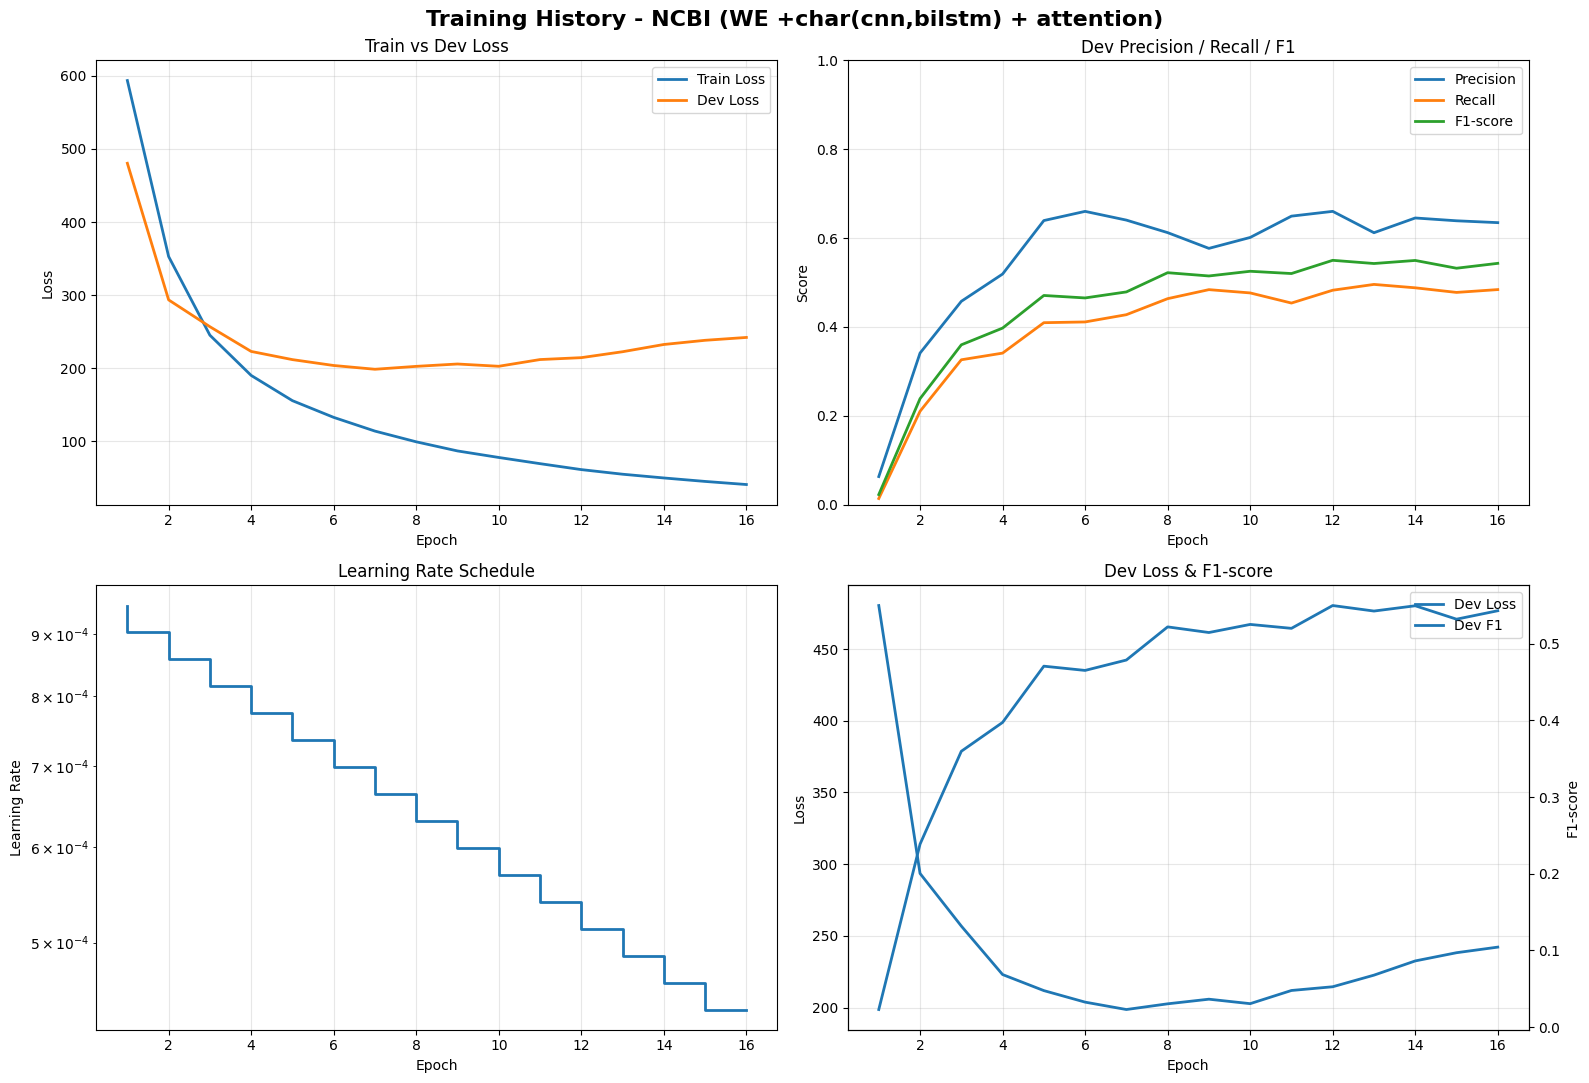


STATISTIQUES FINALES - NCBI (WE +char(cnn,bilstm) + attention)
Meilleur F1 (dev)       : 0.5500
Meilleure Precision(dev): 0.6602
Meilleur Recall (dev)   : 0.4958
Final train loss        : 41.1240
Final dev loss          : 242.2008
Final learning rate     : 0.000440


In [59]:
plot_training_history(history_we_char_cnn_bilstm_attention, dataset_name="NCBI (WE +char(cnn,bilstm) + attention)")

In [80]:
model_path = "./checkpoints/NCBI/WE_char_bilstm_cnn_attention/best_model.pt"
model_we_char__bilstm_cnn_attention, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='NCBI',
    loaders_dict=results_ncbi,
    use_char_cnn=True,use_char_lstm=True,use_attention=True,use_fc_fusion=False
)
test_loader = results_ncbi['test_loader']
predictions_we_char__bilstm_cnn_attention, targets_we_char__bilstm_cnn_attention = predict_on_test_set(
    model=model_we_char__bilstm_cnn_attention,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

# Statistiques
correct_count = sum(1 for p, t in zip(predictions_we_char__bilstm_cnn_attention[:50], targets_we_char__bilstm_cnn_attention[:50]) if p == t)
print(f"\nRésumé: {correct_count}/50 corrects ({correct_count/50:.1%})")

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_40232\4030328369.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Modèle chargé depuis: ./checkpoints/NCBI/WE_char_bilstm_cnn_attention/best_model.pt
Best F1 enregistré: 0.5500
Époque: 11
  0 -> <PAD>
  1 -> B-CompositeMention
  2 -> B-DiseaseClass
  3 -> B-Modifier
  4 -> B-SpecificDisease
  5 -> I-CompositeMention
  6 -> I-DiseaseClass
  7 -> I-Modifier
  8 -> I-SpecificDisease
  9 -> O
  0 | I-SpecificDisease  | O                  incorrect
  1 | I-SpecificDisease  | O                  incorrect
  2 | I-SpecificDisease  | O                  incorrect
  3 | I-SpecificDisease  | O                  incorrect
  4 | I-SpecificDisease  | O                  incorrect
  5 | I-SpecificDisease  | O                  incorrect
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | O                  | O                  correct
  9 | B-Modifier         | B-Modifier         correct
 10 | I-Modifier         | I-Modifier         correct
 11 | I-Modifier         | I-Modifier         correct
 12 | I-Modifi


Accuracy globale: 0.8847

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: I-SpecificDisease

Statistiques:
  Total tokens: 24216
  Entity tokens: 5616
  Unique entity tags in targets: {'B-CompositeMention', 'B-Modifier', 'B-DiseaseClass', 'B-SpecificDisease', 'I-DiseaseClass', 'I-SpecificDisease', 'I-Modifier', 'I-CompositeMention'}
  Unique entity tags in predictions: {'B-CompositeMention', 'B-Modifier', 'B-DiseaseClass', 'B-SpecificDisease', 'O', 'I-DiseaseClass', 'I-SpecificDisease', 'I-Modifier', 'I-CompositeMention'}
  Tags valides à plotter: ['B-CompositeMention', 'B-DiseaseClass', 'B-Modifier', 'B-SpecificDisease', 'I-CompositeMention', 'I-DiseaseClass', 'I-Modifier', 'I-SpecificDisease', 'O']


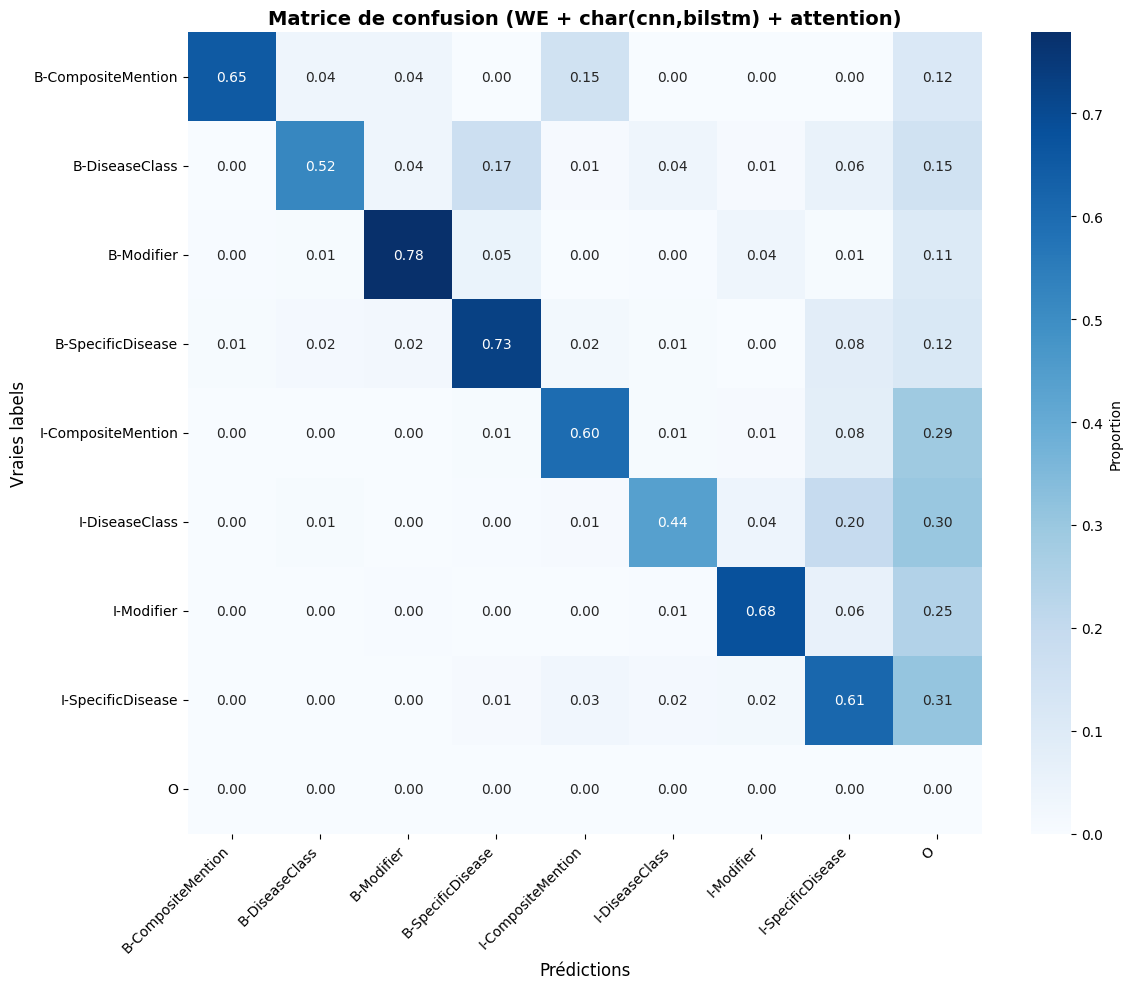

                    precision    recall  f1-score   support

B-CompositeMention       0.71      0.65      0.68        26
    B-DiseaseClass       0.76      0.52      0.62       104
        B-Modifier       0.90      0.78      0.84       235
 B-SpecificDisease       0.83      0.73      0.78       460
I-CompositeMention       0.60      0.60      0.60       257
    I-DiseaseClass       0.82      0.44      0.57       602
        I-Modifier       0.90      0.68      0.78      1242
 I-SpecificDisease       0.86      0.61      0.72      2690
                 O       0.00      0.00      0.00         0

          accuracy                           0.62      5616
         macro avg       0.71      0.56      0.62      5616
      weighted avg       0.85      0.62      0.72      5616

B-CompositeMention  : Precision=0.708, Recall=0.654, F1=0.680, Support=26
B-DiseaseClass      : Precision=0.761, Recall=0.519, F1=0.617, Support=104
B-Modifier          : Precision=0.901, Recall=0.779, F1=0.836, Suppo

In [61]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char__bilstm_cnn_attention, predictions_we_char__bilstm_cnn_attention)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions_we_char__bilstm_cnn_attention, targets_we_char__bilstm_cnn_attention) if t != 'O']
entity_targets = [t for p, t in zip(predictions_we_char__bilstm_cnn_attention, targets_we_char__bilstm_cnn_attention) if t != 'O']

if set(predictions_we_char__bilstm_cnn_attention) == set(targets_we_char__bilstm_cnn_attention) or all(isinstance(p, str) for p in predictions_we_char__bilstm_cnn_attention):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char__bilstm_cnn_attention,
        targets=targets_we_char__bilstm_cnn_attention,
        idx_to_tag=idx_to_tag,
        dataset_name='NCBI (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(cnn,bilstm) + attention)"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char__bilstm_cnn_attention[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char__bilstm_cnn_attention[:10])}")

## Combinaison 9:  WE + char(cnn, bilstm) + fully connected network

In [87]:
model_we_char_cnn_bilstm_fc, history_we_char_cnn_bilstm_fc = run_pipeline(
     dataset_name='NCBI',
    loaders=results_ncbi,       
    use_char_cnn=True,
    use_char_lstm=True,
    use_attention=False,
    use_fc_fusion=True,
    embedding_url=None,            
    epochs=40,                    
    patience=4,                    
    checkpoints_dir="./checkpoints/NCBI"
)

Model parameters: 1,465,898


Training: 100%|██████████| 165/165 [01:02<00:00,  2.64it/s]


Epoch 01/40 | Train loss: 604.6161 | Dev loss: 461.7991 | P: 0.0903 R: 0.0175 F1: 0.0288 | LR: 0.000950
Meilleur modèle sauvegardé: F1 0.0288


Training: 100%|██████████| 165/165 [01:56<00:00,  1.42it/s]


Epoch 02/40 | Train loss: 347.5748 | Dev loss: 303.2036 | P: 0.2781 R: 0.2034 F1: 0.2267 | LR: 0.000902
Meilleur modèle sauvegardé: F1 0.2267


Training: 100%|██████████| 165/165 [02:00<00:00,  1.37it/s]


Epoch 03/40 | Train loss: 248.6716 | Dev loss: 241.9026 | P: 0.4699 R: 0.2929 F1: 0.3481 | LR: 0.000857
Meilleur modèle sauvegardé: F1 0.3481


Training: 100%|██████████| 165/165 [01:54<00:00,  1.44it/s]


Epoch 04/40 | Train loss: 194.3748 | Dev loss: 216.1764 | P: 0.4264 R: 0.3749 F1: 0.3974 | LR: 0.000815
Meilleur modèle sauvegardé: F1 0.3974


Training: 100%|██████████| 165/165 [01:54<00:00,  1.44it/s]


Epoch 05/40 | Train loss: 162.7895 | Dev loss: 201.8875 | P: 0.5882 R: 0.3829 F1: 0.4335 | LR: 0.000774
Meilleur modèle sauvegardé: F1 0.4335


Training: 100%|██████████| 165/165 [01:59<00:00,  1.38it/s]


Epoch 06/40 | Train loss: 140.4159 | Dev loss: 200.0772 | P: 0.6257 R: 0.4413 F1: 0.4905 | LR: 0.000735
Meilleur modèle sauvegardé: F1 0.4905


Training: 100%|██████████| 165/165 [01:46<00:00,  1.54it/s]


Epoch 07/40 | Train loss: 126.3070 | Dev loss: 195.0460 | P: 0.7031 R: 0.4123 F1: 0.4650 | LR: 0.000698


Training: 100%|██████████| 165/165 [01:52<00:00,  1.46it/s]


Epoch 08/40 | Train loss: 111.7913 | Dev loss: 194.3962 | P: 0.6902 R: 0.4430 F1: 0.4941 | LR: 0.000663
Meilleur modèle sauvegardé: F1 0.4941


Training: 100%|██████████| 165/165 [01:38<00:00,  1.67it/s]


Epoch 09/40 | Train loss: 101.1668 | Dev loss: 192.7121 | P: 0.6456 R: 0.4688 F1: 0.5224 | LR: 0.000630
Meilleur modèle sauvegardé: F1 0.5224


Training: 100%|██████████| 165/165 [01:16<00:00,  2.14it/s]


Epoch 10/40 | Train loss: 93.0510 | Dev loss: 196.7560 | P: 0.6972 R: 0.4475 F1: 0.4992 | LR: 0.000599


Training: 100%|██████████| 165/165 [00:53<00:00,  3.07it/s]


Epoch 11/40 | Train loss: 86.6221 | Dev loss: 201.0942 | P: 0.6913 R: 0.4356 F1: 0.5019 | LR: 0.000569


Training: 100%|██████████| 165/165 [01:00<00:00,  2.72it/s]


Epoch 12/40 | Train loss: 80.9859 | Dev loss: 202.4625 | P: 0.6496 R: 0.4679 F1: 0.5251 | LR: 0.000540
Meilleur modèle sauvegardé: F1 0.5251


Training: 100%|██████████| 165/165 [00:52<00:00,  3.16it/s]


Epoch 13/40 | Train loss: 75.0749 | Dev loss: 202.8140 | P: 0.6735 R: 0.4855 F1: 0.5441 | LR: 0.000513
Meilleur modèle sauvegardé: F1 0.5441


Training: 100%|██████████| 165/165 [01:00<00:00,  2.72it/s]


Epoch 14/40 | Train loss: 69.6983 | Dev loss: 211.1517 | P: 0.6827 R: 0.4703 F1: 0.5337 | LR: 0.000488


Training: 100%|██████████| 165/165 [01:02<00:00,  2.63it/s]


Epoch 15/40 | Train loss: 65.7961 | Dev loss: 203.8928 | P: 0.6530 R: 0.5266 F1: 0.5757 | LR: 0.000463
Meilleur modèle sauvegardé: F1 0.5757


Training: 100%|██████████| 165/165 [00:59<00:00,  2.76it/s]


Epoch 16/40 | Train loss: 62.5584 | Dev loss: 212.7133 | P: 0.6386 R: 0.4854 F1: 0.5360 | LR: 0.000440


Training: 100%|██████████| 165/165 [01:01<00:00,  2.69it/s]


Epoch 17/40 | Train loss: 58.0481 | Dev loss: 208.6537 | P: 0.6088 R: 0.5064 F1: 0.5476 | LR: 0.000418


Training: 100%|██████████| 165/165 [01:01<00:00,  2.69it/s]


Epoch 18/40 | Train loss: 55.2831 | Dev loss: 223.7338 | P: 0.6485 R: 0.4893 F1: 0.5469 | LR: 0.000397


Training: 100%|██████████| 165/165 [00:55<00:00,  2.98it/s]


Epoch 19/40 | Train loss: 52.6435 | Dev loss: 224.4432 | P: 0.6216 R: 0.4977 F1: 0.5421 | LR: 0.000377
Early stopping triggered après 19 epochs.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_40232\3419951289.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoints_path)



RÉSULTATS FINAUX SUR LE TEST SET
Loss: 183.4911
Precision: 0.5738
Recall: 0.5695
F1-score: 0.5703


In [88]:
print_model_layers(model_we_char_cnn_bilstm_fc)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    1,185,000
char_cnn.char_embedding (Embedding) |        4,300
char_cnn.convs.0 (Conv1d)      |        3,232
char_cnn.convs.1 (Conv1d)      |        4,832
char_cnn.convs.2 (Conv1d)      |        6,432
char_cnn.dropout (Dropout)     |            0
char_lstm.char_embedding (Embedding) |        4,300
char_lstm.lstm (LSTM)          |       40,800
char_lstm.dropout (Dropout)    |            0
fusion.0 (Linear)              |       79,400
fusion.1 (ReLU)                |            0
fusion.2 (Dropout)             |            0
context_lstm (LSTM)            |      136,192
emission (Linear)              |        1,290
crf (CRF)                      |          120
---------------------------------------------
Total parameters               |    1,465,898


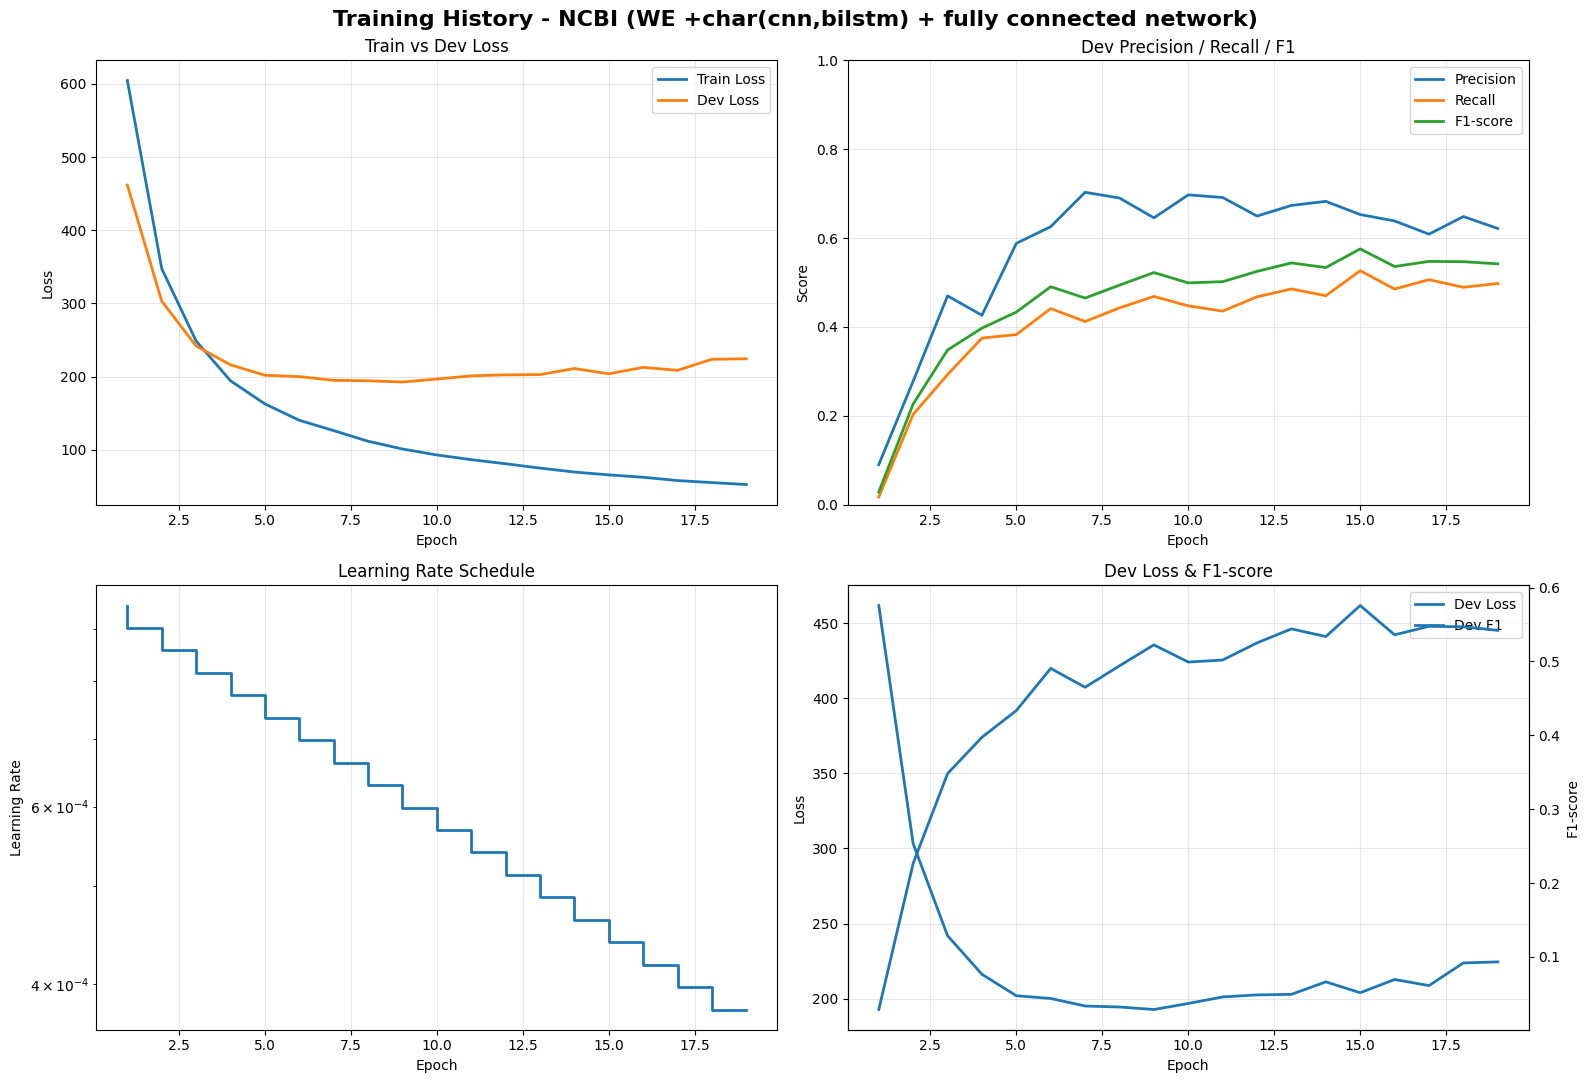


STATISTIQUES FINALES - NCBI (WE +char(cnn,bilstm) + fully connected network)
Meilleur F1 (dev)       : 0.5757
Meilleure Precision(dev): 0.7031
Meilleur Recall (dev)   : 0.5266
Final train loss        : 52.6435
Final dev loss          : 224.4432
Final learning rate     : 0.000377


In [89]:
plot_training_history(history_we_char_cnn_bilstm_fc, dataset_name="NCBI (WE +char(cnn,bilstm) + fully connected network)")

In [90]:
model_path = "./checkpoints/NCBI/WE_char_bilstm_cnn_fc/best_model.pt"
model_we_char__bilstm_cnn_fc, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='NCBI',
    loaders_dict=results_ncbi,
    use_char_cnn=True,use_char_lstm=True,use_attention=False,use_fc_fusion=True
)
test_loader = results_ncbi['test_loader']
predictions_we_char__bilstm_cnn_fc, targets_we_char__bilstm_cnn_fc = predict_on_test_set(
    model=model_we_char__bilstm_cnn_fc,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)
# Statistiques
correct_count = sum(1 for p, t in zip(predictions_we_char__bilstm_cnn_fc[:50], targets_we_char__bilstm_cnn_fc[:50]) if p == t)
print(f"\nRésumé: {correct_count}/50 corrects ({correct_count/50:.1%})")

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_40232\4030328369.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Modèle chargé depuis: ./checkpoints/NCBI/WE_char_bilstm_cnn_fc/best_model.pt
Best F1 enregistré: 0.5757
Époque: 14
  0 -> <PAD>
  1 -> B-CompositeMention
  2 -> B-DiseaseClass
  3 -> B-Modifier
  4 -> B-SpecificDisease
  5 -> I-CompositeMention
  6 -> I-DiseaseClass
  7 -> I-Modifier
  8 -> I-SpecificDisease
  9 -> O
  0 | I-SpecificDisease  | O                  incorrect
  1 | I-SpecificDisease  | O                  incorrect
  2 | I-SpecificDisease  | O                  incorrect
  3 | I-SpecificDisease  | O                  incorrect
  4 | I-SpecificDisease  | O                  incorrect
  5 | I-SpecificDisease  | O                  incorrect
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | O                  | O                  correct
  9 | B-Modifier         | B-Modifier         correct
 10 | I-Modifier         | I-Modifier         correct
 11 | I-Modifier         | I-Modifier         correct
 12 | I-Modifier     


Accuracy globale: 0.8777

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: I-SpecificDisease

Statistiques:
  Total tokens: 24216
  Entity tokens: 5616
  Unique entity tags in targets: {'B-CompositeMention', 'B-Modifier', 'B-DiseaseClass', 'B-SpecificDisease', 'I-DiseaseClass', 'I-SpecificDisease', 'I-Modifier', 'I-CompositeMention'}
  Unique entity tags in predictions: {'B-CompositeMention', 'B-Modifier', 'B-DiseaseClass', 'B-SpecificDisease', 'O', 'I-DiseaseClass', 'I-SpecificDisease', 'I-Modifier', 'I-CompositeMention'}
  Tags valides à plotter: ['B-CompositeMention', 'B-DiseaseClass', 'B-Modifier', 'B-SpecificDisease', 'I-CompositeMention', 'I-DiseaseClass', 'I-Modifier', 'I-SpecificDisease', 'O']


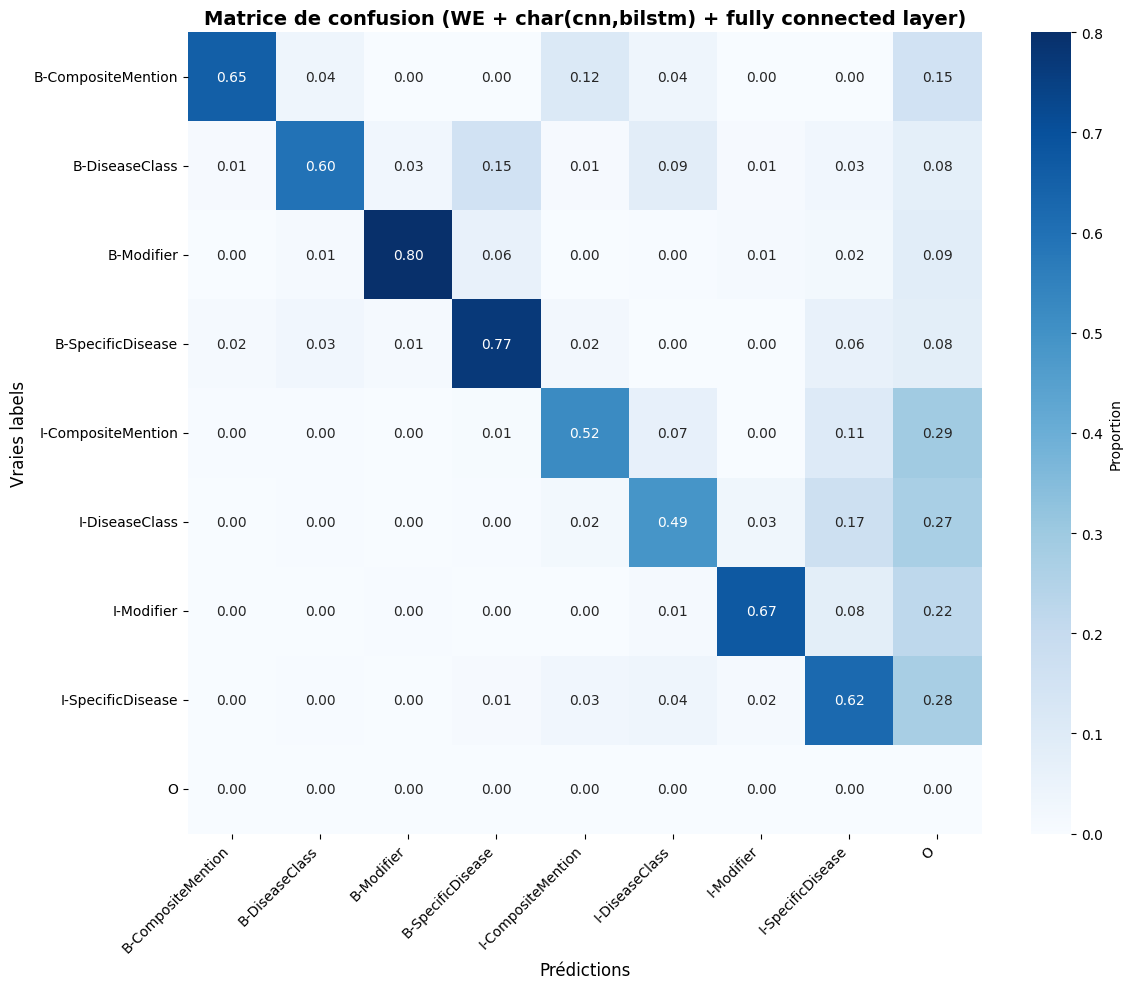

                    precision    recall  f1-score   support

B-CompositeMention       0.63      0.65      0.64        26
    B-DiseaseClass       0.65      0.60      0.62       104
        B-Modifier       0.90      0.80      0.85       235
 B-SpecificDisease       0.84      0.77      0.80       460
I-CompositeMention       0.54      0.52      0.53       257
    I-DiseaseClass       0.67      0.49      0.57       602
        I-Modifier       0.93      0.67      0.78      1242
 I-SpecificDisease       0.86      0.62      0.72      2690
                 O       0.00      0.00      0.00         0

          accuracy                           0.63      5616
         macro avg       0.67      0.57      0.61      5616
      weighted avg       0.84      0.63      0.72      5616

B-CompositeMention  : Precision=0.630, Recall=0.654, F1=0.642, Support=26
B-DiseaseClass      : Precision=0.646, Recall=0.596, F1=0.620, Support=104
B-Modifier          : Precision=0.904, Recall=0.800, F1=0.849, Suppo

In [91]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char__bilstm_cnn_fc, predictions_we_char__bilstm_cnn_fc)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions_we_char__bilstm_cnn_fc, targets_we_char__bilstm_cnn_fc) if t != 'O']
entity_targets = [t for p, t in zip(predictions_we_char__bilstm_cnn_fc, targets_we_char__bilstm_cnn_fc) if t != 'O']

if set(predictions_we_char__bilstm_cnn_fc) == set(targets_we_char__bilstm_cnn_fc) or all(isinstance(p, str) for p in predictions_we_char__bilstm_cnn_fc):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char__bilstm_cnn_fc,
        targets=targets_we_char__bilstm_cnn_fc,
        idx_to_tag=idx_to_tag,
        dataset_name='JNLPBA (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(cnn,bilstm) + fully connected layer)"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char__bilstm_cnn_fc[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char__bilstm_cnn_fc[:10])}")

## Combinaison 10 : WE + char(cnn, bilstm) + attention + fully connected network

In [62]:
model_we_char_cnn_bilstm_attention_fc, history_we_char_cnn_bilstm_attention_fc = run_pipeline(
    dataset_name='NCBI',
    loaders=results_ncbi,
    use_char_cnn=True,
    use_char_lstm=True,
    use_attention=True,
    use_fc_fusion=True,
    embedding_url=None,  
    lstm_hidden_dim=128,
    epochs=40,
    patience=4,
    checkpoints_dir="./checkpoints/NCBI"
)


Model parameters: 1,467,306


Training: 100%|██████████| 165/165 [01:32<00:00,  1.79it/s]


Epoch 01/40 | Train loss: 637.3965 | Dev loss: 473.7168 | P: 0.0526 R: 0.0148 F1: 0.0231 | LR: 0.000950
Meilleur modèle sauvegardé: F1 0.0231


Training: 100%|██████████| 165/165 [01:28<00:00,  1.86it/s]


Epoch 02/40 | Train loss: 385.7786 | Dev loss: 332.0412 | P: 0.2286 R: 0.1816 F1: 0.2007 | LR: 0.000902
Meilleur modèle sauvegardé: F1 0.2007


Training: 100%|██████████| 165/165 [01:45<00:00,  1.56it/s]


Epoch 03/40 | Train loss: 276.1494 | Dev loss: 265.0076 | P: 0.3717 R: 0.2535 F1: 0.2776 | LR: 0.000857
Meilleur modèle sauvegardé: F1 0.2776


Training: 100%|██████████| 165/165 [02:07<00:00,  1.30it/s]


Epoch 04/40 | Train loss: 216.9861 | Dev loss: 238.3797 | P: 0.4470 R: 0.3211 F1: 0.3673 | LR: 0.000815
Meilleur modèle sauvegardé: F1 0.3673


Training: 100%|██████████| 165/165 [02:18<00:00,  1.19it/s]


Epoch 05/40 | Train loss: 182.6290 | Dev loss: 207.3168 | P: 0.5615 R: 0.3698 F1: 0.4186 | LR: 0.000774
Meilleur modèle sauvegardé: F1 0.4186


Training: 100%|██████████| 165/165 [02:17<00:00,  1.20it/s]


Epoch 06/40 | Train loss: 156.7118 | Dev loss: 205.0235 | P: 0.6876 R: 0.3944 F1: 0.4449 | LR: 0.000735
Meilleur modèle sauvegardé: F1 0.4449


Training: 100%|██████████| 165/165 [02:19<00:00,  1.19it/s]


Epoch 07/40 | Train loss: 137.8928 | Dev loss: 204.2057 | P: 0.6813 R: 0.4237 F1: 0.4782 | LR: 0.000698
Meilleur modèle sauvegardé: F1 0.4782


Training: 100%|██████████| 165/165 [02:19<00:00,  1.18it/s]


Epoch 08/40 | Train loss: 123.2989 | Dev loss: 205.6332 | P: 0.6560 R: 0.4750 F1: 0.5374 | LR: 0.000663
Meilleur modèle sauvegardé: F1 0.5374


Training: 100%|██████████| 165/165 [02:18<00:00,  1.19it/s]


Epoch 09/40 | Train loss: 113.1426 | Dev loss: 199.4000 | P: 0.6435 R: 0.4486 F1: 0.5076 | LR: 0.000630


Training: 100%|██████████| 165/165 [07:19<00:00,  2.66s/it] 


Epoch 10/40 | Train loss: 104.4694 | Dev loss: 199.8202 | P: 0.6688 R: 0.4458 F1: 0.5090 | LR: 0.000599


Training: 100%|██████████| 165/165 [01:17<00:00,  2.12it/s]


Epoch 11/40 | Train loss: 95.7137 | Dev loss: 196.8838 | P: 0.5843 R: 0.4694 F1: 0.5156 | LR: 0.000569


Training: 100%|██████████| 165/165 [01:17<00:00,  2.12it/s]


Epoch 12/40 | Train loss: 89.5334 | Dev loss: 196.5971 | P: 0.6466 R: 0.4592 F1: 0.5129 | LR: 0.000540
Early stopping triggered après 12 epochs.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_40232\3419951289.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoints_path)



RÉSULTATS FINAUX SUR LE TEST SET
Loss: 174.9894
Precision: 0.6191
Recall: 0.5527
F1-score: 0.5802


In [63]:
print_model_layers(model_we_char_cnn_bilstm_attention_fc)

Layer (type)                   |      Param #
---------------------------------------------
word_embedding (Embedding)     |    1,185,000
char_cnn.char_embedding (Embedding) |        4,300
char_cnn.convs.0 (Conv1d)      |        3,232
char_cnn.convs.1 (Conv1d)      |        4,832
char_cnn.convs.2 (Conv1d)      |        6,432
char_cnn.dropout (Dropout)     |            0
char_lstm.char_embedding (Embedding) |        4,300
char_lstm.lstm (LSTM)          |       40,800
char_lstm.dropout (Dropout)    |            0
fusion.0 (Linear)              |       79,400
fusion.1 (ReLU)                |            0
fusion.2 (Dropout)             |            0
context_lstm (LSTM)            |      136,192
attention_layer.W (Linear)     |          128
emission (Linear)              |        2,570
crf (CRF)                      |          120
---------------------------------------------
Total parameters               |    1,467,306


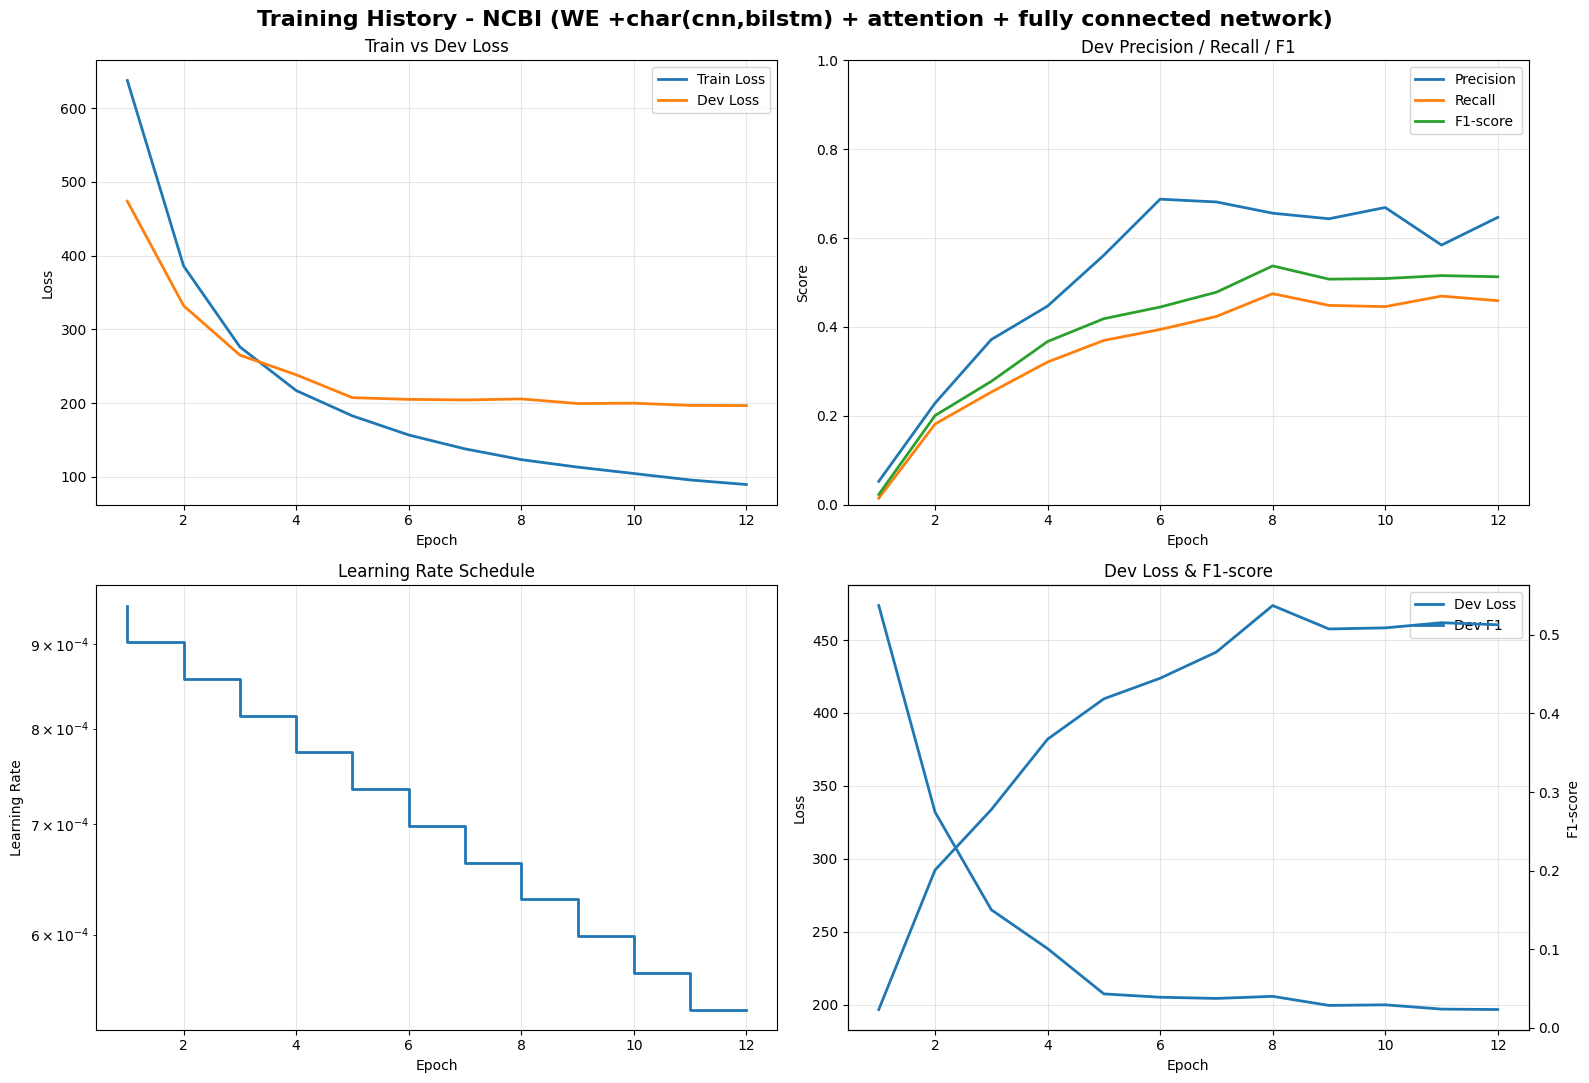


STATISTIQUES FINALES - NCBI (WE +char(cnn,bilstm) + attention + fully connected network)
Meilleur F1 (dev)       : 0.5374
Meilleure Precision(dev): 0.6876
Meilleur Recall (dev)   : 0.4750
Final train loss        : 89.5334
Final dev loss          : 196.5971
Final learning rate     : 0.000540


In [64]:
plot_training_history(history_we_char_cnn_bilstm_attention_fc, dataset_name="NCBI (WE +char(cnn,bilstm) + attention + fully connected network)")

In [65]:
model_path = "./checkpoints/NCBI/WE_char_bilstm_cnn_attention_fc/best_model.pt"
model_we_char__bilstm_cnn_attention_fc, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='NCBI',
    loaders_dict=results_ncbi,
    use_char_cnn=True,use_char_lstm=True,use_attention=True,use_fc_fusion=True
)
test_loader = results_ncbi['test_loader']
predictions_we_char__bilstm_cnn_attention_fc, targets_we_char__bilstm_cnn_attention_fc = predict_on_test_set(
    model=model_we_char__bilstm_cnn_attention_fc,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_40232\4030328369.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Modèle chargé depuis: ./checkpoints/NCBI/WE_char_bilstm_cnn_attention_fc/best_model.pt
Best F1 enregistré: 0.5374
Époque: 7
  0 -> <PAD>
  1 -> B-CompositeMention
  2 -> B-DiseaseClass
  3 -> B-Modifier
  4 -> B-SpecificDisease
  5 -> I-CompositeMention
  6 -> I-DiseaseClass
  7 -> I-Modifier
  8 -> I-SpecificDisease
  9 -> O
  0 | I-SpecificDisease  | O                  incorrect
  1 | I-SpecificDisease  | O                  incorrect
  2 | I-SpecificDisease  | O                  incorrect
  3 | I-SpecificDisease  | O                  incorrect
  4 | I-SpecificDisease  | O                  incorrect
  5 | I-SpecificDisease  | O                  incorrect
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | O                  | O                  correct
  9 | B-Modifier         | B-Modifier         correct
 10 | I-Modifier         | I-Modifier         correct
 11 | I-Modifier         | I-Modifier         correct
 12 | I-Modi


Accuracy globale: 0.8896

Vérification des types:
  Type predictions[0]: <class 'str'>, valeur: O
  Type targets[0]: <class 'str'>, valeur: I-SpecificDisease

Statistiques:
  Total tokens: 24216
  Entity tokens: 5616
  Unique entity tags in targets: {'B-CompositeMention', 'B-Modifier', 'B-DiseaseClass', 'B-SpecificDisease', 'I-DiseaseClass', 'I-SpecificDisease', 'I-Modifier', 'I-CompositeMention'}
  Unique entity tags in predictions: {'B-CompositeMention', 'B-Modifier', 'B-DiseaseClass', 'B-SpecificDisease', 'O', 'I-DiseaseClass', 'I-SpecificDisease', 'I-Modifier', 'I-CompositeMention'}
  Tags valides à plotter: ['B-CompositeMention', 'B-DiseaseClass', 'B-Modifier', 'B-SpecificDisease', 'I-CompositeMention', 'I-DiseaseClass', 'I-Modifier', 'I-SpecificDisease', 'O']


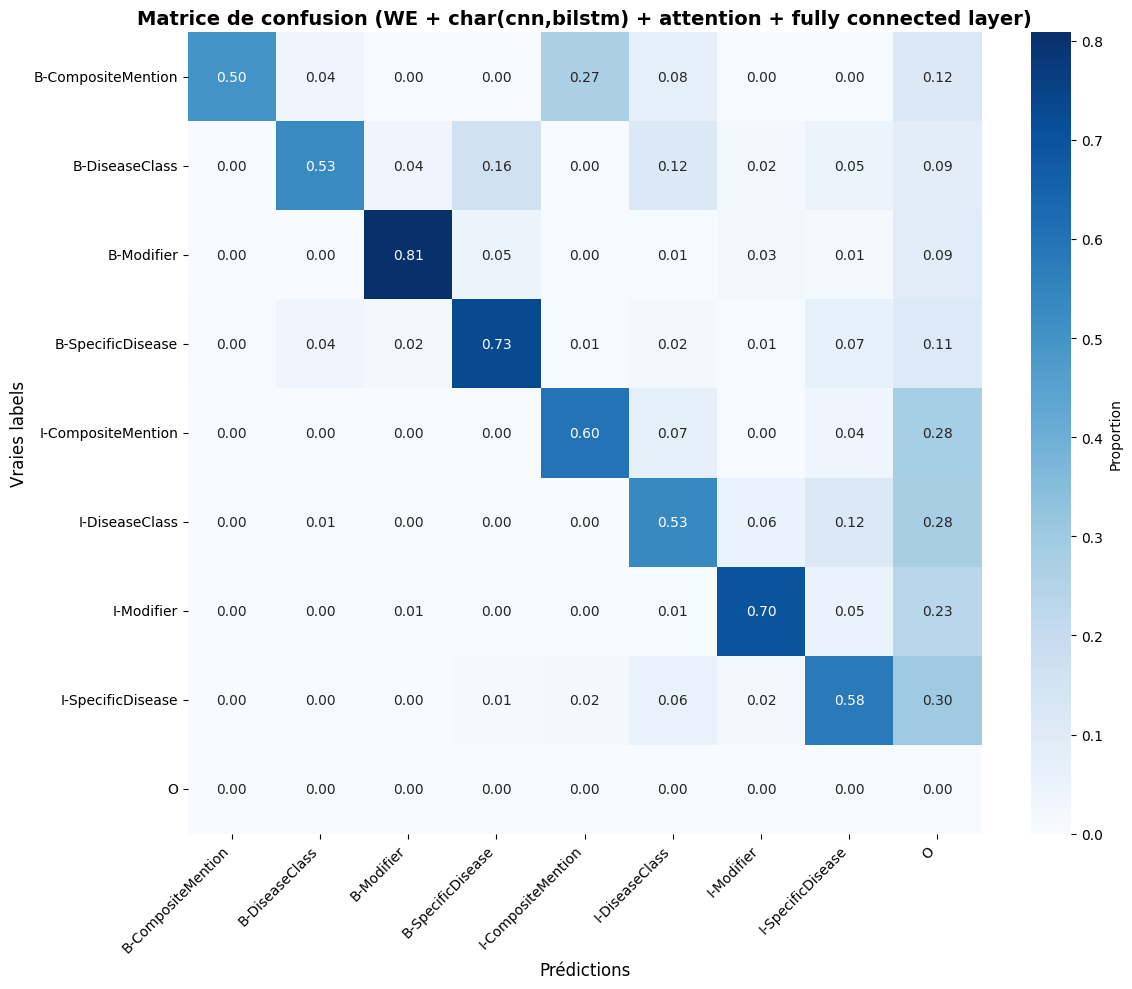

                    precision    recall  f1-score   support

B-CompositeMention       0.87      0.50      0.63        26
    B-DiseaseClass       0.62      0.53      0.57       104
        B-Modifier       0.88      0.81      0.84       235
 B-SpecificDisease       0.82      0.73      0.77       460
I-CompositeMention       0.69      0.60      0.64       257
    I-DiseaseClass       0.61      0.53      0.57       602
        I-Modifier       0.89      0.70      0.78      1242
 I-SpecificDisease       0.89      0.58      0.70      2690
                 O       0.00      0.00      0.00         0

          accuracy                           0.62      5616
         macro avg       0.70      0.55      0.61      5616
      weighted avg       0.84      0.62      0.71      5616

B-CompositeMention  : Precision=0.867, Recall=0.500, F1=0.634, Support=26
B-DiseaseClass      : Precision=0.625, Recall=0.529, F1=0.573, Support=104
B-Modifier          : Precision=0.880, Recall=0.809, F1=0.843, Suppo

In [66]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char__bilstm_cnn_attention_fc, predictions_we_char__bilstm_cnn_attention_fc)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions_we_char__bilstm_cnn_attention_fc, targets_we_char__bilstm_cnn_attention_fc) if t != 'O']
entity_targets = [t for p, t in zip(predictions_we_char__bilstm_cnn_attention_fc, targets_we_char__bilstm_cnn_attention_fc) if t != 'O']

if set(predictions_we_char__bilstm_cnn_attention_fc) == set(targets_we_char__bilstm_cnn_attention_fc) or all(isinstance(p, str) for p in predictions_we_char__bilstm_cnn_attention_fc):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_char__bilstm_cnn_attention_fc,
        targets=targets_we_char__bilstm_cnn_attention_fc,
        idx_to_tag=idx_to_tag,
        dataset_name='NCBI (Test Set)',
        normalize=True,
        figsize=(12, 10),
        title="Matrice de confusion (WE + char(cnn,bilstm) + attention + fully connected layer)"
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char__bilstm_cnn_attention_fc[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char__bilstm_cnn_attention_fc[:10])}")

## Test on a set of examples

In [73]:
import torch

# =========================
# 1. Chargement checkpoint
# =========================
device = "cuda" if torch.cuda.is_available() else "cpu"

checkpoint_path = "./checkpoints/NCBI/WE_char_bilstm_cnn_attention/best_model.pt"
ckpt = torch.load(checkpoint_path, map_location=device)

# =========================
# 2. Récupération EXACTE des objets du training
# =========================
# Ces objets doivent venir des loaders utilisés à l'entraînement
train_loader = results_ncbi["train_loader"]
vocab        = results_ncbi["vocab"]
char_vocab   = results_ncbi["char_vocab"]
tag_to_idx   = results_ncbi["tag_to_idx"]
idx_to_tag   = results_ncbi["idx_to_tag"]
# =========================
# 3. Reconstruction du modèle (IDENTIQUE au training)
# =========================
model = CombinatorialNER(
    vocab_size=len(vocab),
    char_vocab_size=len(char_vocab),
    tag_to_idx=tag_to_idx,
    dataset='NCBI', 
    use_char_cnn=True,
    use_char_lstm=True,
    use_attention=True,
    use_fc_fusion=False,
    pretrained_embeddings=results_ncbi["pretrained_embeddings"],
    word_embed_dim=200,
    lstm_hidden_dim=128,   
    dropout=0.5
).to(device)

model.load_state_dict(ckpt["model_state_dict"])
model.eval()

def token_accuracy(all_preds, all_golds):
    correct = 0
    total = 0
    for preds, golds in zip(all_preds, all_golds):
        for p, g in zip(preds, golds):
            if g != "<PAD>":
                total += 1
                if p == g:
                    correct += 1
    return correct / total

def token_accuracy_single(preds, golds):
    correct = 0
    total = 0
    for p, g in zip(preds, golds):
        if g != "<PAD>":
            total += 1
            if p == g:
                correct += 1
    return correct / total if total > 0 else 0.0


# =========================
# 4. Fonction de prédiction CORRECTE
# =========================
def predict_sentence(
    model,
    sentence,
    vocab,
    char_vocab,
    idx_to_tag,
    device,
    max_seq_len=100,
    max_char_len=20
):
    model.eval()

    PAD_WORD = vocab["<PAD>"]
    UNK_WORD = vocab["<UNK>"]
    PAD_CHAR = char_vocab["<PAD>"]
    UNK_CHAR = char_vocab["<UNK>"]

    # 1. Troncature
    tokens = sentence[:max_seq_len]
    seq_len = len(tokens)

    # 2. Word IDs
    word_ids = [vocab.get(w.lower(), UNK_WORD) for w in tokens]
    word_ids += [PAD_WORD] * (max_seq_len - seq_len)

    # 3. Char IDs
    char_seqs = []
    for w in tokens:
        chars = [char_vocab.get(c, UNK_CHAR) for c in w[:max_char_len]]
        chars += [PAD_CHAR] * (max_char_len - len(chars))
        char_seqs.append(chars)

    char_seqs += [[PAD_CHAR] * max_char_len] * (max_seq_len - seq_len)

    # 4. Tensors
    word_tensor = torch.tensor(word_ids).unsqueeze(0).to(device)
    char_tensor = torch.tensor(char_seqs).unsqueeze(0).to(device)

    mask = torch.zeros((1, max_seq_len), dtype=torch.bool).to(device)
    mask[:, :seq_len] = True

    # 5. Inference CRF
    with torch.no_grad():
        predictions = model(word_tensor, char_tensor, mask)
        predicted_ids = predictions[0][:seq_len]

    return [idx_to_tag[i] for i in predicted_ids]



# =========================
# 5. Phrases de test adaptées aux classes de maladies
# =========================
test_data = [
    # Specific Disease
    (
        ["The", "patient", "has", "COVID", "-", "19", "with", "severe", "symptoms"],
        ["O", "O", "O", "B-SpecificDisease", "I-SpecificDisease", "I-SpecificDisease", "O", "O", "O"]
    ),
    # Disease Class avec Modifier
    (
        ["Chronic", "heart", "disease", "often", "requires", "long", "-", "term", "care"],
        ["B-DiseaseClass", "I-DiseaseClass", "I-DiseaseClass", "O", "O", "B-Modifier", "I-Modifier", "I-Modifier", "O"]
    ),
    # Composite Mention
    (
        ["Coronary", "artery", "disease", "and", "heart", "failure"],
        ["B-CompositeMention", "I-CompositeMention", "I-CompositeMention", "O", "B-CompositeMention", "I-CompositeMention"]
    ),
    # Mix de différentes entités
    (
        ["Acute", "respiratory", "distress", "syndrome", "in", "COVID", "-", "19", "patients"],
        ["B-Modifier", "B-DiseaseClass", "I-DiseaseClass", "I-DiseaseClass", "O", 
         "B-SpecificDisease", "I-SpecificDisease", "I-SpecificDisease", "O"]
    ),
    # Multiple Specific Diseases
    (
        ["Influenza", ",", "HIV", ",", "and", "tuberculosis", "are", "common", "infections"],
        ["B-SpecificDisease", "O", "B-SpecificDisease", "O", "O", "B-SpecificDisease", "O", "O", "O"]
    ),
    # Disease Class avec Specific Disease
    (
        ["Malignant", "melanoma", "is", "a", "type", "of", "skin", "cancer"],
        ["B-Modifier", "B-SpecificDisease", "O", "O", "O", "O", "B-DiseaseClass", "I-DiseaseClass"]
    ),
    # Composite mention complexe
    (
        ["Diabetes", "mellitus", "with", "hypertensive", "kidney", "disease"],
        ["B-CompositeMention", "I-CompositeMention", "O", "B-Modifier", "B-DiseaseClass", "I-DiseaseClass"]
    ),
    # Long sentence with multiple entities
    (
        ["Severe", "acute", "bronchitis", "and", "pneumonia", "in", "immunocompromised", "patients", 
         "with", "AIDS", "require", "immediate", "treatment"],
        ["B-Modifier", "I-Modifier", "B-SpecificDisease", "O", "B-SpecificDisease", "O", 
         "B-Modifier", "O", "O", "B-SpecificDisease", "O", "O", "O"]
    ),
]
# =========================
# 6. Évaluation lisible
# =========================
all_preds = []
all_golds = []

for i, (sentence, gold) in enumerate(test_data, 1):
    preds = predict_sentence(model, sentence, vocab, char_vocab, idx_to_tag, device)

    all_preds.append(preds)
    all_golds.append(gold)

    # Accuracy par phrase
    acc_sentence = token_accuracy_single(preds, gold)

    print(f"Example {i}")
    print(f"{'Token':15s} {'Gold':15s} {'Predicted':15s}")
    print("-" * 50)
    for t, g, p in zip(sentence, gold, preds):
        print(f"{t:15s} {g:15s} {p:15s}")

    print(f"\nToken accuracy (sentence): {acc_sentence:.4f}")
    print("=" * 60 + "\n")

# Accuracy globale
acc_global = token_accuracy(all_preds, all_golds)
print(f"Global token accuracy: {acc_global:.4f}")




C:\Users\ADMIN\AppData\Local\Temp\ipykernel_40232\3612212734.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location=device)


Example 1
Token           Gold            Predicted      
--------------------------------------------------
The             O               O              
patient         O               O              
has             O               O              
COVID           B-SpecificDisease O              
-               I-SpecificDisease O              
19              I-SpecificDisease O              
with            O               O              
severe          O               O              
symptoms        O               O              

Token accuracy (sentence): 0.6667

Example 2
Token           Gold            Predicted      
--------------------------------------------------
Chronic         B-DiseaseClass  B-SpecificDisease
heart           I-DiseaseClass  I-SpecificDisease
disease         I-DiseaseClass  I-SpecificDisease
often           O               I-SpecificDisease
requires        O               I-SpecificDisease
long            B-Modifier      I-SpecificDisease
-       